# Analysis of ENSO predictability

In [1]:
import re
import os
import glob
import doppyo
import numpy as np
import pandas as pd
import xarray as xr
import scipy
import sklearn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Notebook specific -----
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
saveloc = '/OSM/CBR/OA_DCFP/work/squ027/squire_scratch/projects/papers/Risbey_Nature/figures/'

# Notebook-specific functions

In [4]:
lambda_anomalize = lambda data, clim: doppyo.utils.datetime_to_leadtime(
                                          doppyo.utils.anomalize(
                                              doppyo.utils.leadtime_to_datetime(data), clim))

In [5]:
def natural_keys(path):
    basename = os.path.basename(path)
    return [ int(c) for c in re.split('(\d+)', basename) if c.isdigit()]

In [6]:
def cv_anomalize(fcst, clim_ts, leave_out_years=1, time_dim = 'init_date'):
    """ Anomalize provided data in a "cross-validated" manner """
    
    if (leave_out_years % 2) == 0:
        raise ValueError('leave_out_years must be odd')
    
    span = (leave_out_years - 1) / 2
    
    fcst_year = fcst[time_dim].dt.year.item()
    remove_years = np.arange(fcst_year-span, fcst_year+span+1)
    
    clim_dates = clim_ts[time_dim].values
    if not hasattr(clim_dates, "__iter__"):
        clim_dates = [clim_dates]
        
    dates_2_use = [date for date in clim_dates if pd.to_datetime(date).year not in remove_years]
    
    clim = clim_ts.sel({time_dim : dates_2_use}).groupby(time_dim+'.month').mean(time_dim)

    return fcst - clim.sel(month = fcst[time_dim].dt.month.values)

In [7]:
def slide_anomalize(fcst, clim_ts, clim_period=17, time_dim='init_date'):
    """ 
        Anomalize provided data using the climatology averaged over the period ranging from 
        clim_period+1 years before to 1 year before the data being anomalized 
        set clim_period=None to use all clim_ts data up to fcst date
    """
    end_date = fcst[time_dim].values
    if clim_period is None:
        start_date = clim_ts[time_dim].isel({time_dim : 0}).values
    else:
        start_date = doppyo.sugar.year_delta(end_date, delta=-clim_period)
    clim_range = slice(start_date, end_date)

    clim = clim_ts.sel({time_dim : clim_range}).groupby(time_dim+'.month').mean(time_dim)

    return fcst - clim.sel(month = fcst[time_dim].dt.month.values)

In [8]:
def regress(x_predict, x_train, y_train, model, cv=True):
    """ 
        Build model per calendar model and lead over dates in da_predict using data in da_train
        If cv=True, overlapping periods in da_predict and da_train are excluded from the training period
    """
    
    def _fit(x_train, y_train, model):
        return doppyo.utils.fit(x_train, y_train.sel(init_date=x_train.init_date.values), model=model, over_dims='init_date')
    
    def _predict(x_predict, p):
        month = x_predict.init_date.dt.month.values[0]
        return doppyo.utils.predict(x_predict, p.sel(month=month, drop=True), over_dims='init_date')

    if x_predict.shape == ():
        x_predict = x_predict.expand_dims('init_date')
    x_predict = doppyo.utils.prune(x_predict)
    
    train_dates = x_train['init_date'].values
    if not hasattr(train_dates, "__iter__"):
        train_dates = [train_dates]
    predict_dates = x_predict['init_date'].values
    if not hasattr(predict_dates, "__iter__"):
        predict_dates = [predict_dates]
    
    if cv:
        train_dates = sorted(set(train_dates) - set(predict_dates))
        
    x_train_no = x_train.sel({'init_date' : train_dates})
    y_train_no = y_train.sel({'init_date' : train_dates})
    
    p = x_train_no.groupby('init_date.month').apply(_fit, y_train=y_train_no, model=model)
    
    if len(predict_dates) == 1:
        return _predict(x_predict, p=p).squeeze()
    else:
        return x_predict.groupby('init_date.month', squeeze=True).apply(_predict, p=p).drop('month')

In [9]:
def sliding_regress(x_predict, x_train, y_train, model, train_period=17, time_dim='init_date'):
    """ 
        Build model per calendar model and lead over dates in da_predict using data in da_train
        The period immediately prior to the forecast data is used for training
        Set train_period = None to use all available training data
    """
    
    def _fit(x_train, y_train, model):
        return doppyo.utils.fit(x_train, y_train.sel(init_date=x_train.init_date.values), model=model, over_dims='init_date')
    
    def _predict(x_predict, p):
        month = x_predict.init_date.dt.month.values[0]
        return doppyo.utils.predict(x_predict, p.sel(month=month, drop=True), over_dims='init_date')

    if x_predict.shape == ():
        x_predict = x_predict.expand_dims('init_date')
    x_predict = doppyo.utils.prune(x_predict)
    
    end_date = x_predict[time_dim].values[0]
    if train_period is None:
        start_date = x_train[time_dim].isel({time_dim : 0}).values
    else:
        start_date = doppyo.sugar.year_delta(end_date, delta=-train_period)

    train_dates = slice(start_date, end_date)
    predict_dates = x_predict['init_date'].values
    if not hasattr(predict_dates, "__iter__"):
        predict_dates = [predict_dates]

    x_train_no = x_train.sel({'init_date' : train_dates})
    y_train_no = y_train.sel({'init_date' : train_dates})
    
    p = x_train_no.groupby('init_date.month').apply(_fit, y_train=y_train_no, model=model)
    
    if len(predict_dates) == 1:
        return _predict(x_predict, p=p).squeeze()
    else:
        return x_predict.groupby('init_date.month', squeeze=True).apply(_predict, p=p).drop('month')

In [10]:
def where_elninos(da):
    
    s = np.array([[False,True,True],[True,True,True],[True,True,False]])
    
    where_elnino = da.rolling(init_date=3, center=True).mean() > 0.5
    where_elnino.values = scipy.ndimage.measurements.label(1*where_elnino, structure=s)[0]
    
    return where_elnino

In [11]:
def where_laninas(da):
    
    s = np.array([[False,True,True],[True,True,True],[True,True,False]])
    
    where_lanina = da.rolling(init_date=3, center=True).mean() < -0.5
    where_lanina.values = scipy.ndimage.measurements.label(1*where_lanina, structure=s)[0]
    
    return where_lanina

In [12]:
def where_condition_events(where_event, method):

    for event_id in range(1, where_event.max().values+1):
        specific_event = 1*(where_event == event_id)

        if method == 'decay':
            specific_event = -1 * (specific_event - 1)

        int_event = doppyo.utils.integrate(specific_event, over_dim='lead_time', 
                                            x=(1+0*specific_event.lead_time.astype(int)).cumsum('lead_time'), 
                                            method='rect', cumulative=True)
        int_cmpar = (1+0*specific_event.astype(int)).cumsum('lead_time')

        specific_event_conditioned = specific_event.where(int_event != int_cmpar, other=0)
        
        if method == 'decay':
            specific_event_conditioned = specific_event_conditioned.where(specific_event.sel(lead_time=0) == 0, other=0)
            
        if event_id == 1:
            event_conditioned = specific_event_conditioned
        else:
            event_conditioned = event_conditioned + specific_event_conditioned
            
    return event_conditioned

In [13]:
def plot_fcst(t, x, ax=None, cmap='jet', **kwargs):
    # Convert dates to numbers first ---- 
    try:
        inxval = matplotlib.dates.date2num(t.to_index().to_pydatetime())
        points = np.array([inxval, x.values]).T.reshape(-1,1,2)
    except:
        inxval = matplotlib.dates.date2num(t)
        points = np.array([inxval, x]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, **kwargs)
    lc.set_array(inxval)
    
    monthFmt = matplotlib.dates.DateFormatter("%Y")
    if ax is None:
        ax = plt.gca()
        
    ax.add_collection(lc)
    ax.xaxis.set_major_formatter(monthFmt)
    ax.autoscale_view()
    ax.xaxis_date()

In [14]:
colors1 = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']
colors2 = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628']
colors3 = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
colors4 = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
colorsd = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#000000']
colors = colorsd

In [15]:
upper_color = (8 + np.array([0, 0.5, 1])) / 9
lower_color = (8 + np.array([1, 0.5, 0])) / 9

# A note about climatologies and bias corrections
The CMC Can3/4 hindcasts / forecasts span the periods 1981-01 -> 2010-12 / 2011-01 -> 2018-09. The GFDL and COLA models span 1982-01 -> 2018-11. The Hadley ISST data spans 1870-01 -> 2018-02.
The mutual span of these datasets is **1982-01 -> 2018-02**

In this notebook we compare and contrast a number of methods for computing anomalies and for bias correcting data. In all cases, **17 years of data are use to build climatologies**. The methods are abbreviated as follows:

**c0** : model anomalies over the period **1999-01 -> 2015-12** are computed relative to the observed climatology over the period **1982-01 -> 1998-12**. Observed anomalies are computed in the same way.

**c1** : model anomalies over the period **1999-01 -> 2015-12** are computed relative to the (lead-time-dependent) ensemble mean model climatology over the same period using cross-validation. Similarly, observed anomalies over the period **1999-01 -> 2015-12** are computed relative to the observed climatology over the same period using cross-validation

**c2** : model anomalies over the period **1999-01 -> 2015-12** are computed relative to the (lead-time-dependent) ensemble mean model climatology over the period **1982-01 -> 1998-12**. Similarly, observed anomalies over the period **1999-01 -> 2015-12** are computed relative to the observed climatology over the period **1982-01 -> 1998-12**.

**c2slide** : model anomalies over the period **1999-01 -> 2015-12** are computed relative to the (lead-time-dependent) ensemble mean model climatology averaged over the period ranging from 18 years before to 1 year before the hindcast is question is initialised. Similarly, observed anomalies over the period **1999-01 -> 2015-12** are computed relative to the observed climatology averaged over the period ranging from 18 years before to 1 year before the observation being anomalized.

**c3** : as in Delsole and Tippet, the (lead-time-dependent) mean forecast error for each calendar month using hindcasts whose verifications lie within the period 1982–98 inclusive. This error is then subtracted from the **c0** anomalies. This approach is subtly different from **c2** - if instead, the mean error were computed as the difference between the lead-time-dependent model climatology and the observed climatology over the period 1982-1998, then **c3** -> **c2**. Observed anomalies are the same as for **c2**.

**Note**, in actuality model anomalies are computed over the full model period, but they should only be examined for **1999-01 -> 2015-12**

For comparison, we also compute:

**c1full** : model anomalies over the period **1982-01 -> 2015-12** are computed relative to the ensemble mean, lead=0 model climatology over the same period using cross-validation - see Kirtman and Min (2009), Kirtman *et al.* (2014)... Similarly, observed anomalies over the period **1982-01 -> 2015-12** are computed relative to the observed climatology over the same period using cross-validation

**c1ncv** : model anomalies over the period **1982-01 -> 2015-12** are computed relative to the ensemble mean, lead=0 model climatology over the same period **without cross-validation**. Similarly, observed anomalies over the period **1982-01 -> 2015-12** are computed relative to the observed climatology over the same period **without cross-validation**

# What is done in the literature?
Saha *et al.* (2006) analyse **c0** type anomalies and also perform bias correction using **c1** with cross-validation (they recommend leaving 3-years out minimum)

Kirtman (2003) uses spearate model runs over periods overlapping the hindcasts to determine model climatologies and subtracts these

Kirtman and Zebiak (1997) compute and remove a model climatology based on an uncoupled simulation with observed SST

Kirtman and Min (2009) analyse **c0** type anomalies and also perform bias correction using **c1**, apparently without cross-validation

Smith *et al.* (2007) assess forecast anomalies over the period 1982-2001 defined relative to model climatologies over the period 1979–2001 for the atmosphere and 1941–1996 in the ocean (pretty much **c1**)

Hudson *et al.* (2011) use **c1**, apparently without cross-validation

Cottrill *et al* (2013) use **c1**, apparently without cross-validation

Xue *et al.* (2013) use **c1**, apparently without cross-validation (separately over periods 1982–98 and 1999–2010)

Goddard *et al.* (2013) use **c1** without cross-validation

Wang *et al.* (2010) use **c2**

van Oldenborgh *et al.* (2012) use **c1** without cross-validation

Barnston *et al* (2003) use something like **c3** : “The predictions from these AGCMs were recalibrated to reduce systematic errors based on a long (>40 yr) history of the models' simulations using observed SST and compared with corresponding contemporaneous observations”

# Load the data

In [16]:
compute_data = False # If True, recomputes quantities from raw data and saves to dataloc, otherwise loads from dataloc
dataloc = '/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/'

### Raw NOAA OISST data (taken from http://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices.)

In [17]:
time = pd.date_range(start='1982-01',end='2019-02',freq='MS')
data = np.array([26.72,26.7,27.2,28.02,28.54,28.75,28.1,27.93,28.11,28.64,28.81,29.21,29.36,29.13,29.03,28.91,28.89,28.24,27.07,26.53,26.44,25.87,25.58,25.59,
                 25.64,26.39,26.86,27.39,27.39,26.86,26.74,26.34,26.43,25.93,25.41,25,25.43,25.67,26.23,26.8,27.11,26.86,26.69,26.5,26.25,26.19,26.19,26.11,
                 25.79,25.94,26.65,27.44,27.5,27.69,27.37,27.15,27.33,27.57,27.73,27.7,27.91,28.02,28.47,28.8,28.75,29.03,28.8,28.58,28.39,28.07,27.99,27.6,
                 27.32,27.22,27.31,27.32,26.48,26.11,25.57,25.24,25.43,24.62,24.27,24.33,24.53,25.33,25.9,26.69,27.09,26.98,26.74,26.33,26.25,26.26,26.24,
                 26.38,26.55,26.95,27.46,28.02,28.06,27.58,27.25,27.05,26.75,26.98,26.72,26.91,27.01,26.93,27.25,27.98,28.35,28.36,27.92,27.44,27.07,27.63,
                 27.86,28.37,28.41,28.63,28.83,29.14,28.99,28.02,27.53,26.64,26.48,26.34,26.51,26.73,26.69,26.97,27.66,28.59,28.82,28.28,27.55,26.84,26.92,
                 26.93,26.91,26.76,26.6,26.59,27.27,27.9,28.04,27.99,27.35,27.35,27,27.49,27.87,27.87,27.55,27.45,27.63,27.93,27.73,27.59,27.01,26.33,25.96,
                 25.67,25.66,25.57,25.74,25.85,26.62,27.36,27.37,27.32,27.09,26.56,26.35,26.24,26.19,26.02,25.96,26.36,27.03,28.03,28.6,28.94,28.92,28.84,
                 28.93,29.23,29.32,29.26,29.1,28.86,28.67,28.56,28.47,26.72,25.94,25.49,25.61,25.34,25.18,24.79,24.9,25.41,26.25,26.84,26.97,26.6,26.35,25.59,
                 25.71,25.64,25.12,24.9,24.65,25.19,26.08,27.01,27.12,27.03,26.72,26.45,26.21,25.96,25.78,25.59,25.74,26.11,26.84,27.52,27.6,27.68,27.32,
                 26.87,26.55,26.59,26.45,26.17,26.5,26.95,27.32,27.94,28.15,28.43,27.98,27.79,27.83,28.05,28.27,28.09,27.76,27.49,27.81,27.81,27.37,27.48,
                 27.43,26.85,26.96,27.19,27.05,26.89,26.74,26.86,27.1,27.84,28.06,27.76,27.69,27.54,27.47,27.38,27.31,27.31,27.1,26.96,27.55,28.07,28.2,28.05,
                 27.47,26.88,26.63,26.75,26.34,25.89,25.64,26.08,26.57,27.59,27.91,27.85,27.35,27.22,27.34,27.47,27.73,27.76,27.26,26.81,27.18,27.78,27.57,
                 27.55,26.79,26.2,25.77,25.22,25.06,24.97,24.71,24.83,26.07,26.83,27.18,27.17,27.19,26.85,26.44,26.33,26.3,25.74,25.54,26.04,26.67,27.5,28.03,
                 28.11,27.94,27.53,27.47,27.63,28.19,28.3,28.07,27.94,28.29,28.36,27.68,27,26.09,25.5,25.07,25.01,25.07,24.95,24.93,25.46,26.23,27.02,27.42,
                 27.46,26.96,26.19,25.98,25.72,25.6,25.53,25.49,26.03,26.63,27.38,27.8,27.95,27.75,27.55,27.24,26.98,27.01,26.46,26.16,26.32,27,27.68,27.57,
                 27.43,26.91,26.54,26.65,26.36,26.65,26.53,26.06,26.18,26.99,28.01,28.31,28.11,27.4,27.02,27.17,27.17,27.5,27.35,27.1,27.29,27.79,28.56,28.88,
                 28.96,28.82,28.89,29,29.15,29.6,29.39,29.17,29.12,28.9,28.87,28.15,27.53,26.73,26.28,26.11,25.96,26.1,26.16,26.25,26.87,27.34,28.1,28.3,
                 28.19,27.61,26.67,26.29,26.23,25.79,25.8,25.82,25.83,26.48,27.42,27.72,27.85,27.52,27.11,27.1,27.55,27.64,27.53,27.08,27.38])

oisst_nino34_full_ts = xr.DataArray(data, coords=[('time', time)])
oisst_nino34_full = doppyo.utils.stack_by_init_date(oisst_nino34_full_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('full')

##### c0 anomalies

In [18]:
if compute_data:
    clim_period = slice('1982','1998')
    oisst_nino34_c0_ts = (oisst_nino34_full_ts.groupby('time.month') - oisst_nino34_full_ts.sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
    oisst_nino34_c0 = doppyo.utils.stack_by_init_date(oisst_nino34_c0_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('c0')
    
    oisst_nino34_c0.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c0.nc')
else:
    oisst_nino34_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c0.nc')['c0']

##### c1 anomalies

In [19]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = oisst_nino34_full_ts.sel(time=clim_period)
    oisst_nino34_c1_ts = oisst_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=1, time_dim='time')
    oisst_nino34_c1_1yr = doppyo.utils.stack_by_init_date(oisst_nino34_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1_1yr').drop('month')
    
    oisst_nino34_c1_1yr.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c1_1yr.nc')
else:
    oisst_nino34_c1_1yr = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c1_1yr.nc')['c1_1yr']

In [20]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = oisst_nino34_full_ts.sel(time=clim_period)
    oisst_nino34_c1_ts = oisst_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=3, time_dim='time')
    oisst_nino34_c1_3yr = doppyo.utils.stack_by_init_date(oisst_nino34_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1_3yr').drop('month')
    
    oisst_nino34_c1_3yr.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c1_3yr.nc')
else:
    oisst_nino34_c1_3yr = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c1_3yr.nc')['c1_3yr']

In [21]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = oisst_nino34_full_ts.sel(time=clim_period)
    oisst_nino34_c1_ts = oisst_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=5, time_dim='time')
    oisst_nino34_c1_5yr = doppyo.utils.stack_by_init_date(oisst_nino34_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1_5yr').drop('month')
    
    oisst_nino34_c1_5yr.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c1_5yr.nc')
else:
    oisst_nino34_c1_5yr = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c1_5yr.nc')['c1_5yr']

In [22]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = oisst_nino34_full_ts.sel(time=clim_period)
    oisst_nino34_c1_ts = oisst_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=7, time_dim='time')
    oisst_nino34_c1_7yr = doppyo.utils.stack_by_init_date(oisst_nino34_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1_7yr').drop('month')
    
    oisst_nino34_c1_7yr.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c1_7yr.nc')
else:
    oisst_nino34_c1_7yr = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c1_7yr.nc')['c1_7yr']

##### c2 anomalies

In [23]:
if compute_data:
    oisst_nino34_c2_ts = oisst_nino34_c0_ts
    oisst_nino34_c2 = oisst_nino34_c0.rename('c2')
    
    oisst_nino34_c2.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c2.nc')
else:
    oisst_nino34_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c2.nc')['c2']

##### c2slide anomalies

In [24]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = oisst_nino34_full_ts
    oisst_nino34_c2slide_ts = oisst_nino34_full_ts.sel(time=test_period).groupby('time').apply(slide_anomalize, clim_ts=clim_use, time_dim='time')
    oisst_nino34_c2slide = doppyo.utils.stack_by_init_date(oisst_nino34_c2slide_ts, init_dates=pd.date_range('1999-01','2018-02',freq='MS'), N_lead_steps=12).rename('c2slide').drop('month')
    
    oisst_nino34_c2slide.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c2slide.nc')
else:
    oisst_nino34_c2slide = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c2slide.nc')['c2slide']

##### c2all anomalies

In [25]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = oisst_nino34_full_ts
    oisst_nino34_c2all_ts = oisst_nino34_full_ts.sel(time=test_period).groupby('time').apply(slide_anomalize, clim_ts=clim_use, clim_period=None, time_dim='time')
    oisst_nino34_c2all = doppyo.utils.stack_by_init_date(oisst_nino34_c2all_ts, init_dates=pd.date_range('1999-01','2018-02',freq='MS'), N_lead_steps=12).rename('c2all').drop('month')
    
    oisst_nino34_c2all.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c2all.nc')
else:
    oisst_nino34_c2all = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c2all.nc')['c2all']

##### c3 anomalies

In [26]:
if compute_data:
    oisst_nino34_c3_ts = oisst_nino34_c0_ts
    oisst_nino34_c3 = oisst_nino34_c0.rename('c3')
    
    oisst_nino34_c3.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c3.nc')
else:
    oisst_nino34_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c3.nc')['c3']

##### c1 full anomalies

In [27]:
if compute_data:
    clim_period = slice('1982','2015')
    clim_use = oisst_nino34_full_ts.sel(time=clim_period)
    oisst_nino34_c1full_ts = oisst_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, time_dim='time')
    oisst_nino34_c1full = doppyo.utils.stack_by_init_date(oisst_nino34_c1full_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1full').drop('month')
    
    oisst_nino34_c1full.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c1full.nc')
else:
    oisst_nino34_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c1full.nc')['c1full']

##### c1 ncv anomalies

In [28]:
if compute_data:
    clim_period = slice('1999','2015')
    oisst_nino34_c1ncv_ts = (oisst_nino34_full_ts.groupby('time.month') - oisst_nino34_full_ts.sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
    oisst_nino34_c1ncv = doppyo.utils.stack_by_init_date(oisst_nino34_c1ncv_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('c1ncv')
    
    oisst_nino34_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.oisst_nino34_c1ncv.nc')
else:
    oisst_nino34_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.oisst_nino34_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [29]:
oisst_nino34 = oisst_nino34_full.to_dataset()
oisst_nino34['c0'] = oisst_nino34_c0
oisst_nino34['c1_1yr'] = oisst_nino34_c1_1yr
oisst_nino34['c1_3yr'] = oisst_nino34_c1_3yr
oisst_nino34['c1_5yr'] = oisst_nino34_c1_5yr
oisst_nino34['c1_7yr'] = oisst_nino34_c1_7yr
oisst_nino34['c2'] = oisst_nino34_c2
oisst_nino34['c2slide'] = oisst_nino34_c2slide
oisst_nino34['c2all'] = oisst_nino34_c2all
oisst_nino34['c3'] = oisst_nino34_c3
oisst_nino34['c1full'] = oisst_nino34_c1full
oisst_nino34['c1ncv'] = oisst_nino34_c1ncv

### Raw Hadley ISST data

In [30]:
if compute_data:
    had_sst_full_ts = xr.open_dataset('/OSM/CBR/OA_DCFP/work/squ027/intermediate_products/tmp/ENSO_predictability.had_sst_raw_ts.nc')['sst'].rename('hadsst')
    had_nino34_full_ts = doppyo.diagnostic.nino34(had_sst_full_ts).rename('full_ts')
    had_nino34_full = doppyo.utils.stack_by_init_date(had_nino34_full_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('full')
    
    had_nino34_full_ts.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_full_ts.nc')
    had_nino34_full.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_full.nc')
else:
    had_nino34_full_ts = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_full_ts.nc')['full_ts']
    had_nino34_full = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_full.nc')['full']

##### c0 anomalies

In [31]:
if compute_data:
    clim_period = slice('1982','1998')
    had_nino34_c0_ts = (had_nino34_full_ts.groupby('time.month') - had_nino34_full_ts.sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
    had_nino34_c0 = doppyo.utils.stack_by_init_date(had_nino34_c0_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('c0')
    
    had_nino34_c0.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c0.nc')
else:
    had_nino34_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c0.nc')['c0']

##### c1 anomalies

In [32]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = had_nino34_full_ts.sel(time=clim_period)
    had_nino34_c1_ts = had_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=1, time_dim='time')
    had_nino34_c1_1yr = doppyo.utils.stack_by_init_date(had_nino34_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1_1yr').drop('month')
    
    had_nino34_c1_1yr.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c1_1yr.nc')
else:
    had_nino34_c1_1yr = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c1_1yr.nc')['c1_1yr']

In [33]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = had_nino34_full_ts.sel(time=clim_period)
    had_nino34_c1_ts = had_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=3, time_dim='time')
    had_nino34_c1_3yr = doppyo.utils.stack_by_init_date(had_nino34_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1_3yr').drop('month')
    
    had_nino34_c1_3yr.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c1_3yr.nc')
else:
    had_nino34_c1_3yr = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c1_3yr.nc')['c1_3yr']

In [34]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = had_nino34_full_ts.sel(time=clim_period)
    had_nino34_c1_ts = had_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=5, time_dim='time')
    had_nino34_c1_5yr = doppyo.utils.stack_by_init_date(had_nino34_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1_5yr').drop('month')
    
    had_nino34_c1_5yr.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c1_5yr.nc')
else:
    had_nino34_c1_5yr = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c1_5yr.nc')['c1_5yr']

In [35]:
if compute_data:
    clim_period = slice('1999','2015')
    clim_use = had_nino34_full_ts.sel(time=clim_period)
    had_nino34_c1_ts = had_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, leave_out_years=7, time_dim='time')
    had_nino34_c1_7yr = doppyo.utils.stack_by_init_date(had_nino34_c1_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1_7yr').drop('month')
    
    had_nino34_c1_7yr.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c1_7yr.nc')
else:
    had_nino34_c1_7yr = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c1_7yr.nc')['c1_7yr']

##### c2 anomalies

In [36]:
if compute_data:
    had_nino34_c2_ts = had_nino34_c0_ts
    had_nino34_c2 = had_nino34_c0.rename('c2')
    
    had_nino34_c2.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c2.nc')
else:
    had_nino34_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c2.nc')['c2']

##### c2slide anomalies

In [37]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = had_nino34_full_ts
    had_nino34_c2slide_ts = had_nino34_full_ts.sel(time=test_period).groupby('time').apply(slide_anomalize, clim_ts=clim_use, time_dim='time')
    had_nino34_c2slide = doppyo.utils.stack_by_init_date(had_nino34_c2slide_ts, init_dates=pd.date_range('1999-01','2018-02',freq='MS'), N_lead_steps=12).rename('c2slide').drop('month')
    
    had_nino34_c2slide.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c2slide.nc')
else:
    had_nino34_c2slide = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c2slide.nc')['c2slide']

##### c2all anomalies

In [38]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = had_nino34_full_ts
    had_nino34_c2all_ts = had_nino34_full_ts.sel(time=test_period).groupby('time').apply(slide_anomalize, clim_ts=clim_use, clim_period=None, time_dim='time')
    had_nino34_c2all = doppyo.utils.stack_by_init_date(had_nino34_c2all_ts, init_dates=pd.date_range('1999-01','2018-02',freq='MS'), N_lead_steps=12).rename('c2all').drop('month')
    
    had_nino34_c2all.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c2all.nc')
else:
    had_nino34_c2all = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c2all.nc')['c2all']

##### c3 anomalies

In [39]:
if compute_data:
    had_nino34_c3_ts = had_nino34_c0_ts
    had_nino34_c3 = had_nino34_c0.rename('c3')
    
    had_nino34_c3.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c3.nc')
else:
    had_nino34_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c3.nc')['c3']

##### c1 full anomalies

In [40]:
if compute_data:
    clim_period = slice('1982','2015')
    clim_use = had_nino34_full_ts.sel(time=clim_period)
    had_nino34_c1full_ts = had_nino34_full_ts.groupby('time').apply(cv_anomalize, clim_ts=clim_use, time_dim='time')
    had_nino34_c1full = doppyo.utils.stack_by_init_date(had_nino34_c1full_ts, init_dates=pd.date_range('1982-01','2018-02',freq='MS'), N_lead_steps=12).rename('c1full').drop('month')
    
    had_nino34_c1full.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c1full.nc')
else:
    had_nino34_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c1full.nc')['c1full']

##### c1 ncv anomalies

In [41]:
if compute_data:
    clim_period = slice('1999','2015')
    had_nino34_c1ncv_ts = (had_nino34_full_ts.groupby('time.month') - had_nino34_full_ts.sel(time=clim_period).groupby('time.month').mean('time')).drop('month')
    had_nino34_c1ncv = doppyo.utils.stack_by_init_date(had_nino34_c1ncv_ts, init_dates=pd.date_range('1982-01','2015-12',freq='MS'), N_lead_steps=12).rename('c1ncv')
    
    had_nino34_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.had_nino34_c1ncv.nc')
else:
    had_nino34_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.had_nino34_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [42]:
had_nino34 = had_nino34_full.to_dataset()
had_nino34['c0'] = had_nino34_c0
had_nino34['c1_1yr'] = had_nino34_c1_1yr
had_nino34['c1_3yr'] = had_nino34_c1_3yr
had_nino34['c1_5yr'] = had_nino34_c1_5yr
had_nino34['c1_7yr'] = had_nino34_c1_7yr
had_nino34['c2'] = had_nino34_c2
had_nino34['c2slide'] = had_nino34_c2slide
had_nino34['c2all'] = had_nino34_c2all
had_nino34['c3'] = had_nino34_c3
had_nino34['c1full'] = had_nino34_c1full
had_nino34['c1ncv'] = had_nino34_c1ncv

# Choose which obs to use

In [43]:
obs_2_use = oisst_nino34 #had_nino34

### Raw COLA-RSMAS-CCSM4 data

In [44]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/COLA-RSMAS-CCSM4/monthly/sst_mon_COLA-RSMAS-CCSM4_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    cola_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cola_sst_raw.init_date.units.split(' ')[2])
    cola_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cola_sst_raw.init_date.values])

    cola_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cola_sst_raw['lead_time']]
    cola_sst_raw.lead_time.attrs['units'] = 'MS'

    cola_sst_raw['ensemble'] = [int(ensemble) for ensemble in cola_sst_raw['ensemble']]

##### Compute nino3.4

In [45]:
if compute_data:
    cola_nino34_full = doppyo.diagnostic.nino34(cola_sst_raw).rename('full')
    
    cola_nino34_full.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_full.nc')
else:
    cola_nino34_full = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_full.nc')['full']

##### c0 anomalies

In [46]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    cola_nino34_c0 = cola_nino34_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    cola_nino34_c0.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c0.nc')
else:
    cola_nino34_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c0.nc')['c0']

##### c1 anomalies

In [47]:
if compute_data:
    clim_period = slice('1999','2015')
    cola_nino34_full_use = cola_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cola_nino34_c1_1yr = cola_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cola_nino34_full_use, leave_out_years=1).rename('c1_1yr')
    
    cola_nino34_c1_1yr.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c1_1yr.nc')
else:
    cola_nino34_c1_1yr = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c1_1yr.nc')['c1_1yr']

In [48]:
if compute_data:
    clim_period = slice('1999','2015')
    cola_nino34_full_use = cola_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cola_nino34_c1_3yr = cola_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cola_nino34_full_use, leave_out_years=3).rename('c1_3yr')
    
    cola_nino34_c1_3yr.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c1_3yr.nc')
else:
    cola_nino34_c1_3yr = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c1_3yr.nc')['c1_3yr']

In [49]:
if compute_data:
    clim_period = slice('1999','2015')
    cola_nino34_full_use = cola_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cola_nino34_c1_5yr = cola_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cola_nino34_full_use, leave_out_years=5).rename('c1_5yr')
    
    cola_nino34_c1_5yr.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c1_5yr.nc')
else:
    cola_nino34_c1_5yr = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c1_5yr.nc')['c1_5yr']

In [50]:
if compute_data:
    clim_period = slice('1999','2015')
    cola_nino34_full_use = cola_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cola_nino34_c1_7yr = cola_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cola_nino34_full_use, leave_out_years=7).rename('c1_7yr')
    
    cola_nino34_c1_7yr.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c1_7yr.nc')
else:
    cola_nino34_c1_7yr = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c1_7yr.nc')['c1_7yr']

##### c2 anomalies

In [51]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = cola_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cola_nino34_c2 = (cola_nino34_full.groupby('init_date.month') - clim).rename('c2')
    
    cola_nino34_c2.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c2.nc')
else:
    cola_nino34_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c2.nc')['c2']

##### c2slide anomalies

In [52]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = cola_nino34_full.mean('ensemble')
    cola_nino34_c2slide = cola_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use).rename('c2slide')
    
    cola_nino34_c2slide.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c2slide.nc')
else:
    cola_nino34_c2slide = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c2slide.nc')['c2slide']

##### c2all anomalies

In [53]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = cola_nino34_full.mean('ensemble')
    cola_nino34_c2all = cola_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use, clim_period=None).rename('c2all')
    
    cola_nino34_c2all.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c2all.nc')
else:
    cola_nino34_c2all = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c2all.nc')['c2all']

##### c3 anomalies

In [54]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = cola_nino34_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = cola_nino34_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (cola_nino34_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    cola_nino34_c3 = (cola_nino34_c0.groupby('init_date.month') - fcst_er).rename('c3')

    cola_nino34_c3.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c3.nc')
else:
    cola_nino34_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c3.nc')['c3']

##### c1 full anomalies

In [55]:
if compute_data:
    clim_period = slice('1982','2015')
    cola_nino34_full_use = cola_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cola_nino34_c1full = cola_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cola_nino34_full_use).rename('c1full')
    
    cola_nino34_c1full.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c1full.nc')
else:
    cola_nino34_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c1full.nc')['c1full']

##### c1 ncv anomalies

In [56]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = cola_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cola_nino34_c1ncv = (cola_nino34_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    cola_nino34_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.cola_nino34_c1ncv.nc')
else:
    cola_nino34_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.cola_nino34_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [57]:
cola_nino34 = cola_nino34_full.to_dataset()
cola_nino34['c0'] = cola_nino34_c0
cola_nino34['c1_1yr'] = cola_nino34_c1_1yr
cola_nino34['c1_3yr'] = cola_nino34_c1_3yr
cola_nino34['c1_5yr'] = cola_nino34_c1_5yr
cola_nino34['c1_7yr'] = cola_nino34_c1_7yr
cola_nino34['c2'] = cola_nino34_c2
cola_nino34['c2slide'] = cola_nino34_c2slide
cola_nino34['c2all'] = cola_nino34_c2all
cola_nino34['c3'] = cola_nino34_c3
cola_nino34['c1full'] = cola_nino34_c1full
cola_nino34['c1ncv'] = cola_nino34_c1ncv

### Raw GFDL-CM2p1-aer04 data

In [58]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p1-aer04/monthly/sst_mon_GFDL-CM2p1-aer04_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    aer04_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute() - 273.15

    basedate = np.datetime64(aer04_sst_raw.init_date.units.split(' ')[2])
    aer04_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in aer04_sst_raw.init_date.values])

    aer04_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in aer04_sst_raw['lead_time']]
    aer04_sst_raw.lead_time.attrs['units'] = 'MS'

    aer04_sst_raw['ensemble'] = [int(ensemble) for ensemble in aer04_sst_raw['ensemble']]

##### Compute nino3.4

In [59]:
if compute_data:
    aer04_nino34_full = doppyo.diagnostic.nino34(aer04_sst_raw).rename('full')
    
    aer04_nino34_full.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_full.nc')
else:
    aer04_nino34_full = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_full.nc')['full']

##### c0 anomalies

In [60]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    aer04_nino34_c0 = aer04_nino34_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    aer04_nino34_c0.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c0.nc')
else:
    aer04_nino34_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c0.nc')['c0']

##### c1 anomalies

In [61]:
if compute_data:
    clim_period = slice('1999','2015')
    aer04_nino34_full_use = aer04_nino34_full.sel(init_date=clim_period).mean('ensemble')
    aer04_nino34_c1_1yr = aer04_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=aer04_nino34_full_use, leave_out_years=1).rename('c1_1yr')
    
    aer04_nino34_c1_1yr.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c1_1yr.nc')
else:
    aer04_nino34_c1_1yr = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c1_1yr.nc')['c1_1yr']

In [62]:
if compute_data:
    clim_period = slice('1999','2015')
    aer04_nino34_full_use = aer04_nino34_full.sel(init_date=clim_period).mean('ensemble')
    aer04_nino34_c1_3yr = aer04_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=aer04_nino34_full_use, leave_out_years=3).rename('c1_3yr')
    
    aer04_nino34_c1_3yr.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c1_3yr.nc')
else:
    aer04_nino34_c1_3yr = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c1_3yr.nc')['c1_3yr']

In [63]:
if compute_data:
    clim_period = slice('1999','2015')
    aer04_nino34_full_use = aer04_nino34_full.sel(init_date=clim_period).mean('ensemble')
    aer04_nino34_c1_5yr = aer04_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=aer04_nino34_full_use, leave_out_years=5).rename('c1_5yr')
    
    aer04_nino34_c1_5yr.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c1_5yr.nc')
else:
    aer04_nino34_c1_5yr = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c1_5yr.nc')['c1_5yr']

In [64]:
if compute_data:
    clim_period = slice('1999','2015')
    aer04_nino34_full_use = aer04_nino34_full.sel(init_date=clim_period).mean('ensemble')
    aer04_nino34_c1_7yr = aer04_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=aer04_nino34_full_use, leave_out_years=7).rename('c1_7yr')
    
    aer04_nino34_c1_7yr.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c1_7yr.nc')
else:
    aer04_nino34_c1_7yr = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c1_7yr.nc')['c1_7yr']

##### c2 anomalies

In [65]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = aer04_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    aer04_nino34_c2 = (aer04_nino34_full.groupby('init_date.month') - clim).rename('c2')
    
    aer04_nino34_c2.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c2.nc')
else:
    aer04_nino34_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c2.nc')['c2']

##### c2slide anomalies

In [66]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = aer04_nino34_full.mean('ensemble')
    aer04_nino34_c2slide = aer04_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use).rename('c2slide')
    
    aer04_nino34_c2slide.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c2slide.nc')
else:
    aer04_nino34_c2slide = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c2slide.nc')['c2slide']

##### c2all anomalies

In [67]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = aer04_nino34_full.mean('ensemble')
    aer04_nino34_c2all = aer04_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use, clim_period=None).rename('c2all')
    
    aer04_nino34_c2all.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c2all.nc')
else:
    aer04_nino34_c2all = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c2all.nc')['c2all']

##### c3 anomalies

In [68]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = aer04_nino34_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = aer04_nino34_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (aer04_nino34_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    aer04_nino34_c3 = (aer04_nino34_c0.groupby('init_date.month') - fcst_er).rename('c3')

    aer04_nino34_c3.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c3.nc')
else:
    aer04_nino34_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c3.nc')['c3']

##### c1 full anomalies

In [69]:
if compute_data:
    clim_period = slice('1982','2015')
    aer04_nino34_full_use = aer04_nino34_full.sel(init_date=clim_period).mean('ensemble')
    aer04_nino34_c1full = aer04_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=aer04_nino34_full_use).rename('c1full')
    
    aer04_nino34_c1full.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c1full.nc')
else:
    aer04_nino34_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c1full.nc')['c1full']

##### c1 ncv anomalies

In [70]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = aer04_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    aer04_nino34_c1ncv = (aer04_nino34_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    aer04_nino34_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.aer04_nino34_c1ncv.nc')
else:
    aer04_nino34_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.aer04_nino34_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [71]:
aer04_nino34 = aer04_nino34_full.to_dataset()
aer04_nino34['c0'] = aer04_nino34_c0
aer04_nino34['c1_1yr'] = aer04_nino34_c1_1yr
aer04_nino34['c1_3yr'] = aer04_nino34_c1_3yr
aer04_nino34['c1_5yr'] = aer04_nino34_c1_5yr
aer04_nino34['c1_7yr'] = aer04_nino34_c1_7yr
aer04_nino34['c2'] = aer04_nino34_c2
aer04_nino34['c2slide'] = aer04_nino34_c2slide
aer04_nino34['c2all'] = aer04_nino34_c2all
aer04_nino34['c3'] = aer04_nino34_c3
aer04_nino34['c1full'] = aer04_nino34_c1full
aer04_nino34['c1ncv'] = aer04_nino34_c1ncv

### Raw GFDL-CM2p5-FLOR-A06 data

In [72]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p5-FLOR-A06/monthly/sst_mon_GFDL-CM2p5-FLOR-A06_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    florA_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(florA_sst_raw.init_date.units.split(' ')[2])
    florA_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in florA_sst_raw.init_date.values])

    florA_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in florA_sst_raw['lead_time']]
    florA_sst_raw.lead_time.attrs['units'] = 'MS'

    florA_sst_raw['ensemble'] = [int(ensemble) for ensemble in florA_sst_raw['ensemble']]

##### Compute nino3.4

In [73]:
if compute_data:
    florA_nino34_full = doppyo.diagnostic.nino34(florA_sst_raw).rename('full')
    
    florA_nino34_full.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_full.nc')
else:
    florA_nino34_full = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_full.nc')['full']

##### c0 anomalies

In [74]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    florA_nino34_c0 = florA_nino34_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    florA_nino34_c0.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c0.nc')
else:
    florA_nino34_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c0.nc')['c0']

##### c1 anomalies

In [75]:
if compute_data:
    clim_period = slice('1999','2015')
    florA_nino34_full_use = florA_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florA_nino34_c1_1yr = florA_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florA_nino34_full_use, leave_out_years=1).rename('c1_1yr')
    
    florA_nino34_c1_1yr.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c1_1yr.nc')
else:
    florA_nino34_c1_1yr = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c1_1yr.nc')['c1_1yr']

In [76]:
if compute_data:
    clim_period = slice('1999','2015')
    florA_nino34_full_use = florA_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florA_nino34_c1_3yr = florA_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florA_nino34_full_use, leave_out_years=3).rename('c1_3yr')
    
    florA_nino34_c1_3yr.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c1_3yr.nc')
else:
    florA_nino34_c1_3yr = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c1_3yr.nc')['c1_3yr']

In [77]:
if compute_data:
    clim_period = slice('1999','2015')
    florA_nino34_full_use = florA_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florA_nino34_c1_5yr = florA_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florA_nino34_full_use, leave_out_years=5).rename('c1_5yr')
    
    florA_nino34_c1_5yr.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c1_5yr.nc')
else:
    florA_nino34_c1_5yr = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c1_5yr.nc')['c1_5yr']

In [78]:
if compute_data:
    clim_period = slice('1999','2015')
    florA_nino34_full_use = florA_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florA_nino34_c1_7yr = florA_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florA_nino34_full_use, leave_out_years=7).rename('c1_7yr')
    
    florA_nino34_c1_7yr.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c1_7yr.nc')
else:
    florA_nino34_c1_7yr = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c1_7yr.nc')['c1_7yr']

##### c2 anomalies

In [79]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = florA_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    florA_nino34_c2 = (florA_nino34_full.groupby('init_date.month') - clim).rename('c2')
    
    florA_nino34_c2.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c2.nc')
else:
    florA_nino34_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c2.nc')['c2']

##### c2slide anomalies

In [80]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = florA_nino34_full.mean('ensemble')
    florA_nino34_c2slide = florA_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use).rename('c2slide')
    
    florA_nino34_c2slide.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c2slide.nc')
else:
    florA_nino34_c2slide = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c2slide.nc')['c2slide']

##### c2all anomalies

In [81]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = florA_nino34_full.mean('ensemble')
    florA_nino34_c2all = florA_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use, clim_period=None).rename('c2all')
    
    florA_nino34_c2all.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c2all.nc')
else:
    florA_nino34_c2all = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c2all.nc')['c2all']

##### c3 anomalies

In [82]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = florA_nino34_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = florA_nino34_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (florA_nino34_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    florA_nino34_c3 = (florA_nino34_c0.groupby('init_date.month') - fcst_er).rename('c3')

    florA_nino34_c3.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c3.nc')
else:
    florA_nino34_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c3.nc')['c3']

##### c1 full anomalies

In [83]:
if compute_data:
    clim_period = slice('1982','2015')
    florA_nino34_full_use = florA_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florA_nino34_c1full = florA_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florA_nino34_full_use).rename('c1full')
    
    florA_nino34_c1full.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c1full.nc')
else:
    florA_nino34_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c1full.nc')['c1full']

##### c1 ncv anomalies

In [84]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = florA_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    florA_nino34_c1ncv = (florA_nino34_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    florA_nino34_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.florA_nino34_c1ncv.nc')
else:
    florA_nino34_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.florA_nino34_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [85]:
florA_nino34 = florA_nino34_full.to_dataset()
florA_nino34['c0'] = florA_nino34_c0
florA_nino34['c1_1yr'] = florA_nino34_c1_1yr
florA_nino34['c1_3yr'] = florA_nino34_c1_3yr
florA_nino34['c1_5yr'] = florA_nino34_c1_5yr
florA_nino34['c1_7yr'] = florA_nino34_c1_7yr
florA_nino34['c2'] = florA_nino34_c2
florA_nino34['c2slide'] = florA_nino34_c2slide
florA_nino34['c2all'] = florA_nino34_c2all
florA_nino34['c3'] = florA_nino34_c3
florA_nino34['c1full'] = florA_nino34_c1full
florA_nino34['c1ncv'] = florA_nino34_c1ncv

### Raw GFDL-CM2p5-FLOR-B01 data

In [86]:
if compute_data:
    filelist = glob.glob('/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/GFDL-CM2p5-FLOR-B01/monthly/sst_mon_GFDL-CM2p5-FLOR-B01_198201_r*i1p1_198201-201811.nc')
    filelist.sort(key=natural_keys)

    florB_sst_raw = xr.open_mfdataset(filelist, decode_times=False)['sst'] \
                     .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                              'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(florB_sst_raw.init_date.units.split(' ')[2])
    florB_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in florB_sst_raw.init_date.values])

    florB_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in florB_sst_raw['lead_time']]
    florB_sst_raw.lead_time.attrs['units'] = 'MS'

    florB_sst_raw['ensemble'] = [int(ensemble) for ensemble in florB_sst_raw['ensemble']]

##### Compute nino3.4

In [87]:
if compute_data:
    florB_nino34_full = doppyo.diagnostic.nino34(florB_sst_raw).rename('full')

    florB_nino34_full.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_full.nc')
else:
    florB_nino34_full = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_full.nc')['full']

##### c0 anomalies

In [88]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    florB_nino34_c0 = florB_nino34_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    florB_nino34_c0.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c0.nc')
else:
    florB_nino34_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c0.nc')['c0']

##### c1 anomalies

In [89]:
if compute_data:
    clim_period = slice('1999','2015')
    florB_nino34_full_use = florB_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florB_nino34_c1_1yr = florB_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florB_nino34_full_use, leave_out_years=1).rename('c1_1yr')
    
    florB_nino34_c1_1yr.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c1_1yr.nc')
else:
    florB_nino34_c1_1yr = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c1_1yr.nc')['c1_1yr']

In [90]:
if compute_data:
    clim_period = slice('1999','2015')
    florB_nino34_full_use = florB_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florB_nino34_c1_3yr = florB_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florB_nino34_full_use, leave_out_years=3).rename('c1_3yr')
    
    florB_nino34_c1_3yr.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c1_3yr.nc')
else:
    florB_nino34_c1_3yr = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c1_3yr.nc')['c1_3yr']

In [91]:
if compute_data:
    clim_period = slice('1999','2015')
    florB_nino34_full_use = florB_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florB_nino34_c1_5yr = florB_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florB_nino34_full_use, leave_out_years=5).rename('c1_5yr')
    
    florB_nino34_c1_5yr.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c1_5yr.nc')
else:
    florB_nino34_c1_5yr = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c1_5yr.nc')['c1_5yr']

In [92]:
if compute_data:
    clim_period = slice('1999','2015')
    florB_nino34_full_use = florB_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florB_nino34_c1_7yr = florB_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florB_nino34_full_use, leave_out_years=7).rename('c1_7yr')
    
    florB_nino34_c1_7yr.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c1_7yr.nc')
else:
    florB_nino34_c1_7yr = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c1_7yr.nc')['c1_7yr']

##### c2 anomalies

In [93]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = florB_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    florB_nino34_c2 = (florB_nino34_full.groupby('init_date.month') - clim).rename('c2')
    
    florB_nino34_c2.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c2.nc')
else:
    florB_nino34_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c2.nc')['c2']

##### c2slide anomalies

In [94]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = florB_nino34_full.mean('ensemble')
    florB_nino34_c2slide = florB_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use).rename('c2slide')
    
    florB_nino34_c2slide.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c2slide.nc')
else:
    florB_nino34_c2slide = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c2slide.nc')['c2slide']

##### c2all anomalies

In [95]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = florB_nino34_full.mean('ensemble')
    florB_nino34_c2all = florB_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use, clim_period=None).rename('c2all')
    
    florB_nino34_c2all.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c2all.nc')
else:
    florB_nino34_c2all = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c2all.nc')['c2all']

##### c3 anomalies

In [96]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = florB_nino34_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = florB_nino34_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (florB_nino34_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    florB_nino34_c3 = (florB_nino34_c0.groupby('init_date.month') - fcst_er).rename('c3')

    florB_nino34_c3.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c3.nc')
else:
    florB_nino34_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c3.nc')['c3']

##### c1 full anomalies

In [97]:
if compute_data:
    clim_period = slice('1982','2015')
    florB_nino34_full_use = florB_nino34_full.sel(init_date=clim_period).mean('ensemble')
    florB_nino34_c1full = florB_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=florB_nino34_full_use).rename('c1full')
    
    florB_nino34_c1full.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c1full.nc')
else:
    florB_nino34_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c1full.nc')['c1full']

##### c1 ncv anomalies

In [98]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = florB_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    florB_nino34_c1ncv = (florB_nino34_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    florB_nino34_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.florB_nino34_c1ncv.nc')
else:
    florB_nino34_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.florB_nino34_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [99]:
florB_nino34 = florB_nino34_full.to_dataset()
florB_nino34['c0'] = florB_nino34_c0
florB_nino34['c1_1yr'] = florB_nino34_c1_1yr
florB_nino34['c1_3yr'] = florB_nino34_c1_3yr
florB_nino34['c1_5yr'] = florB_nino34_c1_5yr
florB_nino34['c1_7yr'] = florB_nino34_c1_7yr
florB_nino34['c2'] = florB_nino34_c2
florB_nino34['c2slide'] = florB_nino34_c2slide
florB_nino34['c2all'] = florB_nino34_c2all
florB_nino34['c3'] = florB_nino34_c3
florB_nino34['c1full'] = florB_nino34_c1full
florB_nino34['c1ncv'] = florB_nino34_c1ncv

### Raw CMC CanCM3 data

In [100]:
if compute_data:
    folder = '/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/CMC_CanCM3/monthly/'
    hcstfiles = 'sst_mon_CanCM3_198101*.nc'
    fcstfiles = 'sst_mon_CanCM3_201101*.nc'

    hcstlist = glob.glob(folder + hcstfiles)
    hcstlist.sort(key=natural_keys)
    fcstlist = glob.glob(folder + fcstfiles)
    fcstlist.sort(key=natural_keys)

    cm3_sst_raw = xr.concat([xr.open_mfdataset(hcstlist, decode_times=False)['sst'] - 273.15,
                             xr.open_mfdataset(fcstlist, decode_times=False)['sst'] - 273.15], dim='S') \
                    .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                             'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cm3_sst_raw.init_date.units.split(' ')[2])
    cm3_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cm3_sst_raw.init_date.values])

    cm3_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cm3_sst_raw['lead_time']]
    cm3_sst_raw.lead_time.attrs['units'] = 'MS'

    cm3_sst_raw['ensemble'] = [int(ensemble) for ensemble in cm3_sst_raw['ensemble']]

##### Compute nino3.4

In [101]:
if compute_data:
    cm3_nino34_full = doppyo.diagnostic.nino34(cm3_sst_raw).rename('full')

    cm3_nino34_full.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_full.nc')
else:
    cm3_nino34_full = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_full.nc')['full']

##### c0 anomalies

In [102]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    cm3_nino34_c0 = cm3_nino34_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    cm3_nino34_c0.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c0.nc')
else:
    cm3_nino34_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c0.nc')['c0']

##### c1 anomalies

In [103]:
if compute_data:
    clim_period = slice('1999','2015')
    cm3_nino34_full_use = cm3_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm3_nino34_c1_1yr = cm3_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm3_nino34_full_use, leave_out_years=1).rename('c1_1yr')
    
    cm3_nino34_c1_1yr.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c1_1yr.nc')
else:
    cm3_nino34_c1_1yr = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c1_1yr.nc')['c1_1yr']

In [104]:
if compute_data:
    clim_period = slice('1999','2015')
    cm3_nino34_full_use = cm3_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm3_nino34_c1_3yr = cm3_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm3_nino34_full_use, leave_out_years=3).rename('c1_3yr')
    
    cm3_nino34_c1_3yr.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c1_3yr.nc')
else:
    cm3_nino34_c1_3yr = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c1_3yr.nc')['c1_3yr']

In [105]:
if compute_data:
    clim_period = slice('1999','2015')
    cm3_nino34_full_use = cm3_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm3_nino34_c1_5yr = cm3_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm3_nino34_full_use, leave_out_years=5).rename('c1_5yr')
    
    cm3_nino34_c1_5yr.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c1_5yr.nc')
else:
    cm3_nino34_c1_5yr = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c1_5yr.nc')['c1_5yr']

In [106]:
if compute_data:
    clim_period = slice('1999','2015')
    cm3_nino34_full_use = cm3_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm3_nino34_c1_7yr = cm3_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm3_nino34_full_use, leave_out_years=7).rename('c1_7yr')
    
    cm3_nino34_c1_7yr.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c1_7yr.nc')
else:
    cm3_nino34_c1_7yr = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c1_7yr.nc')['c1_7yr']

##### c2 anomalies

In [107]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = cm3_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cm3_nino34_c2 = (cm3_nino34_full.groupby('init_date.month') - clim).rename('c2')
    
    cm3_nino34_c2.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c2.nc')
else:
    cm3_nino34_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c2.nc')['c2']

##### c2slide anomalies

In [108]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = cm3_nino34_full.mean('ensemble')
    cm3_nino34_c2slide = cm3_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use).rename('c2slide')
    
    cm3_nino34_c2slide.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c2slide.nc')
else:
    cm3_nino34_c2slide = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c2slide.nc')['c2slide']

##### c2all anomalies

In [109]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = cm3_nino34_full.mean('ensemble')
    cm3_nino34_c2all = cm3_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use, clim_period=None).rename('c2all')
    
    cm3_nino34_c2all.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c2all.nc')
else:
    cm3_nino34_c2all = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c2all.nc')['c2all']

##### c3 anomalies

In [110]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = cm3_nino34_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = cm3_nino34_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (cm3_nino34_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    cm3_nino34_c3 = (cm3_nino34_c0.groupby('init_date.month') - fcst_er).rename('c3')

    cm3_nino34_c3.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c3.nc')
else:
    cm3_nino34_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c3.nc')['c3']

##### c1 full anomalies

In [111]:
if compute_data:
    clim_period = slice('1982','2015')
    cm3_nino34_full_use = cm3_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm3_nino34_c1full = cm3_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm3_nino34_full_use).rename('c1full')
    
    cm3_nino34_c1full.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c1full.nc')
else:
    cm3_nino34_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c1full.nc')['c1full']

##### c1 ncv anomalies

In [112]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = cm3_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cm3_nino34_c1ncv = (cm3_nino34_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    cm3_nino34_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.cm3_nino34_c1ncv.nc')
else:
    cm3_nino34_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.cm3_nino34_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [113]:
cm3_nino34 = cm3_nino34_full.to_dataset()
cm3_nino34['c0'] = cm3_nino34_c0
cm3_nino34['c1_1yr'] = cm3_nino34_c1_1yr
cm3_nino34['c1_3yr'] = cm3_nino34_c1_3yr
cm3_nino34['c1_5yr'] = cm3_nino34_c1_5yr
cm3_nino34['c1_7yr'] = cm3_nino34_c1_7yr
cm3_nino34['c2'] = cm3_nino34_c2
cm3_nino34['c2slide'] = cm3_nino34_c2slide
cm3_nino34['c2all'] = cm3_nino34_c2all
cm3_nino34['c3'] = cm3_nino34_c3
cm3_nino34['c1full'] = cm3_nino34_c1full
cm3_nino34['c1ncv'] = cm3_nino34_c1ncv

### Raw CMC CanCM4 data

In [114]:
if compute_data:
    folder = '/OSM/CBR/OA_DCFP/data2/model_output/NMME/phase1/CMC_CanCM4/monthly/'
    hcstfiles = 'sst_mon_CanCM4_198101*.nc'
    fcstfiles = 'sst_mon_CanCM4_201101*.nc'

    hcstlist = glob.glob(folder + hcstfiles)
    hcstlist.sort(key=natural_keys)
    fcstlist = glob.glob(folder + fcstfiles)
    fcstlist.sort(key=natural_keys)

    cm4_sst_raw = xr.concat([xr.open_mfdataset(hcstlist, decode_times=False)['sst'] - 273.15,
                             xr.open_mfdataset(fcstlist, decode_times=False)['sst'] - 273.15], dim='S') \
                    .rename({'X' : 'lon', 'Y' : 'lat', 'M' : 'ensemble', 
                             'L' : 'lead_time', 'S' : 'init_date'}).compute()

    basedate = np.datetime64(cm4_sst_raw.init_date.units.split(' ')[2])
    cm4_sst_raw['init_date'] = np.array([doppyo.sugar.month_delta(basedate, int(shift)) for shift in cm4_sst_raw.init_date.values])

    cm4_sst_raw['lead_time'] = [int(lead_time - 0.5) for lead_time in cm4_sst_raw['lead_time']]
    cm4_sst_raw.lead_time.attrs['units'] = 'MS'

    cm4_sst_raw['ensemble'] = [int(ensemble) for ensemble in cm4_sst_raw['ensemble']]

##### Compute nino3.4

In [115]:
if compute_data:
    cm4_nino34_full = doppyo.diagnostic.nino34(cm4_sst_raw).rename('full')

    cm4_nino34_full.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_full.nc')
else:
    cm4_nino34_full = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_full.nc')['full']

##### c0 anomalies

In [116]:
if compute_data:
    clim_period = slice('1982','1998')
    clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
    cm4_nino34_c0 = cm4_nino34_full.groupby('init_date').apply(lambda_anomalize, clim=clim).rename('c0')
    
    cm4_nino34_c0.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c0.nc')
else:
    cm4_nino34_c0 = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c0.nc')['c0']

##### c1 anomalies

In [117]:
if compute_data:
    clim_period = slice('1999','2015')
    cm4_nino34_full_use = cm4_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm4_nino34_c1_1yr = cm4_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm4_nino34_full_use, leave_out_years=1).rename('c1_1yr')
    
    cm4_nino34_c1_1yr.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c1_1yr.nc')
else:
    cm4_nino34_c1_1yr = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c1_1yr.nc')['c1_1yr']

In [118]:
if compute_data:
    clim_period = slice('1999','2015')
    cm4_nino34_full_use = cm4_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm4_nino34_c1_3yr = cm4_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm4_nino34_full_use, leave_out_years=3).rename('c1_3yr')
    
    cm4_nino34_c1_3yr.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c1_3yr.nc')
else:
    cm4_nino34_c1_3yr = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c1_3yr.nc')['c1_3yr']

In [119]:
if compute_data:
    clim_period = slice('1999','2015')
    cm4_nino34_full_use = cm4_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm4_nino34_c1_5yr = cm4_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm4_nino34_full_use, leave_out_years=5).rename('c1_5yr')
    
    cm4_nino34_c1_5yr.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c1_5yr.nc')
else:
    cm4_nino34_c1_5yr = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c1_5yr.nc')['c1_5yr']

In [120]:
if compute_data:
    clim_period = slice('1999','2015')
    cm4_nino34_full_use = cm4_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm4_nino34_c1_7yr = cm4_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm4_nino34_full_use, leave_out_years=7).rename('c1_7yr')
    
    cm4_nino34_c1_7yr.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c1_7yr.nc')
else:
    cm4_nino34_c1_7yr = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c1_7yr.nc')['c1_7yr']

##### c2 anomalies

In [121]:
if compute_data:
    clim_period = slice('1982','1998')

    clim = cm4_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cm4_nino34_c2 = (cm4_nino34_full.groupby('init_date.month') - clim).rename('c2')
    
    cm4_nino34_c2.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c2.nc')
else:
    cm4_nino34_c2 = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c2.nc')['c2']

##### c2slide anomalies

In [122]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = cm4_nino34_full.mean('ensemble')
    cm4_nino34_c2slide = cm4_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use).rename('c2slide')
    
    cm4_nino34_c2slide.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c2slide.nc')
else:
    cm4_nino34_c2slide = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c2slide.nc')['c2slide']

##### c2all anomalies

In [123]:
if compute_data:
    test_period = slice('1999','2015')
    clim_use = cm4_nino34_full.mean('ensemble')
    cm4_nino34_c2all = cm4_nino34_full.sel(init_date=test_period).groupby('init_date').apply(slide_anomalize, clim_ts=clim_use, clim_period=None).rename('c2all')
    
    cm4_nino34_c2all.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c2all.nc')
else:
    cm4_nino34_c2all = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c2all.nc')['c2all']

##### c3 anomalies

In [124]:
if compute_data:
    clim_period = slice('1982','1998')
    
    init_dates = cm4_nino34_c0.sel(init_date=clim_period).init_date.copy()
    lead_times = cm4_nino34_c0.sel(init_date=clim_period).lead_time.copy()
    init_dates.values = np.arange(len(init_dates))
    mask = (init_dates + lead_times) <= init_dates[-1]

    fcst_er = (cm4_nino34_c0.where(mask) - obs_2_use['c0'].where(mask)).groupby('init_date.month').mean(['init_date','ensemble'])
    
    cm4_nino34_c3 = (cm4_nino34_c0.groupby('init_date.month') - fcst_er).rename('c3')

    cm4_nino34_c3.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c3.nc')
else:
    cm4_nino34_c3 = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c3.nc')['c3']

##### c1 full anomalies

In [125]:
if compute_data:
    clim_period = slice('1982','2015')
    cm4_nino34_full_use = cm4_nino34_full.sel(init_date=clim_period).mean('ensemble')
    cm4_nino34_c1full = cm4_nino34_full.groupby('init_date').apply(cv_anomalize, clim_ts=cm4_nino34_full_use).rename('c1full')
    
    cm4_nino34_c1full.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c1full.nc')
else:
    cm4_nino34_c1full = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c1full.nc')['c1full']

##### c1 ncv anomalies

In [126]:
if compute_data:
    clim_period = slice('1999','2015')

    clim = cm4_nino34_full.sel(init_date=clim_period).groupby('init_date.month').mean(['init_date','ensemble'])
    cm4_nino34_c1ncv = (cm4_nino34_full.groupby('init_date.month') - clim).rename('c1ncv')
    
    cm4_nino34_c1ncv.to_netcdf(dataloc + 'ENSO_predictability.cm4_nino34_c1ncv.nc')
else:
    cm4_nino34_c1ncv = xr.open_dataset(dataloc + 'ENSO_predictability.cm4_nino34_c1ncv.nc')['c1ncv']

##### Combine into dataset

In [127]:
cm4_nino34 = cm4_nino34_full.to_dataset()
cm4_nino34['c0'] = cm4_nino34_c0
cm4_nino34['c1_1yr'] = cm4_nino34_c1_1yr
cm4_nino34['c1_3yr'] = cm4_nino34_c1_3yr
cm4_nino34['c1_5yr'] = cm4_nino34_c1_5yr
cm4_nino34['c1_7yr'] = cm4_nino34_c1_7yr
cm4_nino34['c2'] = cm4_nino34_c2
cm4_nino34['c2slide'] = cm4_nino34_c2slide
cm4_nino34['c2all'] = cm4_nino34_c2all
cm4_nino34['c3'] = cm4_nino34_c3
cm4_nino34['c1full'] = cm4_nino34_c1full
cm4_nino34['c1ncv'] = cm4_nino34_c1ncv

# Make sure that we are using the same number of members for each model

In [128]:
n_members = 10
cola_nino34 = cola_nino34.sel(ensemble = np.arange(1,n_members+1))
aer04_nino34 = aer04_nino34.sel(ensemble = np.arange(1,n_members+1))
florA_nino34 = florA_nino34.sel(ensemble = np.arange(1,n_members+1))
florB_nino34 = florB_nino34.sel(ensemble = np.arange(1,n_members+1))
cm3_nino34 = cm3_nino34.sel(ensemble = np.arange(1,n_members+1))
cm4_nino34 = cm4_nino34.sel(ensemble = np.arange(1,n_members+1))

# Multi-model mean

In [129]:
mmm_nino34 = xr.concat([cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34], dim='ensemble').mean('ensemble')

# Ordinary linear regression model
For each of c0, c1, c2 and c3, the linear regression model is compute in a way consistent with how the observed anomalies are computed:

**c0** : the regression model is trained on observed c0 anomalies over the period **1982-01 -> 1998-12** and apply over **1999-01 -> 2015-12**

**c1** : the regression model is trained on observed c1 anomalies over the period **1999-01 -> 2015-12** using a cross-validation approach and then applied over the same period

**c2** : the regression model is trained on observed c2 anomalies (same as c1) over the period **1982-01 -> 1998-12** and apply over **1999-01 -> 2015-12**

**c1full** : the regression model is trained on observed c1 anomalies over the period **1982-01 -> 2015-12** using a cross-validation approach and then applied over the same period

In [130]:
from sklearn.linear_model import LinearRegression

##### c0 regression model

In [131]:
train_period = slice('1982','1998')
predict_period = slice('1999','2015')
linR_nino34_c0 = regress(obs_2_use['c0'].sel(init_date=predict_period, lead_time=0),
                             obs_2_use['c0'].sel(init_date=train_period, lead_time=0),
                             obs_2_use['c0'].sel(init_date=train_period, lead_time=slice(1,11)),
                             LinearRegression(),
                             ).rename('c0')

##### c1 leave-1year-out regression model

In [132]:
train_period = slice('1999','2015')
predict_period = slice('1999','2015')
linR_nino34_c1 = obs_2_use['c1_1yr'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                     .apply(regress, 
                            x_train=obs_2_use['c1_1yr'].sel(init_date=train_period, lead_time=0), 
                            y_train=obs_2_use['c1_1yr'].sel(init_date=train_period, lead_time=slice(1,11)),
                            model=LinearRegression()).rename('c1_1yr')

##### c1ncv regression model

In [133]:
train_period = slice('1999','2015')
predict_period = slice('1999','2015')
linR_nino34_c1ncv = obs_2_use['c1ncv'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                     .apply(regress, 
                            x_train=obs_2_use['c1ncv'].sel(init_date=train_period, lead_time=0), 
                            y_train=obs_2_use['c1ncv'].sel(init_date=train_period, lead_time=slice(1,11)),
                            model=LinearRegression(), cv=False).rename('c1ncv')

##### c2 regression model

In [134]:
linR_nino34_c2 = linR_nino34_c0.rename('c2')

##### c2slide regression model

In [135]:
train_period = slice('1982','2015')
predict_period = slice('1999','2015')
linR_nino34_c2slide = obs_2_use['c2'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                      .apply(sliding_regress, 
                             x_train=obs_2_use['c2'].sel(init_date=train_period, lead_time=0), 
                             y_train=obs_2_use['c2'].sel(init_date=train_period, lead_time=slice(1,11)),
                             model=LinearRegression()).rename('c2slide')

##### c2all regression model

In [136]:
train_period = slice('1982','2015')
predict_period = slice('1999','2015')
linR_nino34_c2all = obs_2_use['c2'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                      .apply(sliding_regress, 
                             x_train=obs_2_use['c2'].sel(init_date=train_period, lead_time=0), 
                             y_train=obs_2_use['c2'].sel(init_date=train_period, lead_time=slice(1,11)),
                             model=LinearRegression(),
                             train_period=None).rename('c2all')

##### c3 regression model

In [137]:
linR_nino34_c3 = linR_nino34_c0.rename('c3')

##### c1 full regression model

In [138]:
train_period = slice('1982','2015')
predict_period = slice('1982','2015')
linR_nino34_c1full = obs_2_use['c1full'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                          .apply(regress, 
                                 x_train=obs_2_use['c1full'].sel(init_date=train_period, lead_time=0), 
                                 y_train=obs_2_use['c1full'].sel(init_date=train_period, lead_time=slice(1,11)),
                                 model=LinearRegression()).rename('c1full')

##### Combine into dataset

In [139]:
linR_nino34 = linR_nino34_c0.to_dataset()
linR_nino34['c1_1yr'] = linR_nino34_c1
linR_nino34['c1ncv'] = linR_nino34_c1ncv
linR_nino34['c2'] = linR_nino34_c2
linR_nino34['c2slide'] = linR_nino34_c2slide
linR_nino34['c2all'] = linR_nino34_c2all
linR_nino34['c3'] = linR_nino34_c3
linR_nino34['c1full'] = linR_nino34_c1full

# Get observed ENSO events

In [140]:
where_elnino = obs_2_use.apply(where_elninos).drop('full')
where_lanina = obs_2_use.apply(where_laninas).drop('full')
where_event = (where_elnino.where(where_elnino==0, other=1) - where_lanina.where(where_lanina==0, other=1))

# Ordered logistic regression model
For each of c0, c1, c2 and c3, the linear regression model is compute in a way consistent with how the observed anomalies are computed:

**c0** : the regression model is trained on observed c0 anomalies over the period **1982-01 -> 1998-12** and apply over **1999-01 -> 2015-12**

**c1** : the regression model is trained on observed c1 anomalies over the period **1999-01 -> 2015-12** using a cross-validation approach and then applied over the same period

**c2** : the regression model is trained on observed c2 anomalies (same as c1) over the period **1982-01 -> 1998-12** and apply over **1999-01 -> 2015-12**

**c1full** : the regression model is trained on observed c1 anomalies over the period **1982-01 -> 2015-12** using a cross-validation approach and then applied over the same period

In [141]:
from mord import LogisticAT

In [142]:
obs_logt = xr.auto_combine([obs_2_use.sel(lead_time=0).drop('full'), where_event.sel(lead_time=slice(1,11))], concat_dim='lead_time')

##### c0 regression model

In [143]:
train_period = slice('1982','1998')
predict_period = slice('1999','2015')
ologR_nino34_c0 = regress(obs_2_use['c0'].sel(init_date=predict_period, lead_time=0),
                              obs_2_use['c0'].sel(init_date=train_period, lead_time=0),
                              where_event['c0'].sel(init_date=train_period, lead_time=slice(1,11)),
                              LogisticAT(alpha=0),
                              ).rename('c0')

##### c1 leave-1year-out regression model

In [144]:
train_period = slice('1999','2015')
predict_period = slice('1999','2015')
ologR_nino34_c1 = obs_2_use['c1_1yr'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                      .apply(regress, 
                             x_train=obs_2_use['c1_1yr'].sel(init_date=train_period, lead_time=0), 
                             y_train=where_event['c1_1yr'].sel(init_date=train_period, lead_time=slice(1,11)),
                             model=LogisticAT(alpha=0)).rename('c1_1yr')

##### c1ncv regression model

In [145]:
train_period = slice('1999','2015')
predict_period = slice('1999','2015')
ologR_nino34_c1ncv = obs_2_use['c1ncv'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                     .apply(regress, 
                            x_train=obs_2_use['c1ncv'].sel(init_date=train_period, lead_time=0), 
                            y_train=where_event['c1ncv'].sel(init_date=train_period, lead_time=slice(1,11)),
                            model=LogisticAT(alpha=0), cv=False).rename('c1ncv')

##### c2 regression model

In [146]:
ologR_nino34_c2 = ologR_nino34_c0.rename('c2')

##### c2slide regression model

In [147]:
train_period = slice('1982','2015')
predict_period = slice('1999','2015')
ologR_nino34_c2slide = obs_2_use['c2'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                       .apply(sliding_regress, 
                              x_train=obs_2_use['c2'].sel(init_date=train_period, lead_time=0), 
                              y_train=where_event['c2'].sel(init_date=train_period, lead_time=slice(1,11)),
                              model=LogisticAT(alpha=0)).rename('c2slide')

##### c2all regression model

In [148]:
train_period = slice('1982','2015')
predict_period = slice('1999','2015')
ologR_nino34_c2all = obs_2_use['c2'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                      .apply(sliding_regress, 
                             x_train=obs_2_use['c2'].sel(init_date=train_period, lead_time=0), 
                             y_train=where_event['c2'].sel(init_date=train_period, lead_time=slice(1,11)),
                             model=LogisticAT(alpha=0),
                             train_period=None).rename('c2all')

##### c3 regression model

In [149]:
ologR_nino34_c3 = ologR_nino34_c0.rename('c3')

##### c1 full regression model

In [150]:
train_period = slice('1982','2015')
predict_period = slice('1982','2015')
ologR_nino34_c1full = obs_2_use['c1full'].sel(init_date=predict_period).sel(lead_time=0, drop=True).groupby('init_date') \
                          .apply(regress, 
                                 x_train=obs_2_use['c1full'].sel(init_date=train_period, lead_time=0), 
                                 y_train=where_event['c1full'].sel(init_date=train_period, lead_time=slice(1,11)),
                                 model=LogisticAT(alpha=0)).rename('c1full')

##### Combine into dataset

In [151]:
ologR_nino34 = ologR_nino34_c0.to_dataset()
ologR_nino34['c1_1yr'] = ologR_nino34_c1
ologR_nino34['c1ncv'] = ologR_nino34_c1ncv
ologR_nino34['c2'] = ologR_nino34_c2
ologR_nino34['c2slide'] = ologR_nino34_c2slide
ologR_nino34['c2all'] = ologR_nino34_c2all
ologR_nino34['c3'] = ologR_nino34_c3
ologR_nino34['c1full'] = ologR_nino34_c1full

# Get modelled ENSO events

In [152]:
where_elnino_cola = cola_nino34.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_cola = cola_nino34.mean('ensemble').apply(where_laninas).drop('full')
where_event_cola = (where_elnino_cola.where(where_elnino_cola==0, other=1) - where_lanina_cola.where(where_lanina_cola==0, other=1))

where_elnino_aer04 = aer04_nino34.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_aer04 = aer04_nino34.mean('ensemble').apply(where_laninas).drop('full')
where_event_aer04 = (where_elnino_aer04.where(where_elnino_aer04==0, other=1) - where_lanina_aer04.where(where_lanina_aer04==0, other=1))

where_elnino_florA = florA_nino34.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_florA = florA_nino34.mean('ensemble').apply(where_laninas).drop('full')
where_event_florA = (where_elnino_florA.where(where_elnino_florA==0, other=1) - where_lanina_florA.where(where_lanina_florA==0, other=1))

where_elnino_florB = florB_nino34.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_florB = florB_nino34.mean('ensemble').apply(where_laninas).drop('full')
where_event_florB = (where_elnino_florB.where(where_elnino_florB==0, other=1) - where_lanina_florB.where(where_lanina_florB==0, other=1))

where_elnino_cm3 = cm3_nino34.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_cm3 = cm3_nino34.mean('ensemble').apply(where_laninas).drop('full')
where_event_cm3 = (where_elnino_cm3.where(where_elnino_cm3==0, other=1) - where_lanina_cm3.where(where_lanina_cm3==0, other=1))

where_elnino_cm4 = cm4_nino34.mean('ensemble').apply(where_elninos).drop('full')
where_lanina_cm4 = cm4_nino34.mean('ensemble').apply(where_laninas).drop('full')
where_event_cm4 = (where_elnino_cm4.where(where_elnino_cm4==0, other=1) - where_lanina_cm4.where(where_lanina_cm4==0, other=1))

where_elnino_mmm = mmm_nino34.apply(where_elninos).drop('full')
where_lanina_mmm = mmm_nino34.apply(where_laninas).drop('full')
where_event_mmm = (where_elnino_mmm.where(where_elnino_mmm==0, other=1) - where_lanina_mmm.where(where_lanina_mmm==0, other=1))

where_elnino_linR = linR_nino34.apply(where_elninos)
where_lanina_linR = linR_nino34.apply(where_laninas)
where_event_linR = (where_elnino_linR.where(where_elnino_linR==0, other=1) - where_lanina_linR.where(where_lanina_linR==0, other=1))

# Choose which of **c2** or **c3** to use as the "good practice" case

In [153]:
c_gp = 'c2'

# Get El Nino and La Nina **onset** periods
Here we assess, for each of El Nino and La Nina, forecasts which end in an event, but are **not** started in the same event. Observations are used to determine whether or not an event occurred. **This assesses the tendency of the forecasts to provide false negatives**

In [155]:
where_elnino_onset = where_elnino.apply(where_condition_events, method='onset')
where_lanina_onset = where_lanina.apply(where_condition_events, method='onset')

# Get El Nino and La Nina **decay** periods
Here we assess, for each of El Nino and La Nina, forecasts which end **outside of** an event, but are started in an event. Observations are used to determine whether or not an event occurred. **This assesses the tendency of the forecasts to provide false negatives**

In [156]:
where_elnino_decay = where_elnino.apply(where_condition_events, method='decay')
where_lanina_decay = where_lanina.apply(where_condition_events, method='decay')

# Plot some dynamical and statistical forecasts

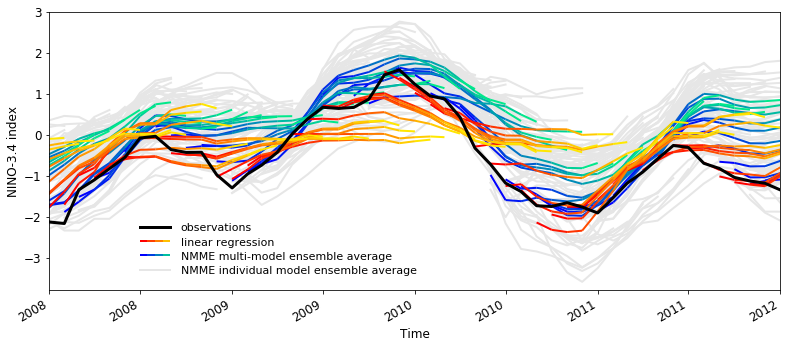

In [209]:
linewidth = 2
fontsize = 12
grey = [0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 

matplotlib.rcParams.update({'font.size': fontsize})
figure = plt.figure(figsize=(11.1,5))
fcst_dates = pd.date_range(start='2006-01', end='2013-01', freq='MS')[::-1]
    
for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plot_fcst(doppyo.utils.leadtime_to_datetime(mmm_nino34[c_gp].sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(mmm_nino34[c_gp].sel(init_date=date)), cmap='winter', 
                  **{'linewidth':linewidth,'label':'NMME multi-model ensemble average'})
    else:
        plot_fcst(doppyo.utils.leadtime_to_datetime(mmm_nino34[c_gp].sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(mmm_nino34[c_gp].sel(init_date=date)), cmap='winter', 
                  **{'linewidth':linewidth,'label':'_nolegend_'})
    
for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plot_fcst(doppyo.utils.leadtime_to_datetime(linR_nino34[c_gp].sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(linR_nino34[c_gp].sel(init_date=date)), cmap='autumn', 
                  **{'linewidth':linewidth,'label':'Linear regression'})
    else:
        plot_fcst(doppyo.utils.leadtime_to_datetime(linR_nino34[c_gp].sel(init_date=date)).time,
                  doppyo.utils.leadtime_to_datetime(linR_nino34[c_gp].sel(init_date=date)), cmap='autumn', 
                  **{'linewidth':linewidth,'label':'_nolegend_'})

for idx, date in enumerate(fcst_dates):
    if idx == 0:
        plt.plot(doppyo.utils.leadtime_to_datetime(cola_nino34[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(cola_nino34[c_gp].sel(init_date=date)).mean('ensemble'),
                 color=grey, zorder=1, label='NMME individual model ensemble average', linewidth=linewidth)
    else:
        plt.plot(doppyo.utils.leadtime_to_datetime(cola_nino34[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(cola_nino34[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(aer04_nino34[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(aer04_nino34[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(florA_nino34[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(florA_nino34[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(florB_nino34[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(florB_nino34[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(cm3_nino34[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(cm3_nino34[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)
for date in fcst_dates:
    plt.plot(doppyo.utils.leadtime_to_datetime(cm4_nino34[c_gp].sel(init_date=date)).time.values,
                 doppyo.utils.leadtime_to_datetime(cm4_nino34[c_gp].sel(init_date=date)).mean('ensemble'), 
                 color=grey, zorder=1, label='_nolegend_', linewidth=linewidth)

# for idx, date in enumerate(fcst_dates):
#     plt.plot(doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)).time.values,
#              doppyo.utils.leadtime_to_datetime(fcst_use.sel(init_date=date)), color=(0.95,0.95,0.95), zorder=0, label='_nolegend_')

obs_2_use[c_gp].sel(lead_time=0).plot(color='k', linestyle='-', linewidth=linewidth+1, label='Observations')

plt.xlim('2008','2012')
plt.ylim(-3.8,3);
plt.xlabel('Time');
plt.ylabel('NINO-3.4 index');
plt.title('')

# Make the legend -----
span = pd.date_range('2008-07-01','2008-09-01', freq='15D')
plt.plot(span, -3.3*np.ones_like(span.astype(int)), color=grey, zorder=1, linewidth=linewidth)
plt.text('2008-09-20', -3.4, 'NMME individual model ensemble average', fontsize=fontsize-1)
plot_fcst(span, -2.95*np.ones_like(span.astype(int)), cmap='winter', **{'linewidth':linewidth})
plt.text('2008-09-20', -3.05, 'NMME multi-model ensemble average', fontsize=fontsize-1)
plot_fcst(span, -2.6*np.ones_like(span.astype(int)), cmap='autumn', **{'linewidth':linewidth})
plt.text('2008-09-20', -2.7, 'linear regression', fontsize=fontsize-1)
plt.plot(span, -2.25*np.ones_like(span.astype(int)), color='k', linestyle='-', linewidth=linewidth+1)
plt.text('2008-09-20', -2.35, 'observations', fontsize=fontsize-1)

plt.tight_layout();
plt.savefig(saveloc + 'nino34_timeseries.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_timeseries.pdf', format='pdf', bbox_inches='tight')

# Let's get an appreciation of the absolute NMME skill by looking at the Gerrity (categorical) skill score and the mean squared skill score (MSSS)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


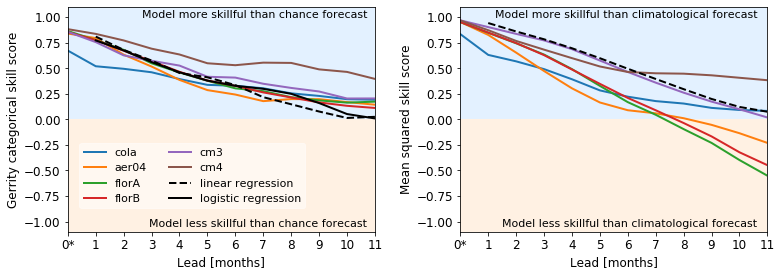

In [211]:
linewidth = 2
fontsize = 12

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(11.1,4))
axes = fig.subplots(nrows=1, ncols=2)

# Pierce's score =============================================================
ref = where_event
models = [where_event_cola, 
          where_event_aer04,
          where_event_florA,
          where_event_florB,
          where_event_cm3,
          where_event_cm4,
          where_event_linR,
          ologR_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4','linear regression', 'logistic regression']
edges = [-np.inf, -0.5, 0.5, np.inf]

for idx, model in enumerate(models):
    ax0 = axes[0]     
    obs = ref[c_gp].sel(init_date=slice('1999','2015'))
    fcst = model[c_gp].sel(init_date=slice('1999','2015'))
    contingency = doppyo.skill.contingency(fcst, obs, edges, edges, over_dims='init_date')
    # ax0.plot([-1,12],[0,0],'-',color=[0.85,0.85,0.85], zorder=0)
    if model_name[idx] == 'linear regression':
        doppyo.skill.Gerrity_score(contingency).plot(ax=ax0, label=model_name[idx], linewidth=linewidth, color='k', linestyle='--')
    elif model_name[idx] == 'ordered logistic regression':
        doppyo.skill.Gerrity_score(contingency).plot(ax=ax0, label=model_name[idx], linewidth=linewidth, color='k', linestyle=':')
    else:
        doppyo.skill.Gerrity_score(contingency).plot(ax=ax0, label=model_name[idx], linewidth=linewidth, color=colors[idx])
    legend = ax0.legend(ncol=2, fontsize=fontsize-1, loc='lower left', bbox_to_anchor=[0.02,0.08,1,1], framealpha=0.5)
    legend.get_frame().set_facecolor('w')
    legend.get_frame().set_edgecolor('w')
    ax0.set_xlim(0,11)
    ax0.set_xticks(np.arange(0,12))
    ax0.set_ylim(-1.1,1.1)
    ax0.set_ylabel("Gerrity categorical skill score")
    ax0.set_xlabel('Lead [months]')
    
# Shade regions ------
ymin, ymax = ax0.get_ylim()
xmin, xmax = ax0.get_xlim()
ax0.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                 facecolor=upper_color, linewidth=0.0, zorder=0)
ax0.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                 facecolor=lower_color, linewidth=0.0, zorder=0)
ax0.text(2.65,0.99,'Model more skillful than chance forecast', fontsize=fontsize-1)
ax0.text(2.9,-1.05,'Model less skillful than chance forecast', fontsize=fontsize-1)
ax0.set_xticks(np.arange(0,12))
ax0.set_xticklabels(['0*'] + np.arange(1,12).tolist())

# MSSS ======================================================================
models = [cola_nino34.mean('ensemble'), aer04_nino34.mean('ensemble'), florA_nino34.mean('ensemble'), 
          florB_nino34.mean('ensemble'), cm3_nino34.mean('ensemble'), cm4_nino34.mean('ensemble'), linR_nino34]

# Climatological forecast -----
clim_period = slice('1982','1998')
clim = obs_2_use['full'].sel(init_date=clim_period, lead_time=0).groupby('init_date.month').mean('init_date').drop('lead_time')
clim_fcst = (0*obs_2_use['full']).groupby('init_date').apply(lambda_anomalize, clim=-clim)
    
for idx, model in enumerate(models):
    ax1 = axes[1]
    MSE_f = doppyo.skill.mean_squared_error(model[c_gp], obs_2_use[c_gp], over_dims='init_date')
    MSE_o = doppyo.skill.mean_squared_error(clim_fcst, obs_2_use['full'], over_dims='init_date')
    # ax1.plot([-1,12],[0,0],'-',color=[0.85,0.85,0.85], zorder=0)
    if model is linR_nino34:
        (1 - MSE_f / MSE_o).plot(ax=ax1, linewidth=linewidth, color='k', linestyle='--')
    else:
        (1 - MSE_f / MSE_o).plot(ax=ax1, linewidth=linewidth, color=colors[idx])

ax1.set_xlim(0,11)
ax1.set_xticks(np.arange(0,12))
ax1.set_ylim(-1.1,1.1)
ax1.set_ylabel('Mean squared skill score')
ax1.set_xlabel('Lead [months]')
ax1.set_xticks(np.arange(0,12))
ax1.set_xticklabels(['0*'] + np.arange(1,12).tolist())

# Shade regions ------
ymin, ymax = ax1.get_ylim()
xmin, xmax = ax1.get_xlim()
ax1.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                 facecolor=upper_color, linewidth=0.0, zorder=0)
ax1.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                 facecolor=lower_color, linewidth=0.0, zorder=0)
ax1.text(1.25,0.99,'Model more skillful than climatological forecast', fontsize=fontsize-1)
ax1.text(1.5,-1.05,'Model less skillful than climatological forecast', fontsize=fontsize-1)
    
fig.tight_layout()
plt.savefig(saveloc + 'nino34_Gerrity_and_MSSS.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_Gerrity_and_MSSS.pdf', format='pdf', bbox_inches='tight')

# Can we make a schematic showing the different types of anomaly calculation?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


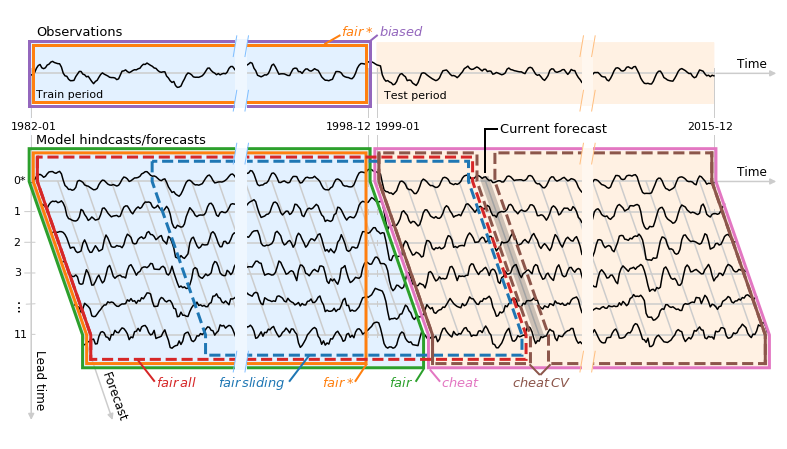

In [212]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(13.8,8))
ax = fig.add_subplot(111)
grey = [0.8,0.8,0.8]
linewidth = 2
border_linewidth = 3

leads = [0,1,2,3,6,11]
shift = 6
clip_ends = 4

period = slice('1982-01','2015-12')
obs = obs_2_use['full'].sel(init_date=period, lead_time=0).rename({'init_date':'time'})
hcst = cm4_nino34['full'].sel(init_date=period).mean('ensemble')

obs_plot = obs[:-len(leads)*clip_ends]+2.5*shift
time_plot = obs_plot.time
min_time = time_plot.min().values
max_time = time_plot.max().values
plt.plot(time_plot,obs_plot,color='k', linewidth=linewidth-0.5)
plt.plot([min_time, max_time],[obs_plot.mean('time'), obs_plot.mean('time')], color=grey, zorder=0, linewidth=linewidth-0.5)
ax.annotate("", xy=(mdates.date2num(max_time)+1100, obs_plot.mean('time')), xycoords='data',
                        xytext=(mdates.date2num(max_time), obs_plot.mean('time')), textcoords='data',
                        arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
plt.text(doppyo.sugar.month_delta(max_time, 13), obs_plot.mean('time')+1.1, 'Time', fontsize=fontsize)

# Patch vertices -----
hcst_span = 189
gap = 5
v1_s = [[mdates.date2num(min_time), obs_plot.mean('time').values+shift]]
v1_e = [[mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span)), obs_plot.mean('time').values+shift]]
v2_s = [[mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span+gap)), obs_plot.mean('time').values+shift]]
v2_e = [[mdates.date2num(max_time), obs_plot.mean('time').values+shift]]

# Anomaly boxes -----
adj_x = 35 #22
adj_y = 0.41 #0.25
c0 = [[mdates.date2num(min_time)-adj_x, obs_plot.mean('time').values-shift-adj_y], 
      [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))+adj_x, obs_plot.mean('time').values-shift-adj_y],
      [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))+adj_x, obs_plot.mean('time').values+shift+adj_y], 
      [mdates.date2num(min_time)-adj_x, obs_plot.mean('time').values+shift+adj_y]]
c3a = [[mdates.date2num(min_time)+adj_x, obs_plot.mean('time').values-shift+adj_y], 
      [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))-adj_x, obs_plot.mean('time').values-shift+adj_y],
      [mdates.date2num(doppyo.sugar.month_delta(min_time,hcst_span))-adj_x, obs_plot.mean('time').values+shift-adj_y], 
      [mdates.date2num(min_time)+adj_x, obs_plot.mean('time').values+shift-adj_y]]

for idx, lead in enumerate(leads):
    if idx == 0:
        hcst_plot = (hcst.sel(lead_time=lead)-(idx+1)*shift)[idx*clip_ends:-(len(leads)-idx)*clip_ends]
        first_mean = hcst_plot.mean('init_date')
    else:
        hcst_plot = hcst.sel(lead_time=lead)[idx*clip_ends:-(len(leads)-idx)*clip_ends]
        hcst_plot = hcst_plot - hcst_plot.mean('init_date') + first_mean - idx*shift
        
    time_plot = [doppyo.sugar.month_delta(date, idx*2) for date in hcst_plot.init_date.values]

    plt.plot(time_plot, hcst_plot, color='k', linewidth=linewidth-0.5)
    plt.plot([min(time_plot), max(time_plot)],[hcst_plot.mean('init_date'), hcst_plot.mean('init_date')], color=grey, zorder=0, linewidth=linewidth-0.5)
    if idx == 0:
        ax.annotate("", xy=(mdates.date2num(max(time_plot))+1100, hcst_plot.mean('init_date')), xycoords='data',
                        xytext=(mdates.date2num(max(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                        arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
        plt.text(doppyo.sugar.month_delta(max(time_plot),13), hcst_plot.mean('init_date')+1.1, 'Time', fontsize=fontsize)
        ax.annotate("", xy=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')-47), xycoords='data',
                        xytext=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                        arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
        plt.text(doppyo.sugar.month_delta(min(time_plot),1), hcst_plot.mean('init_date')-len(leads)*shift-8, 'Lead time', rotation=-90, fontsize=fontsize)
        ax.annotate("", xy=(mdates.date2num(min(time_plot))+1400, hcst_plot.mean('init_date')-47), xycoords='data',
                        xytext=(mdates.date2num(min(time_plot)), hcst_plot.mean('init_date')), textcoords='data',
                        arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3", color=grey, lw=linewidth-0.5))
        plt.text(doppyo.sugar.month_delta(min(time_plot),38), hcst_plot.mean('init_date')-len(leads)*shift-10.7, 'Forecast', rotation=-70, fontsize=fontsize)
        
        # Make grid -----
        step = 15
        count=0
        for s in np.arange(step, 390, step):
            plt.plot([mdates.date2num(doppyo.sugar.month_delta(min_time,s)),mdates.date2num(doppyo.sugar.month_delta(min_time,s+30))],
                     [hcst_plot.mean('init_date').values, hcst_plot.mean('init_date').values-(len(leads)-1)*shift], color=grey, zorder=1, linewidth=linewidth-0.5)
            if count == 16:
                plt.plot([mdates.date2num(doppyo.sugar.month_delta(min_time,s)),mdates.date2num(doppyo.sugar.month_delta(min_time,s+30))],
                     [hcst_plot.mean('init_date').values, hcst_plot.mean('init_date').values-(len(leads)-1)*shift], color='k', zorder=2, linewidth=linewidth+7, linestyle='-', alpha=0.2)
            count+=1
        v1_s.append([mdates.date2num(min(time_plot)), hcst_plot.mean('init_date').values+shift])
        v1_e.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span)), hcst_plot.mean('init_date').values+shift])
        v2_s.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span+gap)), hcst_plot.mean('init_date').values+shift])
        v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values+shift])
    
    # Patch vertices -----
    v1_s.append([mdates.date2num(min(time_plot)), hcst_plot.mean('init_date').values])
    v1_e.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span)), hcst_plot.mean('init_date').values])
    v2_s.append([mdates.date2num(doppyo.sugar.month_delta(min(time_plot),hcst_span+gap)), hcst_plot.mean('init_date').values])
    v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values])
    if idx == len(leads)-1:
        time_extra = min(time_plot) #doppyo.sugar.month_delta(min(time_plot),lead+(leads[1]-leads[0]))
        v1_s.append([mdates.date2num(time_extra), hcst_plot.mean('init_date').values-shift])
        v1_e.append([mdates.date2num(doppyo.sugar.month_delta(time_extra,hcst_span)), hcst_plot.mean('init_date').values-shift])
        v2_s.append([mdates.date2num(doppyo.sugar.month_delta(time_extra,hcst_span+gap)), hcst_plot.mean('init_date').values-shift])
        v2_e.append([mdates.date2num(max(time_plot)), hcst_plot.mean('init_date').values-shift])
        
v1 = v1_s + v1_e[::-1]
v2 = v2_s + v2_e[::-1]
pgon1 = plt.Polygon(v1, color=upper_color, zorder=0)
pgon2 = plt.Polygon(v2, color=lower_color, zorder=0)
ax.add_patch(pgon1)
ax.add_patch(pgon2)

vw = [[mdates.date2num(min_time)-1,27],[mdates.date2num(max_time)+1,27],
      [mdates.date2num(max_time)+1,36],[mdates.date2num(min_time)-1,36]]
pgonw = plt.Polygon(vw, color='w', zorder=0)
ax.add_patch(pgonw)

# Anomaly boxes -----
pgonc0 = plt.Polygon(c0, edgecolor=colors[4], linewidth=border_linewidth,fill=False, zorder=10)
ax.add_patch(pgonc0)
c1 = [[v[0]+0*adj_x, v[1]] for v in v2_s[1:]] + v2_e[1:][::-1]
v_tmp = v2_e[1:][::-1]
c1 = [[v[0]-1*adj_x, v[1]] for v in [[v2_s[1][0], v2_s[1][1]+1*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]-1*adj_y]]] + \
        [[v[0]+1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]]
pgonc1 = plt.Polygon(c1, edgecolor=colors[6], linewidth=border_linewidth,fill=False, zorder=10)
ax.add_patch(pgonc1)
v_tmp = v1_e[1:][::-1]
c2 = [[v[0]-1*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]+1*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]-1*adj_y]]] + \
        [[v[0]+1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]]
pgonc2 = plt.Polygon(c2, edgecolor=colors[2], linewidth=border_linewidth,fill=False, zorder=10)
ax.add_patch(pgonc2)
pgonc3a = plt.Polygon(c3a, edgecolor=colors[1], linewidth=border_linewidth,fill=False, zorder=10)
ax.add_patch(pgonc3a)
v_tmp = v1_e[1:3] + [[v1_e[1][0],v1_e[-1][1]]]
c3b = [[v[0]+1*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-1*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+1*adj_y]]] + \
        [[v[0]-1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]-1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]+1*adj_y]]][::-1]
pgonc3b = plt.Polygon(c3b, edgecolor=colors[1], linewidth=border_linewidth,fill=False, zorder=10)
ax.add_patch(pgonc3b)

v_tmp = v1_e[1:][::-1]
slide = 1890
cs = [[v[0]+5*adj_x+slide, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-5*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+5*adj_y]]] + \
        [[v[0]-5*adj_x+slide, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+5*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-5*adj_y]]]
pgoncs = plt.Polygon(cs, edgecolor=colors[0], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
ax.add_patch(pgoncs)

ca = [[v[0]+3*adj_x, v[1]] for v in [[v1_s[1][0], v1_s[1][1]-3*adj_y]]+v1_s[2:-1]+[[v1_s[-1][0], v1_s[-1][1]+3*adj_y]]] + \
        [[v[0]-3*adj_x+slide, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+3*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-3*adj_y]]]
pgonca = plt.Polygon(ca, edgecolor=colors[3], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
ax.add_patch(pgonca)
c_solid = ca[0:8]
plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[3], linewidth=border_linewidth, zorder=11)


v_tmp = v2_e[1:][::-1]
c1cva = [[v[0]+1*adj_x, v[1]] for v in [[v2_s[1][0], v2_s[1][1]-1*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]+1*adj_y]]] + \
        [[v[0]-1*adj_x-(5900-slide), v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-1*adj_y]]]
pgonc1cva = plt.Polygon(c1cva, edgecolor=colors[5], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
c_solid = c1cva[0:8]
plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[5], linewidth=border_linewidth, zorder=11)
ax.add_patch(pgonc1cva)
c1cvb = [[v[0]+1*adj_x+1980, v[1]] for v in [[v2_s[1][0], v2_s[1][1]-1*adj_y]]+v2_s[2:-1]+[[v2_s[-1][0], v2_s[-1][1]+1*adj_y]]] + \
        [[v[0]-1*adj_x, v[1]] for v in [[v_tmp[0][0], v_tmp[0][1]+1*adj_y]]+v_tmp[1:-1]+[[v_tmp[-1][0], v_tmp[-1][1]-1*adj_y]]]
pgonc1cvb = plt.Polygon(c1cvb, edgecolor=colors[5], linewidth=border_linewidth,fill=False, zorder=10, linestyle='--')
ax.add_patch(pgonc1cvb)
c_solid = c1cvb[-8:]
plt.plot([c[0] for c in c_solid], [c[1] for c in c_solid], color=colors[5], linewidth=border_linewidth, zorder=11)

ax.set_ylim(-30,55)
ax.set_xlim('1981','2017')
ax.text(mdates.date2num(min_time)+80, 49.3, 'Observations',fontsize=fontsize+1)
ax.text(mdates.date2num(min_time)+80, 28.4, 'Model hindcasts/forecasts',fontsize=fontsize+1)
ax.text(doppyo.sugar.month_delta(min_time,hcst_span-186), 37.3, 'Train period',fontsize=fontsize-1)
ax.text(doppyo.sugar.month_delta(max_time,-185), 37.1, 'Test period',fontsize=fontsize-1)
ax.text(mdates.date2num(min_time)+8000, 30.4, 'Current forecast',fontsize=fontsize+1, zorder=11)
plt.plot((mdates.date2num(min_time)+7750, mdates.date2num(min_time)+7750), (22.8,31.2), color='k', linewidth=linewidth, zorder=11,linestyle='-')
plt.plot((mdates.date2num(min_time)+7750, mdates.date2num(min_time)+7950), (31.2,31.2), color='k', linewidth=linewidth, zorder=11,linestyle='-')

# Add breaks -----
start = mdates.date2num(min_time)+3480
width = 200
height = 2.7
offset = 0.5
slant = 30
col = ((9*upper_color - 8) + 1) / 2
col_fill = ((9*upper_color - 8) + 15) / 16
vb1 = [[start,-15.9],[start+width,-15.9],
      [start+width,48.8],[start,48.8]]
pgonb1 = plt.Polygon(vb1, zorder=10, hatch=None, facecolor=col_fill, edgecolor=col_fill, linewidth=0)
ax.add_patch(pgonb1)
vw1 = [[start,27.5],[start+width,27.5],
      [start+width,35.3],[start,35.3]]
pgonw1 = plt.Polygon(vw1, zorder=10, hatch=None, facecolor='w', edgecolor='w', linewidth=0)
ax.add_patch(pgonw1)
plt.plot([start-slant, start+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start+width-slant, start+width+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start-slant, start+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start+width-slant, start+width+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start-slant, start+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start+width-slant, start+width+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start-slant, start+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start+width-slant, start+width+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)

start = mdates.date2num(min_time)+9400
col = ((9*lower_color - 8) + 1) / 2
col_fill = ((9*lower_color - 8) + 15) / 16
vb2 = [[start,-15.9],[start+width,-15.9],
      [start+width,48.5],[start,48.5]]
pgonb2 = plt.Polygon(vb2, zorder=10, hatch=None, facecolor=col_fill, edgecolor=col_fill, linewidth=0)
ax.add_patch(pgonb2)
vw2 = [[start,27.5],[start+width,27.5],
      [start+width,35.6],[start,35.6]]
pgonw2 = plt.Polygon(vw2, zorder=10, hatch=None, facecolor='w', edgecolor='w', linewidth=0)
ax.add_patch(pgonw2)
plt.plot([start-slant, start+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start+width-slant, start+width+slant],[48-height, 48+offset*height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start-slant, start+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start+width-slant, start+width+slant],[36-offset*height, 36+height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start-slant, start+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start+width-slant, start+width+slant],[27-height, 27+offset*height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start-slant, start+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)
plt.plot([start+width-slant, start+width+slant],[-15-offset*height, -15+height], zorder=11, color=col, linewidth=linewidth-1)

# Add dates -----
yloc = 31
ax.text(mdates.date2num(min_time)-350, yloc, '1982-01', fontsize=fontsize-1)
ax.text(mdates.date2num(min_time)+5030, yloc, '1998-12', fontsize=fontsize-1)
ax.text(mdates.date2num(min_time)+5870, yloc, '1999-01', fontsize=fontsize-1)
ax.text(mdates.date2num(min_time)+11200, yloc, '2015-12', fontsize=fontsize-1)

# Add lead time ticks -----
straighten = 0.6
base = 21
ticks = ['0*','1','2','3','...','11']
for idx, tick in enumerate(ticks):
    if tick == '...':
        ax.annotate(tick, xy=(mdates.date2num(min_time)+100, base-idx*shift), xycoords='data', rotation=90,fontsize=fontsize+3,
                    xytext=(mdates.date2num(min_time)-410, base-idx*shift-1.7*straighten), textcoords='data',
                    arrowprops=dict(arrowstyle="-", color=grey, linewidth=linewidth-1))
    else:        
        ax.annotate(tick, xy=(mdates.date2num(min_time)+100, base-idx*shift), xycoords='data',fontsize=fontsize-1,
                    xytext=(mdates.date2num(min_time)-300, base-idx*shift-straighten), textcoords='data',
                    arrowprops=dict(arrowstyle="-", color=grey, linewidth=linewidth-1))
        
# Legend -----
plt.plot((doppyo.sugar.month_delta(min_time,166+24), doppyo.sugar.month_delta(min_time,170+24)),
         (48.3,49.4), color=colors[4], linewidth=linewidth, zorder=20)
ax.text(doppyo.sugar.month_delta(min_time,170+25), 49.4, '$biased$', fontsize=fontsize+1, color=colors[4])

plt.plot((doppyo.sugar.month_delta(min_time,240-16), doppyo.sugar.month_delta(min_time,245-16)),
         (-16.0,-18.1), color=colors[6], linewidth=linewidth, zorder=20)
ax.text(doppyo.sugar.month_delta(min_time,246-16), -19.3, '$cheat$', fontsize=fontsize+1, color=colors[6])

plt.plot((doppyo.sugar.month_delta(min_time,240+40), doppyo.sugar.month_delta(min_time,245+40)),
         (-15.0,-16.8), color=colors[5], linewidth=linewidth, zorder=20)
plt.plot((doppyo.sugar.month_delta(min_time,245+46), doppyo.sugar.month_delta(min_time,240+46)),
         (-15.0,-16.8), color=colors[5], linewidth=linewidth, zorder=20)
ax.text(doppyo.sugar.month_delta(min_time,246+24), -19.3, '$cheat\, CV$', fontsize=fontsize+1, color=colors[5])

plt.plot((doppyo.sugar.month_delta(min_time,235-15), doppyo.sugar.month_delta(min_time,231-15)),
         (-15.9,-18.1), color=colors[2], linewidth=linewidth, zorder=20)
ax.text(doppyo.sugar.month_delta(min_time,221-20), -19.3, '$fair$', fontsize=fontsize+1, color=colors[2])

plt.plot((doppyo.sugar.month_delta(min_time,164+24), doppyo.sugar.month_delta(min_time,169+13)),
         (-14.9,-18.1), color=colors[1], linewidth=linewidth, zorder=20)
ax.text(doppyo.sugar.month_delta(min_time,169-6), -19.3, '$fair*$', fontsize=fontsize+1, color=colors[1])
plt.plot((doppyo.sugar.month_delta(min_time,147+18), doppyo.sugar.month_delta(min_time,155+18)),
         (47.8,49.4), color=colors[1], linewidth=linewidth, zorder=20)
ax.text(doppyo.sugar.month_delta(min_time,155+19), 49.4, '$fair*$', fontsize=fontsize+1, color=colors[1])

plt.plot((doppyo.sugar.month_delta(min_time,164-8), doppyo.sugar.month_delta(min_time,164-19)),
         (-13.1,-18.1), color=colors[0], linewidth=linewidth, zorder=20)
ax.text(doppyo.sugar.month_delta(min_time,165-60), -19.3, '$fair\, sliding$', fontsize=fontsize+1, color=colors[0])

plt.plot((doppyo.sugar.month_delta(min_time,104-44), doppyo.sugar.month_delta(min_time,104-35)),
         (-14.1,-18.1), color=colors[3], linewidth=linewidth, zorder=20)
ax.text(doppyo.sugar.month_delta(min_time,165-95), -19.3, '$fair\, all$', fontsize=fontsize+1, color=colors[3])

# plt.plot((doppyo.sugar.month_delta(min_time,90), doppyo.sugar.month_delta(min_time,90)),
#          (33.5,35.5), color=colors[0], linewidth=linewidth, zorder=20)
# ax.text(doppyo.sugar.month_delta(min_time,85), 31, 'C0', fontsize=fontsize+2, color=colors[0])
# plt.plot((doppyo.sugar.month_delta(min_time,110), doppyo.sugar.month_delta(min_time,110)),
#          (33.5,36.4), color=colors[3], linewidth=linewidth, zorder=20)
# plt.plot((doppyo.sugar.month_delta(min_time,110), doppyo.sugar.month_delta(min_time,110)),
#          (27,30), color=colors[3], linewidth=linewidth, zorder=20)
# ax.text(doppyo.sugar.month_delta(min_time,105), 31, 'C3', fontsize=fontsize+2, color=colors[3])
# plt.plot((doppyo.sugar.month_delta(min_time,130), doppyo.sugar.month_delta(min_time,130)),
#          (27.5,30), color=colors[2], linewidth=linewidth, zorder=20)
# ax.text(doppyo.sugar.month_delta(min_time,125), 31, 'C2', fontsize=fontsize+2, color=colors[2])
# plt.plot((doppyo.sugar.month_delta(min_time,205), doppyo.sugar.month_delta(min_time,205)),
#          (27.3,30), color=colors[1], linewidth=linewidth, zorder=20)
# ax.text(doppyo.sugar.month_delta(min_time,200), 31, 'C1', fontsize=fontsize+2, color=colors[1])

plt.plot((min_time, min_time), (20,30), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
plt.plot((min_time, min_time), (33.5,43), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
# for tick in np.arange(len(leads)):
#     plt.plot((min_time, min_time), (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), (20,30), 
         color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), (33.5,43), 
         color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
for tick in np.arange(len(leads)):
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span), doppyo.sugar.month_delta(min_time,hcst_span)), 
             (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), (20,30), 
         color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), (33.5,43), 
         color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
for tick in np.arange(len(leads)):
    plt.plot((doppyo.sugar.month_delta(min_time,hcst_span+gap), doppyo.sugar.month_delta(min_time,hcst_span+gap)), 
             (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
plt.plot((max_time, max_time), (20,30), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
plt.plot((max_time, max_time), (33.5,43), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')
for tick in np.arange(len(leads)):
    plt.plot((max_time, max_time), (21-shift*tick-0.5,21-shift*tick+0.5), color=grey, linewidth=linewidth-1, zorder=1,linestyle='-')

ax.axis('off');
plt.savefig(saveloc + 'anomaly_schematic.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'anomaly_schematic.pdf', format='pdf', bbox_inches='tight')

# What is the (sign test) skill relative to linear regression for each of the different anomaly types?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


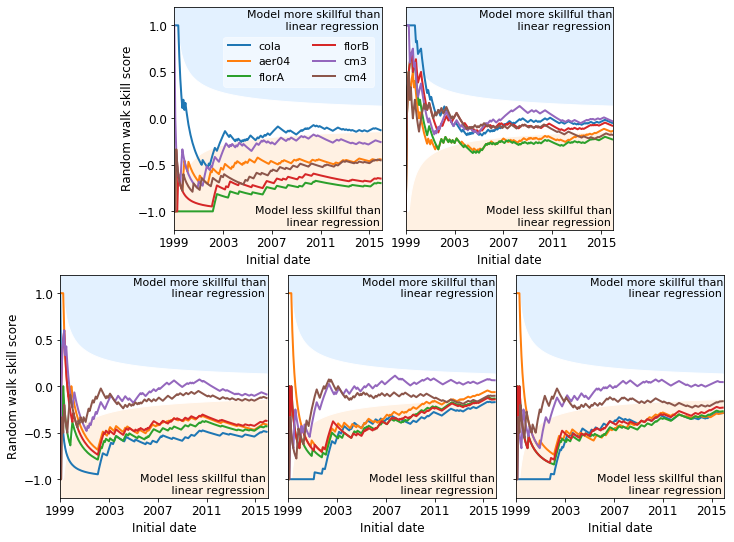

In [184]:
# linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.6,3.1))
axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.2,0.3,1],[0.33,-1.2,0.3,1],[0.66,-1.2,0.3,1]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

lead = 3
anoms = ['c0','c1ncv','c2', 'c2slide', 'c2all']
models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

for idx, anom in enumerate(anoms):
    ax = axes[idx]
    
    for idz, model in enumerate(models):
        sign, conf = doppyo.skill.sign_test(linR_nino34[anom].sel(init_date=slice('1999','2015')), 
                                            model[anom].mean('ensemble').sel(init_date=slice('1999','2015')), 
                                            obs_2_use[anom].sel(init_date=slice('1999','2015')))
        norm = (1 + 0*sign).cumsum('init_date')

        if idz == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.init_date.values,
                            (-1 * conf_plot).sel(lead_time=lead), 
                            conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
        ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label=model_name[idz], color=colors[idz], linewidth=linewidth)

    if idx == 0:
        legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.89], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
        
    ax.set_ylim(-1.2, 1.2)
    if (idx == 0) | (idx == 2):
        ax.set_ylabel('Random walk skill score')
    if (idx == 1) | (idx == 3) | (idx == 4):
        ax.set_yticklabels([])
    ax.set_xlabel('Initial date')
    ax.set_xticks(['1999','2003','2007','2011','2015'])
    ax.set_xticklabels(['1999','2003','2007','2011','2015'])
    ax.set_xlim('1999','2016')
        
    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax.text('2005-01', 0.96, 'Model more skillful than \n           linear regression', fontsize=fontsize-1)
    ax.text('2005-08', -1.15, 'Model less skillful than \n         linear regression', fontsize=fontsize-1)

plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_lead3.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_lead3.pdf', format='pdf', bbox_inches='tight')

### Plot the area under the curves as a function of lead time
Note that when computing the areas, it is important to only include points where the sign_test had the opportunity to change - ie. when supplying masks to the sign_test, the ssame amsks put also be applied before the integral is calculated

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


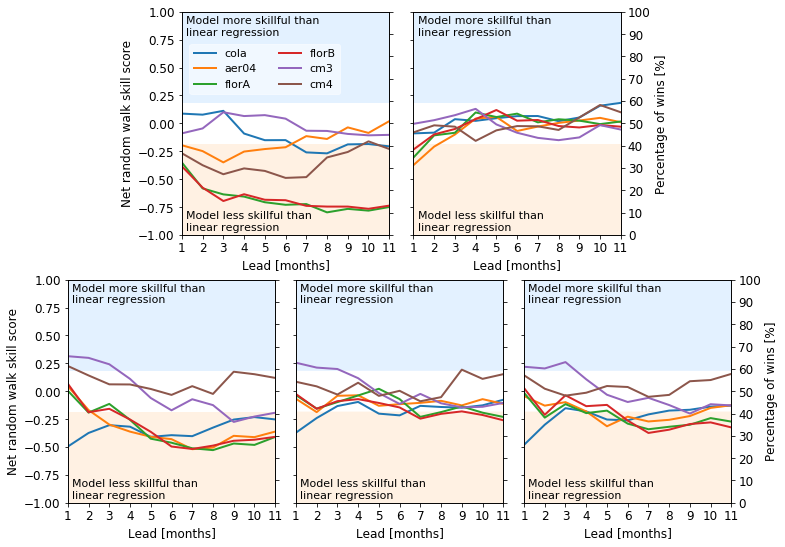

In [179]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.6,3.1))
axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.2,0.3,1],[0.33,-1.2,0.3,1],[0.66,-1.2,0.3,1]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
#axes = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

anoms = ['c0','c1ncv','c2', 'c2slide', 'c2all']
models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']


for idx, anom in enumerate(anoms):
    ax = axes[idx]
    
    for idz, model in enumerate(models):
        sign_test = doppyo.skill.sign_test(linR_nino34['c1_1yr'], 
                                           model[anom].mean('ensemble'), 
                                           obs_2_use[anom].sel(init_date=slice('1999','2015')))
            
        
        sign_masked = sign_test[0]
        conf_masked = sign_test[1]
        norm = ((1 + 0*sign_masked).sum('init_date') ** 2 + (1 + 0*sign_masked).sum('init_date')) / 2
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

        if idz == 0:
            ax.fill_between(conf_area.lead_time, -1 * conf_area, conf_area, 
                            facecolor=grey, linewidth=0.0)
            
        ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz], color=colors[idz], linewidth=linewidth)
        
    if idx == 0:
        legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper left', bbox_to_anchor=[0.01,0,1,0.88], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
        
    # Adjust y-axes limits to be symmetric -----
    ymin, ymax = ax.get_ylim()
    ylim = max([abs(ymin), abs(ymax)])
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(0,12))
    ax.set_xlim(1,11)
    if (idx == 0) | (idx == 2):
        ax.set_ylabel('Net random walk skill score')
    if (idx == 1) | (idx == 3) | (idx == 4):
        ax.set_yticklabels([])
    ax.set_xlabel('Lead [months]')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, 1)
    if (idx == 1) | (idx == 4):
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')
    if (idx == 0) | (idx == 2) | (idx == 3):
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels([])
        
    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax.text(1.2,0.79,'Model more skillful than \nlinear regression', fontsize=fontsize-1)
    ax.text(1.2,-0.96,'Model less skillful than \nlinear regression', fontsize=fontsize-1)

plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_integral.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_integral.pdf', format='pdf', bbox_inches='tight')

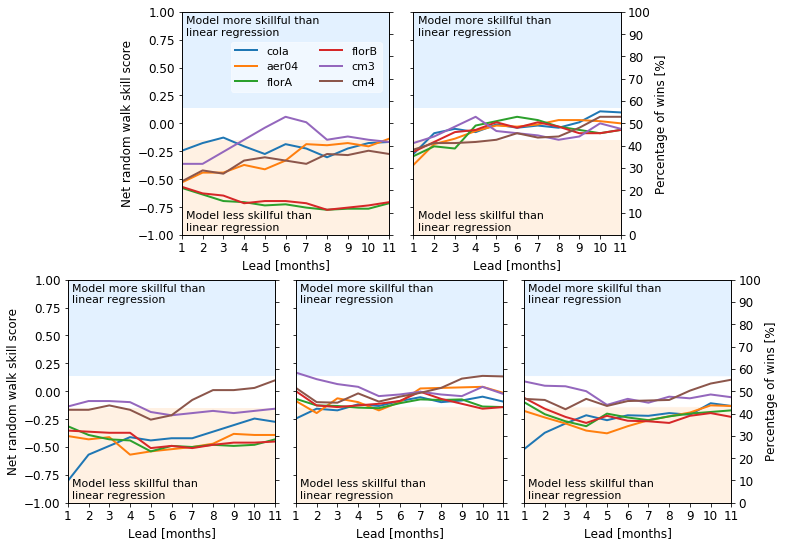

In [345]:
# linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.6,3.1))
axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.2,0.3,1],[0.33,-1.2,0.3,1],[0.66,-1.2,0.3,1]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

lead = 3
anoms = ['c0','c1ncv','c2', 'c2slide', 'c2all']
models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

for idx, anom in enumerate(anoms):
    ax = axes[idx]
    
    for idz, model in enumerate(models):
        sign, conf = doppyo.skill.sign_test(linR_nino34[anom].sel(init_date=slice('1999','2015')), 
                                            model[anom].mean('ensemble').sel(init_date=slice('1999','2015')), 
                                            obs_2_use[anom].sel(init_date=slice('1999','2015')))
        norm = (1 + 0*sign).cumsum('init_date')

        if idz == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date='2015-12-01'), 
                            conf_plot.sel(init_date='2015-12-01'), color=grey, label='_nolegend_')
        ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name[idz], color=colors[idz], linewidth=linewidth)

    if idx == 0:
        legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.89], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
        
#     ax.set_ylim(-1.2, 1.2)
#     if (idx == 0) | (idx == 2):
#         ax.set_ylabel('Random walk skill score')
#     if (idx == 1) | (idx == 3) | (idx == 4):
#         ax.set_yticklabels([])
#     ax.set_xlabel('Initial date')
#     ax.set_xticks(np.arange(0,12))
#     ax.set_xlim(1,11)
    
    # Adjust y-axes limits to be symmetric -----
    ymin, ymax = ax.get_ylim()
    ylim = max([abs(ymin), abs(ymax)])
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(0,12))
    ax.set_xlim(1,11)
    if (idx == 0) | (idx == 2):
        ax.set_ylabel('Net random walk skill score')
    if (idx == 1) | (idx == 3) | (idx == 4):
        ax.set_yticklabels([])
    ax.set_xlabel('Lead [months]')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, 1)
    if (idx == 1) | (idx == 4):
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')
    if (idx == 0) | (idx == 2) | (idx == 3):
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels([])
        
    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax.text(1.2,0.79,'Model more skillful than \nlinear regression', fontsize=fontsize-1)
    ax.text(1.2,-0.96,'Model less skillful than \nlinear regression', fontsize=fontsize-1)

#plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_lead3.eps', format='eps', bbox_inches='tight')
#plt.savefig(saveloc + 'nino34_linR_biased-cheat-fair-fairslide-fairall_lead3.pdf', format='pdf', bbox_inches='tight')

# What is the (sign test) skill relative to logistic regression for each of the different anomaly types?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


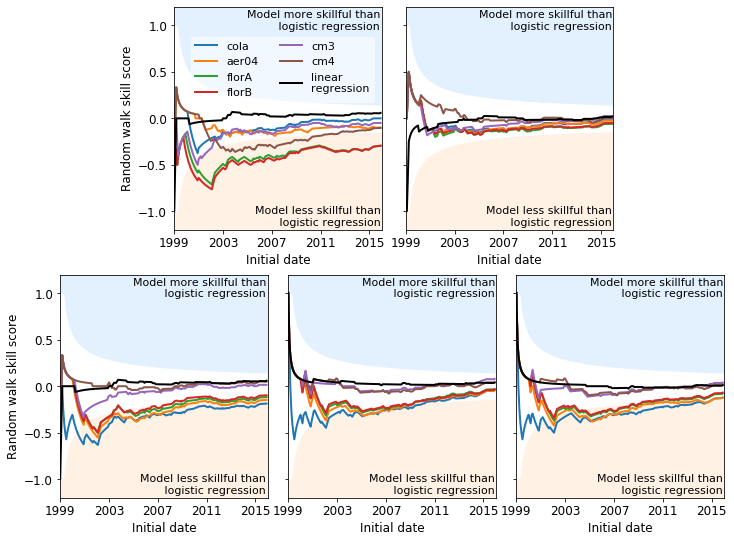

In [185]:
# linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.6,3.1))
axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.2,0.3,1],[0.33,-1.2,0.3,1],[0.66,-1.2,0.3,1]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

lead = 3
anoms = ['c0','c1ncv','c2', 'c2slide', 'c2all']
models = [where_event_cola, where_event_aer04, where_event_florA, where_event_florB, where_event_cm3, where_event_cm4, where_event_linR]
model_name = ['cola','aer04','florA','florB','cm3','cm4', 'linear \nregression']

for idx, anom in enumerate(anoms):
    ax = axes[idx]
    
    for idz, model in enumerate(models):
        sign, conf = doppyo.skill.sign_test(ologR_nino34[anom].sel(init_date=slice('1999','2015')), 
                                            model[anom].sel(init_date=slice('1999','2015')), 
                                            where_event[anom].sel(init_date=slice('1999','2015')), categorical=True)
        norm = (1 + 0*sign).cumsum('init_date')

        if idz == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.init_date.values,
                            (-1 * conf_plot).sel(lead_time=lead), 
                            conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
        if model_name[idz] == 'linear \nregression':
            ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label=model_name[idz], color='k', linewidth=linewidth)
        else:
            ax.plot(sign.init_date, -(sign / norm).sel(lead_time=lead), label=model_name[idz], color=colors[idz], linewidth=linewidth)

    if idx == 0:
        legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.89], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
        
    ax.set_ylim(-1.2, 1.2)
    if (idx == 0) | (idx == 2):
        ax.set_ylabel('Random walk skill score')
    if (idx == 1) | (idx == 3) | (idx == 4):
        ax.set_yticklabels([])
    ax.set_xlabel('Lead [months]')
    ax.set_xlabel('Initial date')
    ax.set_xticks(['1999','2003','2007','2011','2015'])
    ax.set_xticklabels(['1999','2003','2007','2011','2015'])
    ax.set_xlim('1999','2016')
        
    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax.text('2005-01', 0.96, 'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
    ax.text('2005-08', -1.15, 'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_lead3.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_lead3.pdf', format='pdf', bbox_inches='tight')

### Plot the area under the curves as a function of lead time
Note that when computing the areas, it is important to only include points where the sign_test had the opportunity to change - ie. when supplying masks to the sign_test, the ssame amsks put also be applied before the integral is calculated

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


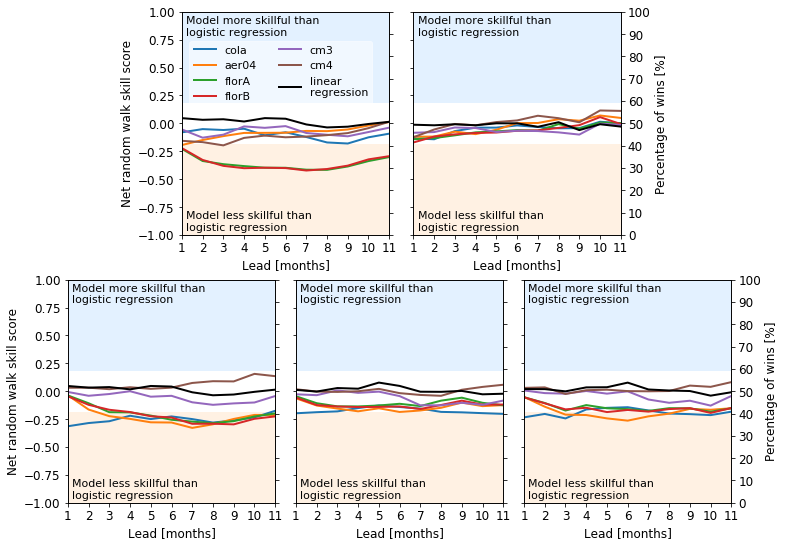

In [186]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.6,3.1))
axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.2,0.3,1],[0.33,-1.2,0.3,1],[0.66,-1.2,0.3,1]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
#axes = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

anoms = ['c0','c1ncv','c2', 'c2slide', 'c2all']
models = [where_event_cola, where_event_aer04, where_event_florA, where_event_florB, where_event_cm3, where_event_cm4, where_event_linR]
model_name = ['cola','aer04','florA','florB','cm3','cm4', 'linear \nregression']


for idx, anom in enumerate(anoms):
    ax = axes[idx]
    
    for idz, model in enumerate(models):
        sign_test = doppyo.skill.sign_test(ologR_nino34[anom], 
                                           model[anom], 
                                           where_event[anom].sel(init_date=slice('1999','2015')), categorical=True)
            
        
        sign_masked = sign_test[0]
        conf_masked = sign_test[1]
        norm = ((1 + 0*sign_masked).sum('init_date') ** 2 + (1 + 0*sign_masked).sum('init_date')) / 2
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

        if idz == 0:
            ax.fill_between(conf_area.lead_time, -1 * conf_area, conf_area, 
                            facecolor=grey, linewidth=0.0)
            
        if model_name[idz] == 'linear \nregression':
            ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz], color='k', linewidth=linewidth)
        else:
            ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz], color=colors[idz], linewidth=linewidth)
    if idx == 0:
        legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper left', bbox_to_anchor=[0.01,0,1,0.895], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')

    # Adjust y-axes limits to be symmetric -----
    ymin, ymax = ax.get_ylim()
    ylim = max([abs(ymin), abs(ymax)])
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(0,12))
    ax.set_xlim(1,11)
    if (idx == 0) | (idx == 2):
        ax.set_ylabel('Net random walk skill score')
    if (idx == 1) | (idx == 3) | (idx == 4):
        ax.set_yticklabels([])
    ax.set_xlabel('Lead [months]')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, 1)
    if (idx == 1) | (idx == 4):
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')
    if (idx == 0) | (idx == 2) | (idx == 3):
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels([])
    
    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax.text(1.2,0.79,'Model more skillful than \nlogistic regression', fontsize=fontsize-1)
    ax.text(1.2,-0.96,'Model less skillful than \nlogistic regression', fontsize=fontsize-1)

plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_integral.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_integral.pdf', format='pdf', bbox_inches='tight')

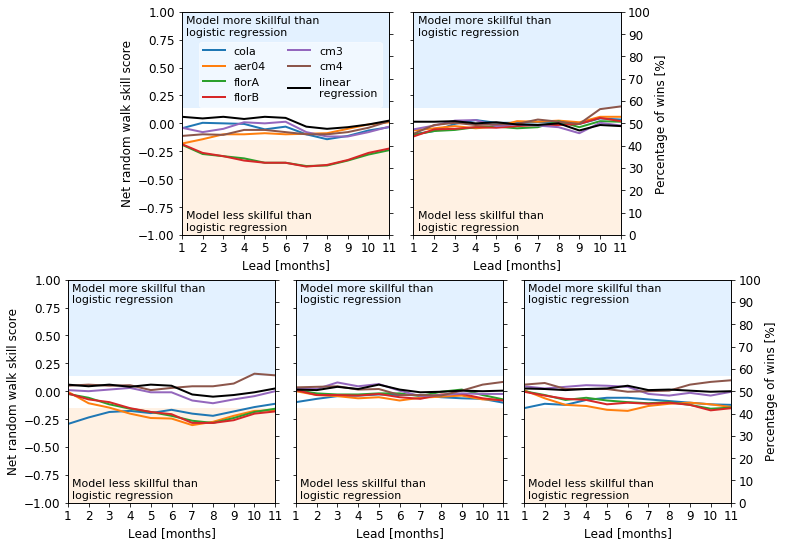

In [347]:
# linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.6,3.1))
axes_locs = [[0.33/2,0,0.3,1],[0.5,0,0.3,1],[0,-1.2,0.3,1],[0.33,-1.2,0.3,1],[0.66,-1.2,0.3,1]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

lead = 3
anoms = ['c0','c1ncv','c2', 'c2slide', 'c2all']
models = [where_event_cola, where_event_aer04, where_event_florA, where_event_florB, where_event_cm3, where_event_cm4, where_event_linR]
model_name = ['cola','aer04','florA','florB','cm3','cm4', 'linear \nregression']

for idx, anom in enumerate(anoms):
    ax = axes[idx]
    
    for idz, model in enumerate(models):
        sign, conf = doppyo.skill.sign_test(ologR_nino34[anom].sel(init_date=slice('1999','2015')), 
                                            model[anom].sel(init_date=slice('1999','2015')), 
                                            where_event[anom].sel(init_date=slice('1999','2015')), categorical=True)
        norm = (1 + 0*sign).cumsum('init_date')

        if idz == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date='2015-12-01'), 
                            conf_plot.sel(init_date='2015-12-01'), color=grey, label='_nolegend_')
        if model_name[idz] == 'linear \nregression':
            ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name[idz], color='k', linewidth=linewidth)
        else:
            ax.plot(sign.lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name[idz], color=colors[idz], linewidth=linewidth)

    if idx == 0:
        legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.89], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
        
    # Adjust y-axes limits to be symmetric -----
    ymin, ymax = ax.get_ylim()
    ylim = max([abs(ymin), abs(ymax)])
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(0,12))
    ax.set_xlim(1,11)
    if (idx == 0) | (idx == 2):
        ax.set_ylabel('Net random walk skill score')
    if (idx == 1) | (idx == 3) | (idx == 4):
        ax.set_yticklabels([])
    ax.set_xlabel('Lead [months]')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, 1)
    if (idx == 1) | (idx == 4):
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
        ax2.set_ylabel('Percentage of wins [%]')
    if (idx == 0) | (idx == 2) | (idx == 3):
        ax2.set_yticks(np.arange(0,1.1,0.1))
        ax2.set_yticklabels([])
    
    # Shade regions ------
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                     facecolor=upper_color, linewidth=0.0, zorder=0)
    ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                     facecolor=lower_color, linewidth=0.0, zorder=0)
    ax.text(1.2,0.79,'Model more skillful than \nlogistic regression', fontsize=fontsize-1)
    ax.text(1.2,-0.96,'Model less skillful than \nlogistic regression', fontsize=fontsize-1)
    
#     ax.set_ylim(-1.2, 1.2)
#     if (idx == 0) | (idx == 2):
#         ax.set_ylabel('Random walk skill score')
#     if (idx == 1) | (idx == 3) | (idx == 4):
#         ax.set_yticklabels([])
#     ax.set_xlabel('Lead [months]')
#     ax.set_xlabel('Initial date')
#     ax.set_xticks(['1999','2003','2007','2011','2015'])
#     ax.set_xticklabels(['1999','2003','2007','2011','2015'])
#     ax.set_xlim('1999','2016')
        
#     # Shade regions ------
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
#                      facecolor=upper_color, linewidth=0.0, zorder=0)
#     ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
#                      facecolor=lower_color, linewidth=0.0, zorder=0)
#     ax.text('2005-01', 0.96, 'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
#     ax.text('2005-08', -1.15, 'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

# plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_lead3.eps', format='eps', bbox_inches='tight')
# plt.savefig(saveloc + 'nino34_olog_biased-cheat-fair-fairslide-fairall_lead3.pdf', format='pdf', bbox_inches='tight')

# How do the model **c1** anomalies compare when assessed relative to observed **c2** anomalies?

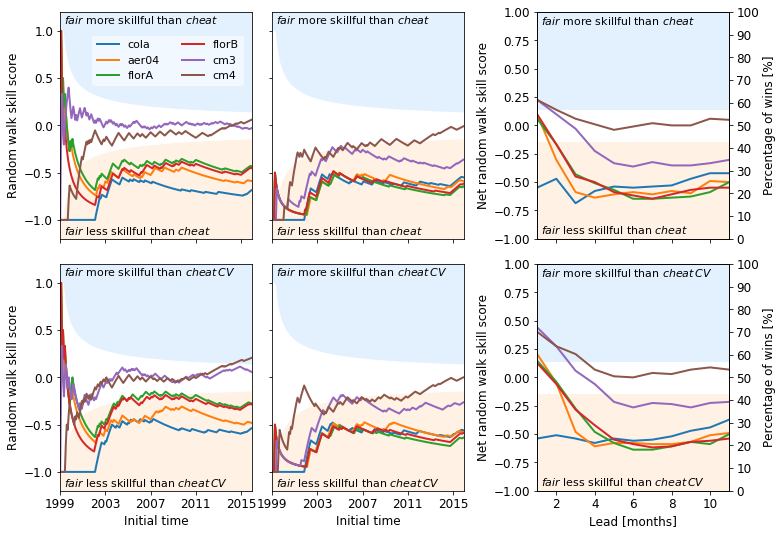

In [351]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.2,7))
axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
            [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
anoms = [('c1ncv',c_gp), ('c1_7yr',c_gp)]
models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

count=0
for idx, anom in enumerate(anoms):
    for idy, model in enumerate(models):
        for idz, lead in enumerate(leads):
            axI = idx * len(leads) + idz + count
            ax = axes[axI]
            sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                model[anom[1]].mean('ensemble'), 
                                                obs_2_use[c_gp].sel(init_date=slice('1999','2015')))
            norm = (1 + 0*sign).cumsum('init_date')

            if idy == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
            ax.plot((sign / norm).init_date, -(sign / norm).sel(lead_time=lead), label=model_name[idy], linewidth=linewidth)

            ax.set_xlim('1999','2016')
            ax.set_xticks(['1999','2003','2007','2011','2015'])
            ax.set_xticklabels(['1999','2003','2007','2011','2015'])
            if axI < len(anoms) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Initial time')
            if idz == 0:
                ax.set_ylabel('Random walk skill score')

            ax.set_ylim(-1.2,1.2)
            if idz > 0:
                ax.set_yticklabels([])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if (idy == 0) & (idx == 0):
                ax.text('1999-05',1.07,'$fair$ more skillful than $cheat$', fontsize=fontsize-1)
                ax.text('1999-05',-1.16,'$fair$ less skillful than $cheat$', fontsize=fontsize-1)
            elif (idy == 0) & (idx == 1):
                ax.text('1999-05',1.07,'$fair$ more skillful than $cheat\, CV$', fontsize=fontsize-1)
                ax.text('1999-05',-1.16,'$fair$ less skillful than $cheat\, CV$', fontsize=fontsize-1)

            if (idx == 0) & (idz == 0) & (idy == len(models)-1):
                leg = legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0.00,0.00,0.98,0.92], framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

        ax = axes[axI+1]
#         sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
#                                            model[anom[1]].mean('ensemble'), 
#                                            obs_2_use[c_gp].sel(init_date=slice('1999','2015')))

#         sign_masked = sign_test[0].fillna(0)
#         conf_masked = sign_test[1].fillna(0)
#         norm = ((1 + 0*sign_masked).sum('init_date') ** 2 + (1 + 0*sign_masked).sum('init_date')) / 2
#         sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
#                                            x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
#         conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
#                                            x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

#         if idy == 0:
#             ax.fill_between(conf_area.lead_time,
#                             -1 * conf_area, conf_area, color=grey, label='_nolegend_')
#         ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz], linewidth=linewidth)
        
        
        sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                            model[anom[1]].mean('ensemble'), 
                                            obs_2_use[c_gp].sel(init_date=slice('1999','2015')))
        norm = (1 + 0*sign).cumsum('init_date')

        if idy == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date='2015-12-01'), 
                            conf_plot.sel(init_date='2015-12-01'), color=grey, label='_nolegend_')
        ax.plot((sign / norm).lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name[idy], linewidth=linewidth)

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        
        if (idy == 0) & (idx == 0):
            ax.text(1.2,0.89,'$fair$ more skillful than $cheat$', fontsize=fontsize-1)
            ax.text(1.2,-0.96,'$fair$ less skillful than $cheat$', fontsize=fontsize-1)
        elif (idy == 0) & (idx == 1):
            ax.text(1.2,0.89,'$fair$ more skillful than $cheat\, CV$', fontsize=fontsize-1)
            ax.text(1.2,-0.96,'$fair$ less skillful than $cheat\, CV$', fontsize=fontsize-1)

        ax.set_ylim(-1,1)
        ax.set_ylabel('Net random walk skill score')
        ax.set_xlim(1,11)
        ax.set_xticks(np.arange(2,12,2))
        if axI < len(anoms) + 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Lead [months]')
            
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, 1)
    ax2.set_yticks(np.arange(0,1.1,0.1))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
    ax2.set_ylabel('Percentage of wins [%]')

    count += 1

# plt.savefig(saveloc + 'nino34_fair-v-cheat.eps', format='eps', bbox_inches='tight')
# plt.savefig(saveloc + 'nino34_fair-v-cheat.pdf', format='pdf', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


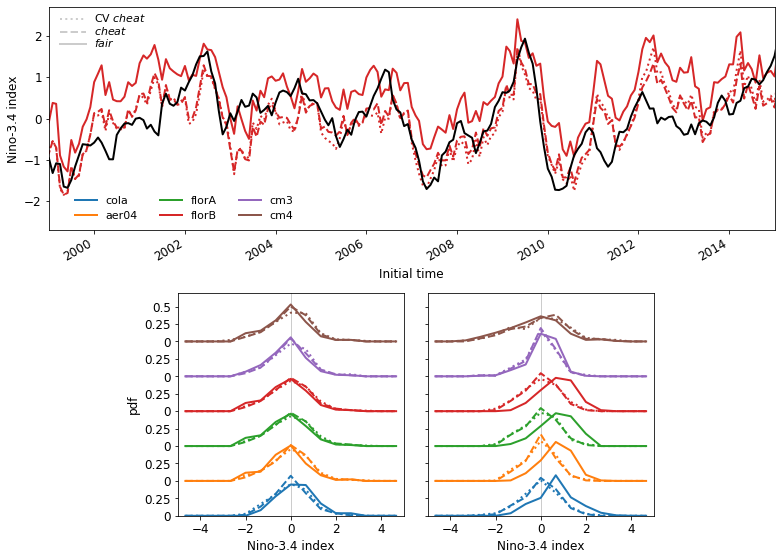

In [195]:
linewidth = 2
fontsize = 12
grey = [0.8,0.8,0.8]

fig = plt.figure(figsize=(11.2,6.2))
axes_locs = [[0.1,0.64,0.9,0.5], 
             [0.26,0,0.28,0.5],[0.57,0,0.28,0.5]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
    
# Timeseries plot -----
ax = axes[0]
lead=6
model = florB_nino34.mean('ensemble')
model['c1ncv'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle='--', label='$cheat$', linewidth=linewidth)
model['c1_7yr'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle=':', label='CV $cheat$', linewidth=linewidth)
obs_2_use['c1ncv'].sel(lead_time=lead).plot(ax=ax, color='k', label='observations ($o_{\mathrm{test}}^{\mathrm{obs}}$)', linewidth=linewidth, zorder=10)
model['c2'].sel(lead_time=lead).plot(ax=ax, color=colors[3], linestyle='-', label='$fair$', linewidth=linewidth)

ax.set_xlim('1999','2015')
ax.set_ylim(-2.7,2.7);
ax.set_xlabel('Initial time', fontsize=fontsize)
ax.set_ylabel('Nino-3.4 index', fontsize=fontsize)
ax.set_title('');
ax.set_yticks(np.arange(-2,3,1))

# Legend -----
span = pd.date_range('1999-04-01','1999-11-01', freq='15D')
ax.plot(span,2.4*np.ones_like(span.astype(int)), linestyle=':', linewidth=linewidth, color=grey)
ax.text('2000-01', 2.33, 'CV $cheat$', fontsize=fontsize-1)
ax.plot(span,2.1*np.ones_like(span.astype(int)), linestyle='--', linewidth=linewidth, color=grey)
ax.text('2000-01', 2.03, '$cheat$', fontsize=fontsize-1)
ax.plot(span,1.8*np.ones_like(span.astype(int)), linestyle='-', linewidth=linewidth, color=grey)
ax.text('2000-01', 1.73, '$fair$', fontsize=fontsize-1);

# pdf plots -----
test_period = slice('1999','2015')
leads = [0, 6]
models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

for idy, lead in enumerate(leads):
    ax = axes[idy+1]
    for idx, model in enumerate(models):

        pdf_mod_c1ncv = doppyo.utils.pdf((model['c1ncv'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*idx
        pdf_mod_c17yr = doppyo.utils.pdf((model['c1_7yr'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*idx
        pdf_mod_c2 = doppyo.utils.pdf((model['c2'].mean('ensemble').sel(init_date=test_period)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*idx


        pdf_mod_c1ncv.sel(lead_time=lead).plot(ax=ax, color=colors[idx], linestyle='--', linewidth=linewidth, label='_nolabel_')
        pdf_mod_c17yr.sel(lead_time=lead).plot(ax=ax, color=colors[idx], linestyle=':', linewidth=linewidth, label='_nolabel_')
        pdf_mod_c2.sel(lead_time=lead).plot(ax=ax, color=colors[idx], linestyle='-', linewidth=linewidth, label=model_name[idx])

    ax.set_ylim(0,0.5*(len(models))+0.1)
    ax.set_xlabel('Nino-3.4 index')
    ax.set_title('')
    if idy == 0:
        ax.set_yticks(np.arange(0,3.25,0.25));
        ax.set_yticklabels([0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0.5]);
    else:
        ax.set_yticks(np.arange(0,3.25,0.25));
        ax.set_yticklabels([]);
        ax.set_ylabel('')
    ax.set_xticks(np.arange(-6,6,2))
    ax.set_xlim(-5,5)
    ax.plot([0, 0],[0, 3.2], color=grey, zorder=0, linewidth=linewidth-1)
    ax.set_ylim(0,3.2)
    
    if idy == 0:
        leg = legend = ax.legend(ncol=3, fontsize=fontsize-1, loc='upper left', bbox_to_anchor=[-0.5,0.00,1.5,1.48], framealpha=0.5)
        legend.get_frame().set_facecolor('w')
        legend.get_frame().set_edgecolor('w')
    
plt.savefig(saveloc + 'nino34_timeseries_pdflead0and6_CV.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_timeseries_pdflead0and6_CV.pdf', format='pdf', bbox_inches='tight')

# How do the model **c2** anomalies compare when assessed relative to observed **c2slide** anomalies?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


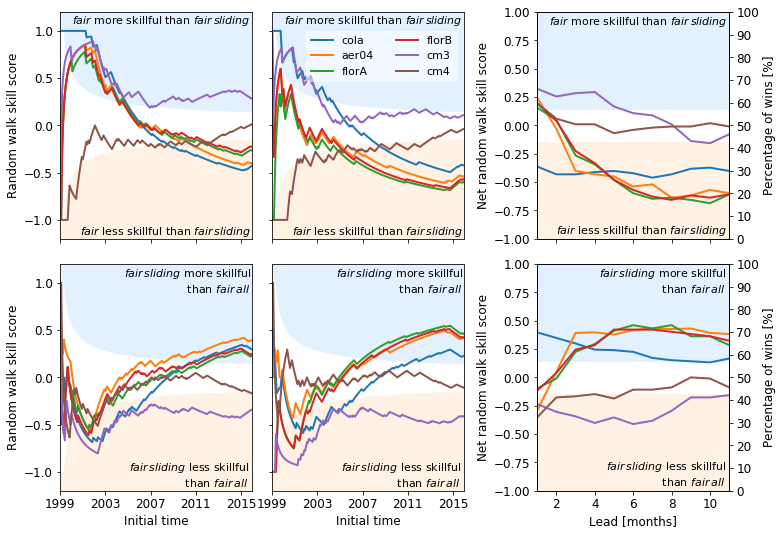

In [352]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.2,7))
axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
             [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
anoms = [('c2slide',c_gp), ('c2all', 'c2slide')]
models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

count=0
for idx, anom in enumerate(anoms):
    for idy, model in enumerate(models):
        for idz, lead in enumerate(leads):
            axI = idx * len(leads) + idz + count
            ax = axes[axI]
            sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                model[anom[1]].mean('ensemble'), 
                                                obs_2_use[c_gp].sel(init_date=slice('1999','2015')))
            norm = (1 + 0*sign).cumsum('init_date')

            if idy == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
            ax.plot((sign / norm).init_date, -(sign / norm).sel(lead_time=lead), label=model_name[idy], linewidth=linewidth)

            ax.set_xlim('1999','2016')
            ax.set_xticks(['1999','2003','2007','2011','2015'])
            ax.set_xticklabels(['1999','2003','2007','2011','2015'])
            if axI < len(anoms) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Initial time')
            if idz == 0:
                ax.set_ylabel('Random walk skill score')

            ax.set_ylim(-1.2,1.2)
            if idz > 0:
                ax.set_yticklabels([])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if (idy == 0) & (idx == 0):
                ax.text('2000-02',1.07,'$fair$ more skillful than $fair\, sliding$', fontsize=fontsize-1)
                ax.text('2000-10',-1.16,'$fair$ less skillful than $fair\, sliding$', fontsize=fontsize-1)
            elif (idy == 0) & (idx == 1):
                ax.text('2004-09',0.90,'$fair\, sliding$ more skillful \n                  than $fair\, all$', fontsize=fontsize-1)
                ax.text('2005-02',-1.16,'$fair\, sliding$ less skillful \n                than $fair\, all$', fontsize=fontsize-1)

            if (idx == 0) & (idz == 1) & (idy == len(models)-1):
                leg = legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0.00,0.00,0.99,0.94], framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

        ax = axes[axI+1]
#         sign_test = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
#                                            model[anom[1]].mean('ensemble'), 
#                                            obs_2_use[c_gp].sel(init_date=slice('1999','2015')))

#         sign_masked = sign_test[0].fillna(0)
#         conf_masked = sign_test[1].fillna(0)
#         norm = ((1 + 0*sign_masked).sum('init_date') ** 2 + (1 + 0*sign_masked).sum('init_date')) / 2
#         sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
#                                            x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
#         conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
#                                            x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

#         if idy == 0:
#             ax.fill_between(conf_area.lead_time,
#                             -1 * conf_area, conf_area, color=grey, label='_nolegend_')
#         ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz], linewidth=linewidth)
        
        sign, conf = doppyo.skill.sign_test(model[anom[0]].mean('ensemble'), 
                                                model[anom[1]].mean('ensemble'), 
                                                obs_2_use[c_gp].sel(init_date=slice('1999','2015')))
        norm = (1 + 0*sign).cumsum('init_date')

        if idy == 0:
            conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
            ax.fill_between(conf.lead_time.values,
                            (-1 * conf_plot).sel(init_date='2015-12-01'), 
                            conf_plot.sel(init_date='2015-12-01'), color=grey, label='_nolegend_')
        ax.plot((sign / norm).lead_time, -(sign / norm).sel(init_date='2015-12-01'), label=model_name[idy], linewidth=linewidth)

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        
        if (idy == 0) & (idx == 0):
            ax.text(1.6,0.89,'$fair$ more skillful than $fair\, sliding$', fontsize=fontsize-1)
            ax.text(2.0,-0.96,'$fair$ less skillful than $fair\, sliding$', fontsize=fontsize-1)
        elif (idy == 0) & (idx == 1):
            ax.text(4.2,0.75,'$fair\, sliding$ more skillful \n                  than $fair\, all$', fontsize=fontsize-1)
            ax.text(4.6,-0.96,'$fair\, sliding$ less skillful \n                than $fair\, all$', fontsize=fontsize-1)

        ax.set_ylim(-1,1)
        ax.set_ylabel('Net random walk skill score')
        ax.set_xlim(1,11)
        ax.set_xticks(np.arange(2,12,2))
        if axI < len(anoms) + 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Lead [months]')
            
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, 1)
    ax2.set_yticks(np.arange(0,1.1,0.1))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.1)).astype(int))
    ax2.set_ylabel('Percentage of wins [%]')

    count += 1

plt.savefig(saveloc + 'nino34_fair-v-fairsliding.eps', format='eps', bbox_inches='tight') 
plt.savefig(saveloc + 'nino34_fair-v-fairsliding.pdf', format='pdf', bbox_inches='tight')

# Let's look at the model climatologies over the hindcast and verification periods

In [197]:
def init_date_to_target_date(da, init_date_coord='init_month', lead_time_coord='lead_time'):
    """ 
    Convert from initial date format to target date format 
    Note : this function only works when initial date and lead time are matching frequencies
    """
    new = []
    for lead in da[lead_time_coord]:
        rolled = da.sel({lead_time_coord : lead.values}).roll(**{init_date_coord : lead.values})
        rolled[init_date_coord].values = da[init_date_coord].values
        new.append(rolled)

    return xr.concat(new, dim=lead_time_coord).rename({init_date_coord : init_date_coord.replace('init','target')})

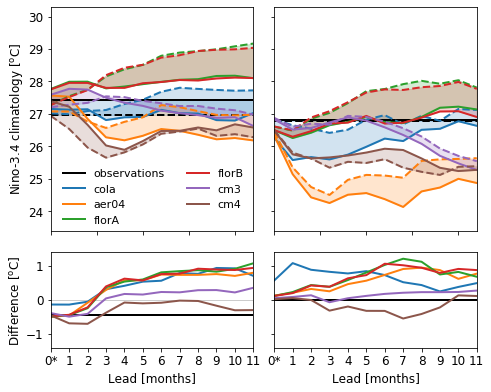

In [168]:
linewidth = 2
fontsize = 12
grey = [0.8,0.8,0.8]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 

matplotlib.rcParams.update({'font.size': fontsize})
fig = plt.figure(figsize=(9.7,7.4))
axes_locs = [[0,0.47,0.29,0.42],[0,0.25,0.29,0.18],
             [0.32,0.47,0.29,0.42],[0.32,0.25,0.29,0.18]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

train_period = slice('1982','1998')
test_period = slice('1999','2015')

models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']
months = [3, 9]

for idx, model in enumerate(models):
    
    for idy, month in enumerate(months):
        train_clim = init_date_to_target_date(model['full'].sel(init_date=train_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month').sel(month=month)
        test_clim = init_date_to_target_date(model['full'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month').sel(month=month)

        ax = axes[idy*len(months)]
        if idx == 0:
            obs_clim_train = obs_2_use['full'].sel(init_date=train_period).groupby('init_date.month').mean(['init_date']).sel(month=month)
            obs_clim_test = obs_2_use['full'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date']).sel(month=month)
            ax.fill_between(obs_clim_train.lead_time, obs_clim_train.sel(lead_time=0).values * (1 + 0*obs_clim_train), 
                             obs_clim_test.sel(lead_time=0).values * (1 + 0*obs_clim_train), color=colors[idx], label='_nolabel_', alpha=0.2)
            ax.plot(obs_clim_train.lead_time, obs_clim_train.sel(lead_time=0).values * (1 + 0*obs_clim_train), color='k',linewidth=linewidth, label='observations')
            ax.plot(obs_clim_test.lead_time, obs_clim_test.sel(lead_time=0).values * (1 + 0*obs_clim_train), color='k', linestyle='--', linewidth=linewidth, label='_nolabel_')
        ax.fill_between(train_clim.lead_time, train_clim, test_clim, color=colors[idx], label='_nolabel_', alpha=0.2)
        ax.plot(train_clim.lead_time, train_clim, color=colors[idx], label=model_name[idx], linewidth=linewidth)
        ax.plot(test_clim.lead_time, test_clim, color=colors[idx], label='_nolabel_', linestyle='--', linewidth=linewidth)
        ax.set_ylim(23.4,30.3)
        ax.set_xlabel('')
        if idy == 0:
            ax.set_ylabel('Nino-3.4 climatology [$^\mathrm{o}$C]')
        else:
            ax.set_yticklabels([])
        ax.set_xlim(0,11)
        ax.set_xticklabels([])

        ax = axes[idy*len(months)+1]
        if idx == 0:
            obs_clim_train = obs_2_use['full'].sel(init_date=train_period).groupby('init_date.month').mean(['init_date']).sel(month=month)
            obs_clim_test = obs_2_use['full'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date']).sel(month=month)
            ax.plot(obs_clim_train.lead_time, obs_clim_test.sel(lead_time=0).values * (1 + 0*obs_clim_test) - 
                    obs_clim_train.sel(lead_time=0).values * (1 + 0*obs_clim_train), color='k',linewidth=linewidth)

        ax.plot(train_clim.lead_time, test_clim - train_clim, color=colors[idx], label=model_name[idx], linewidth=linewidth)
        ax.plot(train_clim.lead_time, 0*train_clim.lead_time, color=grey, label='_nolabel_', linewidth=linewidth-1, zorder=0)
        ax.set_ylim(-1.4,1.4)
        ax.set_xlabel('')
        if idy == 0:
            ax.set_ylabel('Difference [$^\mathrm{o}$C]')
        else:
            ax.set_yticklabels([])
        ax.set_xticks(np.arange(0,13,2))
        ax.set_xlim(0,11)
        ax.set_xticks(np.arange(0,12))
        ax.set_xticklabels(['0*'] + np.arange(1,12).tolist())
        ax.set_xlabel('Lead [months]')
    
ax = axes[0]
legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='lower left', bbox_to_anchor=[0.01,-0.02,1,1])
legend.get_frame().set_facecolor('w')
legend.get_frame().set_edgecolor('w')

# plt.savefig(saveloc + 'nino34_MarchSept_climatologies.eps', format='eps', bbox_inches='tight')
# plt.savefig(saveloc + 'nino34_MarchSept_climatologies.pdf', format='pdf', bbox_inches='tight')

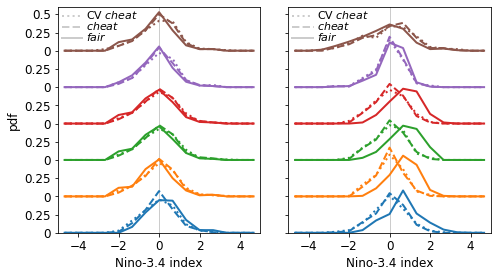

In [169]:
linewidth = 2
fontsize = 12
grey = [0.8,0.8,0.8]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 

matplotlib.rcParams.update({'font.size': fontsize})
fig = plt.figure(figsize=(9.7,4.9))
axes_locs = [[0.35,0.25,0.29,0.64],[0.68,0.25,0.29,0.64]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

period_2 = slice('1999','2015')
leads = [0, 6]

for idy, lead in enumerate(leads):
    ax = axes[idy]
    for idx, model in enumerate(models):

        pdf_mod_c1ncv = doppyo.utils.pdf((model['c1ncv'].mean('ensemble').sel(init_date=period_2)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*idx
        pdf_mod_c17yr = doppyo.utils.pdf((model['c1_7yr'].mean('ensemble').sel(init_date=period_2)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*idx
        pdf_mod_c2 = doppyo.utils.pdf((model['c2'].mean('ensemble').sel(init_date=period_2)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*idx


        pdf_mod_c1ncv.sel(lead_time=lead).plot(ax=ax, color=colors[idx], linestyle='--', linewidth=linewidth)
        pdf_mod_c17yr.sel(lead_time=lead).plot(ax=ax, color=colors[idx], linestyle=':', linewidth=linewidth)
        pdf_mod_c2.sel(lead_time=lead).plot(ax=ax, color=colors[idx], linestyle='-', linewidth=linewidth)

    # pdf_obs_c1ncv = doppyo.utils.pdf((obs_2_use['c1ncv'].sel(init_date=period_2)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*(idx+1)
    # pdf_obs_c17yr = doppyo.utils.pdf((obs_2_use['c1ncv'].sel(init_date=period_2)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*(idx+1)
    # pdf_obs_c2 = doppyo.utils.pdf((obs_2_use['c2'].sel(init_date=period_2)), bin_edges=np.linspace(-5,5,16), over_dims='init_date') + 0.5*(idx+1)

    # pdf_obs_c1ncv.sel(lead_time=lead).plot(ax=ax, color='k', linestyle='--')
    # pdf_obs_c17yr.sel(lead_time=lead).plot(ax=ax, color='k', linestyle=':')
    # pdf_obs_c2.sel(lead_time=lead).plot(ax=ax, color='k', linestyle='-')

    ax.set_ylim(0,0.5*(len(models))+0.1)
    ax.set_xlabel('Nino-3.4 index')
    ax.set_title('')
    if idy == 0:
        ax.set_yticks(np.arange(0,3.25,0.25));
        ax.set_yticklabels([0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0,0.25,0.5]);
    else:
        ax.set_yticks(np.arange(0,3.25,0.25));
        ax.set_yticklabels([]);
        ax.set_ylabel('')
    ax.set_xticks(np.arange(-6,6,2))
    ax.set_xlim(-5,5)

    # Legend -----
    ax.plot([-4.8,-3.8],[2.97, 2.97], linestyle=':', linewidth=linewidth, color=grey)
    ax.text(-3.6, 2.94, 'CV $cheat$', fontsize=fontsize-1)
    ax.plot([-4.8,-3.75],[2.82, 2.82], linestyle='--', linewidth=linewidth, color=grey)
    ax.text(-3.6, 2.79, '$cheat$', fontsize=fontsize-1)
    ax.plot([-4.8,-3.8],[2.67, 2.67], linestyle='-', linewidth=linewidth, color=grey)
    ax.text(-3.6, 2.64, '$fair$', fontsize=fontsize-1);
    
    ax.plot([0, 0],[0, 3.1], color=grey, zorder=0, linewidth=linewidth-1)
    
    
# plt.savefig(saveloc + 'nino34_lead0and6_pdfs.eps', format='eps', bbox_inches='tight')
# plt.savefig(saveloc + 'nino34_lead0and6_pdfs.pdf', format='pdf', bbox_inches='tight')

# Contour plots of climatologies and biases

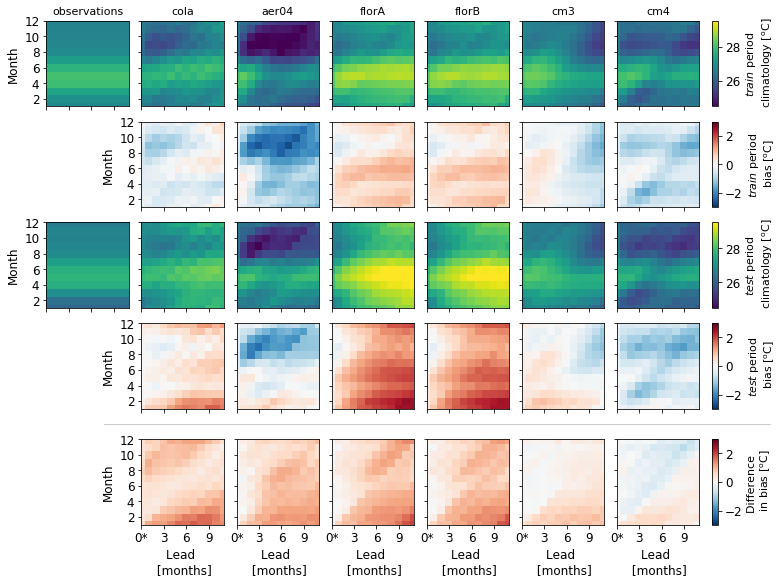

In [170]:
linewidth = 2
fontsize = 12
grey = [0.8,0.8,0.8]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 

matplotlib.rcParams.update({'font.size': fontsize})
fig = plt.figure(figsize=(8.8,7))
# axes = fig.subplots(nrows=3, ncols=7)

width = 0.13
height = 0.17
axes_locs = [[x, 0.8, width, height] for x in np.arange(0, 1, 0.15)] + \
            [[x, 0.6, width, height] for x in np.arange(0.15, 1, 0.15)] + \
            [[x, 0.4, width, height] for x in np.arange(0, 1, 0.15)] + \
            [[x, 0.2, width, height] for x in np.arange(0.15, 1, 0.15)] + \
            [[x, -0.03, width, height] for x in np.arange(0.15, 1, 0.15)]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

train_period = slice('1982','1998')
test_period = slice('1999','2015')

models = [obs_2_use, cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['observations', 'cola','aer04','florA','florB','cm3','cm4']

for idx, model in enumerate(models):
    if model_name[idx] == 'observations':
        train_clim = init_date_to_target_date(model['full'].sel(init_date=train_period).groupby('init_date.month').mean(['init_date']), init_date_coord='month')
        train_clim = train_clim.sel(lead_time=0) * (1 + 0*train_clim)
        obs_train_clim = train_clim
        test_clim = init_date_to_target_date(model['full'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date']), init_date_coord='month')
        test_clim = test_clim.sel(lead_time=0) * (1 + 0*test_clim)
        obs_test_clim = test_clim
    else:
        train_clim = init_date_to_target_date(model['full'].sel(init_date=train_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month')
        test_clim = init_date_to_target_date(model['full'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month')

    ax0 = axes[idx]
    ax1 = axes[idx + len(models) - 1]
    ax2 = axes[idx + 2*len(models) - 1]
    ax3 = axes[idx + 3*len(models) - 2]
    ax4 = axes[idx + 4*len(models) - 3]
        
    p1 = train_clim.plot(x='lead_time',ax=ax0, add_colorbar=False, vmin=24.5, vmax=29.5, cmap='viridis') 
    if idx != 0:
        p2 = (train_clim - obs_train_clim).plot(x='lead_time',ax=ax1, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
    p3 = test_clim.plot(x='lead_time',ax=ax2, add_colorbar=False, vmin=24.5, vmax=29.5, cmap='viridis') 
    if idx != 0:
        p4 = (test_clim - obs_test_clim).plot(x='lead_time',ax=ax3, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
    if idx != 0:
        p5 = ((test_clim - obs_test_clim)-(train_clim - obs_train_clim)).plot(x='lead_time',ax=ax4, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
    
#     ax2.plot([0,11],[3,3],color='k', linestyle='--', linewidth=linewidth-1)
#     ax2.plot([0,11],[9,9],color='k', linestyle='--', linewidth=linewidth-1)
    
    if idx == 6:
        ps = [p1, p2, p3, p4, p5]
        cax_y = [0.8, 0.6,0.4,0.2,-0.03]
        label = ['$train$ period \n climatology [$^\mathrm{o}$C]',
                '$train$ period \n bias [$^\mathrm{o}$C]',
                '$test$ period \n climatology [$^\mathrm{o}$C]',
                '$test$ period \n bias [$^\mathrm{o}$C]',
                'Difference \n in bias [$^\mathrm{o}$C]']
        for idc, p in enumerate(ps):
            cbaxes = fig.add_axes([1.05, cax_y[idc], 0.01, height]) 
            cb = plt.colorbar(p, cax = cbaxes)
            cb.set_label(label[idc], rotation=90, fontsize=fontsize-1)
    
    if (idx == 0):
        ax0.set_yticks(np.arange(0,13,2))
        ax2.set_yticks(np.arange(0,13,2))
        ax0.set_ylabel('Month')
        ax2.set_ylabel('Month')
    else:
        ax0.set_yticks(np.arange(0,13,2))
        ax2.set_yticks(np.arange(0,13,2))
        ax0.set_yticklabels([])
        ax2.set_yticklabels([])
        ax0.set_ylabel('')
        ax2.set_ylabel('')
        
    if (idx == 1):
        ax1.set_yticks(np.arange(0,13,2))
        ax3.set_yticks(np.arange(0,13,2))
        ax4.set_yticks(np.arange(0,13,2))
        ax1.set_ylabel('Month')
        ax3.set_ylabel('Month')
        ax4.set_ylabel('Month')
    else:
        ax1.set_yticks(np.arange(0,13,2))
        ax3.set_yticks(np.arange(0,13,2))
        ax4.set_yticks(np.arange(0,13,2))
        ax1.set_yticklabels([])
        ax3.set_yticklabels([])
        ax4.set_yticklabels([])
        ax1.set_ylabel('')
        ax3.set_ylabel('')
        ax4.set_ylabel('')
        
    ax0.set_xticks(np.arange(0,13,3))
    ax0.set_xticklabels([])
    ax0.set_xlabel('')
    ax1.set_xticks(np.arange(0,13,3))
    ax1.set_xticklabels([])
    ax1.set_xlabel('')
    ax2.set_xticks(np.arange(0,13,3))
    ax2.set_xticklabels([])
    ax2.set_xlabel('')
    ax3.set_xticks(np.arange(0,13,3))
    ax3.set_xticklabels([])
    ax3.set_xlabel('')
    ax4.set_xticks(np.arange(0,13,3))
    ax4.set_xticklabels(['0*'] + np.arange(3,13,3).tolist())
    ax4.set_xlabel('Lead \n [months]')
    ax0.set_title(model_name[idx], fontsize=fontsize-1)
    
    ax0.set_xlim(0,11)
    ax1.set_xlim(0,11) 
    ax2.set_xlim(0,11)
    ax3.set_xlim(0,11)
    ax4.set_xlim(0,11)
    ax0.set_ylim(1,12)
    ax1.set_ylim(1,12) 
    ax2.set_ylim(1,12)
    ax3.set_ylim(1,12)
    ax4.set_ylim(1,12)
    
    if idx == 1:
        ax4.plot([-5,84],[14,14], color=grey, linewidth=linewidth-1, clip_on=False)
    
# plt.savefig(saveloc + 'nino34_climatologies_contour.eps', format='eps', bbox_inches='tight')
# plt.savefig(saveloc + 'nino34_climatologies_contour.pdf', format='pdf', bbox_inches='tight')

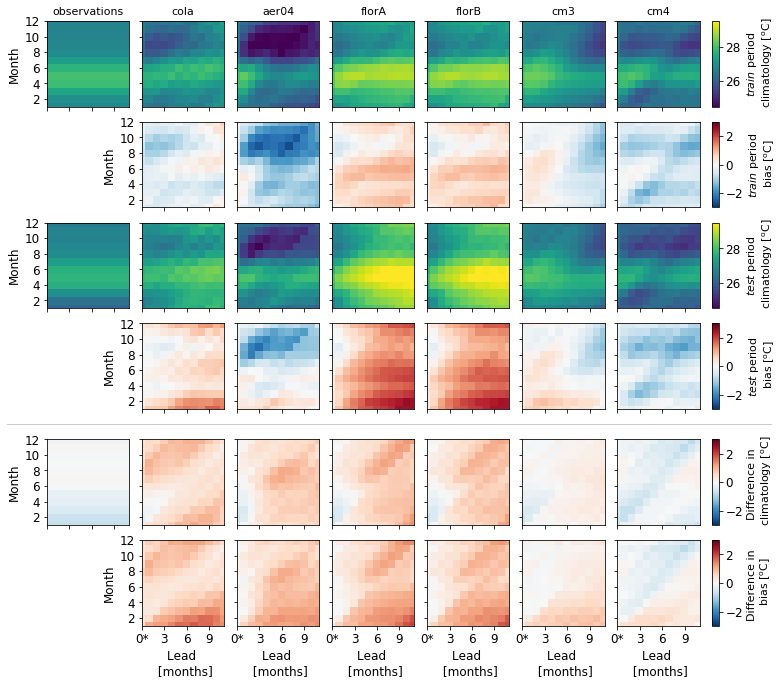

In [199]:
linewidth = 2
fontsize = 12
grey = [0.8,0.8,0.8]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 

matplotlib.rcParams.update({'font.size': fontsize})
fig = plt.figure(figsize=(8.8,7))
# axes = fig.subplots(nrows=3, ncols=7)

width = 0.13
height = 0.17
axes_locs = [[x, 0.8, width, height] for x in np.arange(0, 1, 0.15)] + \
            [[x, 0.6, width, height] for x in np.arange(0.15, 1, 0.15)] + \
            [[x, 0.4, width, height] for x in np.arange(0, 1, 0.15)] + \
            [[x, 0.2, width, height] for x in np.arange(0.15, 1, 0.15)] + \
            [[x, -0.03, width, height] for x in np.arange(0, 1, 0.15)] + \
            [[x, -0.23, width, height] for x in np.arange(0.15, 1, 0.15)]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

train_period = slice('1982','1998')
test_period = slice('1999','2015')

models = [obs_2_use, cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['observations', 'cola','aer04','florA','florB','cm3','cm4']

for idx, model in enumerate(models):
    if model_name[idx] == 'observations':
        train_clim = init_date_to_target_date(model['full'].sel(init_date=train_period).groupby('init_date.month').mean(['init_date']), init_date_coord='month')
        train_clim = train_clim.sel(lead_time=0) * (1 + 0*train_clim)
        obs_train_clim = train_clim
        test_clim = init_date_to_target_date(model['full'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date']), init_date_coord='month')
        test_clim = test_clim.sel(lead_time=0) * (1 + 0*test_clim)
        obs_test_clim = test_clim
    else:
        train_clim = init_date_to_target_date(model['full'].sel(init_date=train_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month')
        test_clim = init_date_to_target_date(model['full'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month')

    ax0 = axes[idx]
    ax1 = axes[idx + len(models) - 1]
    ax2 = axes[idx + 2*len(models) - 1]
    ax3 = axes[idx + 3*len(models) - 2]
    ax4 = axes[idx + 4*len(models) - 2]
    ax5 = axes[idx + 5*len(models) - 3]
        
    p1 = train_clim.plot(x='lead_time',ax=ax0, add_colorbar=False, vmin=24.5, vmax=29.5, cmap='viridis') 
    if idx != 0:
        p2 = (train_clim - obs_train_clim).plot(x='lead_time',ax=ax1, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
    p3 = test_clim.plot(x='lead_time',ax=ax2, add_colorbar=False, vmin=24.5, vmax=29.5, cmap='viridis') 
    if idx != 0:
        p4 = (test_clim - obs_test_clim).plot(x='lead_time',ax=ax3, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
    p5 = (test_clim - train_clim).plot(x='lead_time',ax=ax4, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
    if idx != 0:
        p6 = ((test_clim - obs_test_clim) - (train_clim - obs_train_clim)).plot(x='lead_time',ax=ax5, add_colorbar=False, vmin=-3, vmax=3, cmap='RdBu_r') 
    
#     ax2.plot([0,11],[3,3],color='k', linestyle='--', linewidth=linewidth-1)
#     ax2.plot([0,11],[9,9],color='k', linestyle='--', linewidth=linewidth-1)
    
    if idx == 6:
        ps = [p1, p2, p3, p4, p5, p6]
        cax_y = [0.8, 0.6,0.4,0.2,-0.03, -0.23]
        label = ['$train$ period \n climatology [$^\mathrm{o}$C]',
                '$train$ period \n bias [$^\mathrm{o}$C]',
                '$test$ period \n climatology [$^\mathrm{o}$C]',
                '$test$ period \n bias [$^\mathrm{o}$C]',
                 'Difference in \n climatology [$^\mathrm{o}$C]',
                'Difference in \n bias [$^\mathrm{o}$C]']
        for idc, p in enumerate(ps):
            cbaxes = fig.add_axes([1.05, cax_y[idc], 0.01, height]) 
            cb = plt.colorbar(p, cax = cbaxes)
            cb.set_label(label[idc], rotation=90, fontsize=fontsize-1)
    
    if (idx == 0):
        ax0.set_yticks(np.arange(0,13,2))
        ax2.set_yticks(np.arange(0,13,2))
        ax4.set_yticks(np.arange(0,13,2))
        ax0.set_ylabel('Month')
        ax2.set_ylabel('Month')
        ax4.set_ylabel('Month')
    else:
        ax0.set_yticks(np.arange(0,13,2))
        ax2.set_yticks(np.arange(0,13,2))
        ax4.set_yticks(np.arange(0,13,2))
        ax0.set_yticklabels([])
        ax2.set_yticklabels([])
        ax4.set_yticklabels([])
        ax0.set_ylabel('')
        ax2.set_ylabel('')
        ax4.set_ylabel('')
        
    if (idx == 1):
        ax1.set_yticks(np.arange(0,13,2))
        ax3.set_yticks(np.arange(0,13,2))
        ax5.set_yticks(np.arange(0,13,2))
        ax1.set_ylabel('Month')
        ax3.set_ylabel('Month')
        ax5.set_ylabel('Month')
    else:
        ax1.set_yticks(np.arange(0,13,2))
        ax3.set_yticks(np.arange(0,13,2))
        ax5.set_yticks(np.arange(0,13,2))
        ax1.set_yticklabels([])
        ax3.set_yticklabels([])
        ax5.set_yticklabels([])
        ax1.set_ylabel('')
        ax3.set_ylabel('')
        ax5.set_ylabel('')
        
    ax0.set_xticks(np.arange(0,13,3))
    ax0.set_xticklabels([])
    ax0.set_xlabel('')
    ax1.set_xticks(np.arange(0,13,3))
    ax1.set_xticklabels([])
    ax1.set_xlabel('')
    ax2.set_xticks(np.arange(0,13,3))
    ax2.set_xticklabels([])
    ax2.set_xlabel('')
    ax3.set_xticks(np.arange(0,13,3))
    ax3.set_xticklabels([])
    ax3.set_xlabel('')
    ax4.set_xticks(np.arange(0,13,3))
    ax4.set_xticklabels([])
    ax4.set_xlabel('')
    ax5.set_xticks(np.arange(0,13,3))
    ax5.set_xticklabels(['0*'] + np.arange(3,13,3).tolist())
    ax5.set_xlabel('Lead \n [months]')
    ax0.set_title(model_name[idx], fontsize=fontsize-1)
    
    ax0.set_xlim(0,11)
    ax1.set_xlim(0,11) 
    ax2.set_xlim(0,11)
    ax3.set_xlim(0,11)
    ax4.set_xlim(0,11)
    ax5.set_xlim(0,11)
    ax0.set_ylim(1,12)
    ax1.set_ylim(1,12) 
    ax2.set_ylim(1,12)
    ax3.set_ylim(1,12)
    ax4.set_ylim(1,12)
    ax5.set_ylim(1,12)
    
    if idx == 1:
        ax4.plot([-18,84],[14,14], color=grey, linewidth=linewidth-1, clip_on=False)
    
plt.savefig(saveloc + 'nino34_climatologies_contour.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_climatologies_contour.pdf', format='pdf', bbox_inches='tight')

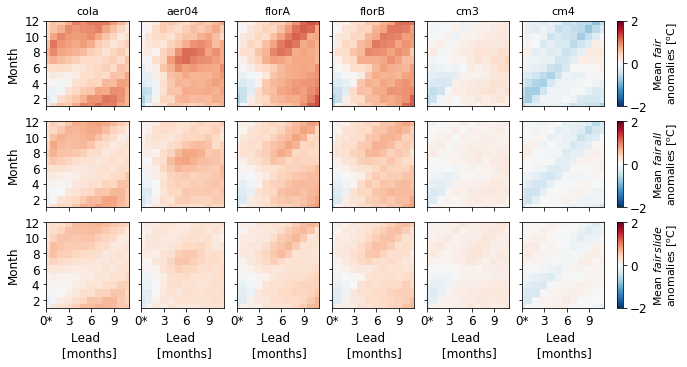

In [200]:
linewidth = 2
fontsize = 12
grey = [0.8,0.8,0.8]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 

matplotlib.rcParams.update({'font.size': fontsize})
fig = plt.figure(figsize=(8.8,7))
# axes = fig.subplots(nrows=3, ncols=7)

width = 0.13
height = 0.17
axes_locs = [[x, 0.8, width, height] for x in np.arange(0.15, 1, 0.15)] + \
            [[x, 0.6, width, height] for x in np.arange(0.15, 1, 0.15)] + \
            [[x, 0.4, width, height] for x in np.arange(0.15, 1, 0.15)]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))

train_period = slice('1982','1998')
test_period = slice('1999','2015')

models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

for idx, model in enumerate(models):
    
    fair = init_date_to_target_date(model['c2'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month')
    fair_slide = init_date_to_target_date(model['c2slide'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month')
    fair_all = init_date_to_target_date(model['c2all'].sel(init_date=test_period).groupby('init_date.month').mean(['init_date','ensemble']), init_date_coord='month')
    
    ax0 = axes[idx]
    ax1 = axes[idx + len(models) ]
    ax2 = axes[idx + 2*len(models) ]
        
    p1 = fair.plot(x='lead_time',ax=ax0, add_colorbar=False, vmin=-2, vmax=2, cmap='RdBu_r') 
    p2 = fair_all.plot(x='lead_time',ax=ax1, add_colorbar=False, vmin=-2, vmax=2, cmap='RdBu_r') 
    p3 = fair_slide.plot(x='lead_time',ax=ax2, add_colorbar=False, vmin=-2, vmax=2, cmap='RdBu_r') 
        
    if idx == 5:
        ps = [p1, p2, p3]
        cax_y = [0.8, 0.6, 0.4,]
        label = ['Mean $fair$ \nanomalies [$^\mathrm{o}$C]',
                'Mean $fair\, all$ \nanomalies [$^\mathrm{o}$C]',
                'Mean $fair\, slide$ \nanomalies [$^\mathrm{o}$C]']
        for idc, p in enumerate(ps):
            cbaxes = fig.add_axes([1.05, cax_y[idc], 0.01, height]) 
            cb = plt.colorbar(p, cax = cbaxes)
            cb.set_label(label[idc], rotation=90, fontsize=fontsize-1)
    
    if (idx == 0):
        ax0.set_yticks(np.arange(0,13,2))
        ax1.set_yticks(np.arange(0,13,2))
        ax2.set_yticks(np.arange(0,13,2))
        ax0.set_ylabel('Month')
        ax1.set_ylabel('Month')
        ax2.set_ylabel('Month')
    else:
        ax0.set_yticks(np.arange(0,13,2))
        ax1.set_yticks(np.arange(0,13,2))
        ax2.set_yticks(np.arange(0,13,2))
        ax0.set_yticklabels([])
        ax1.set_yticklabels([])
        ax2.set_yticklabels([])
        ax0.set_ylabel('')
        ax1.set_ylabel('')
        ax2.set_ylabel('')    
        
    ax0.set_xticks(np.arange(0,13,3))
    ax0.set_xticklabels([])
    ax0.set_xlabel('')
    ax1.set_xticks(np.arange(0,13,3))
    ax1.set_xticklabels([])
    ax1.set_xlabel('')
    ax2.set_xticks(np.arange(0,13,3))
    ax2.set_xticklabels(['0*'] + np.arange(3,13,3).tolist())
    ax2.set_xlabel('Lead \n [months]')
    ax0.set_title(model_name[idx], fontsize=fontsize-1)
    
    ax0.set_xlim(0,11)
    ax1.set_xlim(0,11) 
    ax2.set_xlim(0,11)
    ax0.set_ylim(1,12)
    ax1.set_ylim(1,12) 
    ax2.set_ylim(1,12)
    
plt.savefig(saveloc + 'nino34_mean_anomalies.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_mean_anomalies.pdf', format='pdf', bbox_inches='tight')

# Plot schematic showing how onset and decay are defined

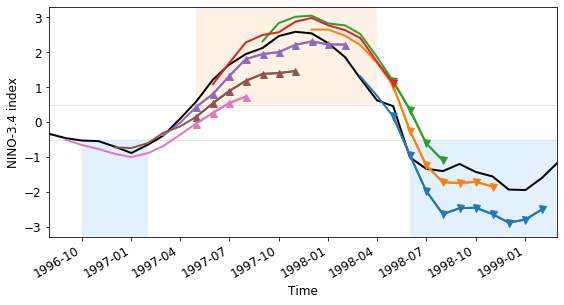

In [201]:
linewidth = 2
fontsize = 12
grey = [0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 

matplotlib.rcParams.update({'font.size': fontsize})
figure = plt.figure(figsize=(8,4.4))
fcst_dates = pd.date_range(start='1996-09', end='1998-03', freq='3MS')[::-1]
  
(0.5+0*obs_2_use[c_gp].sel(lead_time=0)).plot(color=grey, linestyle='-', linewidth=linewidth-1, zorder=0)
(-0.5+0*obs_2_use[c_gp].sel(lead_time=0)).plot(color=grey, linestyle='-', linewidth=linewidth-1, zorder=0)
obs_2_use[c_gp].sel(lead_time=0).plot(color='k', linestyle='-', linewidth=linewidth, label='Observations', zorder=0)

plt.fill_between(obs_2_use[c_gp].sel(lead_time=0).init_date.values,
                 100*obs_2_use[c_gp].where(where_elnino[c_gp]).sel(lead_time=0),
                 0.5, #-100*obs_2_use[c_gp].where(where_elnino[c_gp]).sel(lead_time=0),
                 facecolor=lower_color, linewidth=0.0, zorder=0)
plt.fill_between(obs_2_use[c_gp].sel(lead_time=0).init_date.values,
                 100*obs_2_use[c_gp].where(where_lanina[c_gp]).sel(lead_time=0),
                 -0.5, #-100*obs_2_use[c_gp].where(where_lanina[c_gp]).sel(lead_time=0),
                 facecolor=upper_color, linewidth=0.0, zorder=0)

for idx, date in enumerate(fcst_dates):
    plt.plot(doppyo.utils.leadtime_to_datetime(cm4_nino34[c_gp].sel(init_date=date)).time.values,
             doppyo.utils.leadtime_to_datetime(cm4_nino34[c_gp].sel(init_date=date)).mean('ensemble'),
             color=colors[idx], zorder=1, label='NMME individual model ensemble average', linewidth=linewidth)

for idx, date in enumerate(fcst_dates):
    plt.plot(doppyo.utils.leadtime_to_datetime(cm4_nino34[c_gp].sel(init_date=date)).time.values,
             doppyo.utils.leadtime_to_datetime(cm4_nino34[c_gp].where(where_elnino_onset[c_gp]).sel(init_date=date)).mean('ensemble'),
             color=colors[idx], zorder=1, label='_nolegend_', marker='^', markersize=7, linewidth=linewidth)

for idx, date in enumerate(fcst_dates):
    plt.plot(doppyo.utils.leadtime_to_datetime(cm4_nino34[c_gp].sel(init_date=date)).time.values,
             doppyo.utils.leadtime_to_datetime(cm4_nino34[c_gp].where(where_elnino_decay[c_gp]).sel(init_date=date)).mean('ensemble'),
             color=colors[idx], zorder=1, label='_nolegend_', marker='v', markersize=7, linewidth=linewidth)

# plt.plot(['1997-01','1999-01'],[0.5,0.5], zorder=0)
# plt.plot(['2007','2012'],[-0.5,-0.5], zorder=0)
plt.xlim('1996-08','1999-03')
plt.ylim(-3.3,3.3);
plt.xlabel('Time');
plt.ylabel('NINO-3.4 index');
plt.title('')

plt.tight_layout();
plt.savefig(saveloc + 'nino34_onset_schematic.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_onset_schematic.pdf', format='pdf', bbox_inches='tight')

# What about **onset** of El Nino and La Nina?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

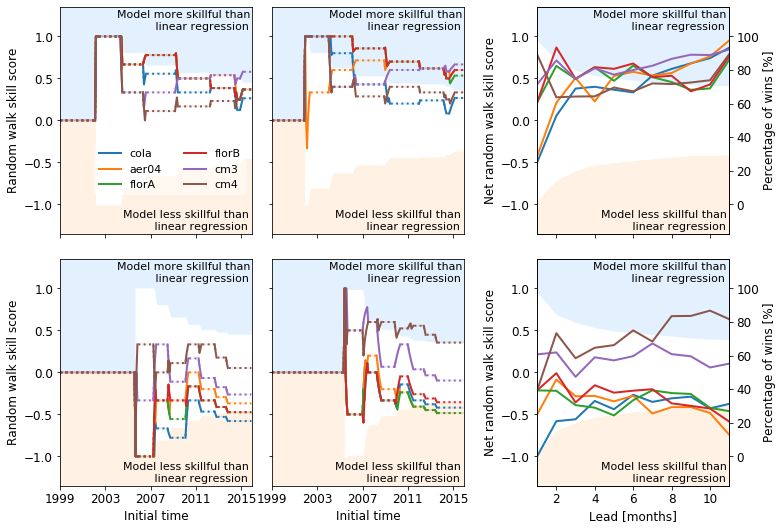

In [208]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.2,7))
axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
            [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
masks = [where_elnino_onset,
         where_lanina_onset]
models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

count = 0
for idx, mask in enumerate(masks):
    for idy, model in enumerate(models):
        for idz, lead in enumerate(leads):
            axI = idx * len(leads) + idz + count
            ax = axes[axI]
            sign, conf = doppyo.skill.sign_test(linR_nino34[c_gp].where(mask[c_gp]), 
                                                model[c_gp].mean('ensemble').where(mask[c_gp]), 
                                                obs_2_use[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))
            norm = (1 + 0*sign.where(mask[c_gp])).cumsum('init_date')

            if idy == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                (conf_plot).sel(lead_time=lead), color=grey, label='_nolegend_')

            ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                    label='_nolegend_', linewidth=linewidth, color=colors[idy], alpha=0.1)
            ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==0) | (mask[c_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                    label='_nolegend_', linewidth=linewidth, color=colors[idy], linestyle=':')
            ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==1) | (mask[c_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                    label=model_name[idy], linewidth=linewidth, linestyle='-', color=colors[idy])

            ax.set_xlim('1999','2016')
            ax.set_xticks(['1999','2003','2007','2011','2015'])
            ax.set_xticklabels(['1999','2003','2007','2011','2015'])
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Initial time')
            if idz == 0:
                ax.set_ylabel('Random walk skill score')

            ax.set_ylim(-1.35,1.35)
            if idz > 0:
                ax.set_yticklabels([])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if idy == 0:
                ax.text('2004-01',1.08,'Model more skillful than \n           linear regression', fontsize=fontsize-1)
                ax.text('2004-08',-1.3,'Model less skillful than \n         linear regression', fontsize=fontsize-1)

            if (idx == 0) & (idz == 0) & (idy == len(models)-1):
                legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='lower right', bbox_to_anchor=[0,0.15,0.99,1], framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

        ax = axes[axI+1]
        sign_test = doppyo.skill.sign_test(linR_nino34[c_gp].where(mask[c_gp]), 
                                           model[c_gp].mean('ensemble').where(mask[c_gp]), 
                                           obs_2_use[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))

        sign_masked = sign_test[0].where(mask[c_gp]).fillna(0)
        conf_masked = sign_test[1].where(mask[c_gp]).fillna(0)
        norm = ((1 + 0*sign_masked.where(mask[c_gp])).sum('init_date') ** 2 + (1 + 0*sign_masked.where(mask[c_gp])).sum('init_date')) / 2
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

        if idy == 0:
            ax.fill_between(conf_area.lead_time,
                            -1 * conf_area, conf_area, color=grey, label='_nolegend_')
        ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz], linewidth=linewidth)

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        if idy == 0:
            ax.text(3.9,1.08,'Model more skillful than \n           linear regression', fontsize=fontsize-1)
            ax.text(4.3,-1.3,'Model less skillful than \n         linear regression', fontsize=fontsize-1)

        ax.set_ylim(-1.35,1.35)
        ax.set_ylabel('Net random walk skill score')
        ax.set_xlim(1,11)
        ax.set_xticks(np.arange(2,12,2))
        if axI < len(leads) + 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Lead [months]')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
    ax2.set_ylabel('Percentage of wins [%]')
    
    count += 1
    
plt.savefig(saveloc + 'nino34_linR_onset.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_linR_onset.pdf', format='pdf', bbox_inches='tight')

# And for categorical forecasts (relative to ordered logistic regression)?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

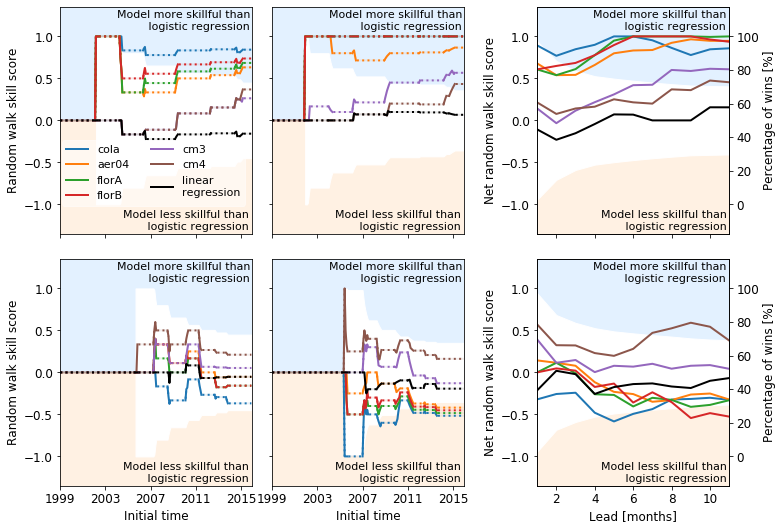

In [217]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.2,7))
axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
            [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
masks = [where_elnino_onset,
         where_lanina_onset]
models = [where_event_cola, where_event_aer04, where_event_florA, where_event_florB, where_event_cm3, where_event_cm4, where_event_linR]
model_name = ['cola','aer04','florA','florB','cm3','cm4', 'linear \nregression']

count = 0
for idx, mask in enumerate(masks):
    for idy, model in enumerate(models):
        for idz, lead in enumerate(leads):
            axI = idx * len(leads) + idz + count
            ax = axes[axI]
            sign, conf = doppyo.skill.sign_test(ologR_nino34[c_gp].where(mask[c_gp]), 
                                                model[c_gp].where(mask[c_gp]), 
                                                where_event[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))
            norm = (1 + 0*sign.where(mask[c_gp])).cumsum('init_date')

            if idy == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                (conf_plot).sel(lead_time=lead), color=grey, label='_nolegend_')

            if model_name[idy] == 'linear \nregression':
                ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                        label='_nolegend_', linewidth=linewidth, alpha=0.1, color='k')
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==0) | (mask[c_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                        label='_nolegend_', linewidth=linewidth, color='k', linestyle=':')
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==1) | (mask[c_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                        label=model_name[idy], linewidth=linewidth, linestyle='-', color='k')
            else:
                ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                        label='_nolegend_', linewidth=linewidth, alpha=0.1, color=colors[idy])
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==0) | (mask[c_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                        label='_nolegend_', linewidth=linewidth, color=colors[idy], linestyle=':')
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==1) | (mask[c_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                        label=model_name[idy], linewidth=linewidth, linestyle='-', color=colors[idy])

            ax.set_xlim('1999','2016')
            ax.set_xticks(['1999','2003','2007','2011','2015'])
            ax.set_xticklabels(['1999','2003','2007','2011','2015'])
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Initial time')
            if idz == 0:
                ax.set_ylabel('Random walk skill score')

            ax.set_ylim(-1.35,1.35)
            if idz > 0:
                ax.set_yticklabels([])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if idy == 0:
                ax.text('2004-01',1.08,'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
                ax.text('2004-08',-1.3,'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

            if (idx == 0) & (idz == 0) & (idy == len(models)-1):
                legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='lower right', bbox_to_anchor=[0,0.1,0.99,1], framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

        ax = axes[axI+1]
        sign_test = doppyo.skill.sign_test(ologR_nino34[c_gp].where(mask[c_gp]), 
                                           model[c_gp].where(mask[c_gp]), 
                                           where_event[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))

        sign_masked = sign_test[0].where(mask[c_gp]).fillna(0)
        conf_masked = sign_test[1].where(mask[c_gp]).fillna(0)
        norm = ((1 + 0*sign_masked.where(mask[c_gp])).sum('init_date') ** 2 + (1 + 0*sign_masked.where(mask[c_gp])).sum('init_date')) / 2
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

        if idy == 0:
            ax.fill_between(conf_area.lead_time,
                            -1 * conf_area, conf_area, color=grey, label='_nolegend_')
        if model_name[idy] == 'linear \nregression':
            ax.plot(sign_area.lead_time, -sign_area, label=model_name[idy], linewidth=linewidth, color='k')
        else:
            ax.plot(sign_area.lead_time, -sign_area, label=model_name[idy], linewidth=linewidth, color=colors[idy])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        if idy == 0:
            ax.text(3.9,1.08,'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
            ax.text(4.3,-1.3,'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

        ax.set_ylim(-1.35,1.35)
        ax.set_ylabel('Net random walk skill score')
        ax.set_xlim(1,11)
        ax.set_xticks(np.arange(2,12,2))
        if axI < len(leads) + 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Lead [months]')
            
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
    ax2.set_ylabel('Percentage of wins [%]')

    count += 1
    
plt.savefig(saveloc + 'nino34_olog_onset.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_olog_onset.pdf', format='pdf', bbox_inches='tight')

# What about **decay** of El Nino and La Nina?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

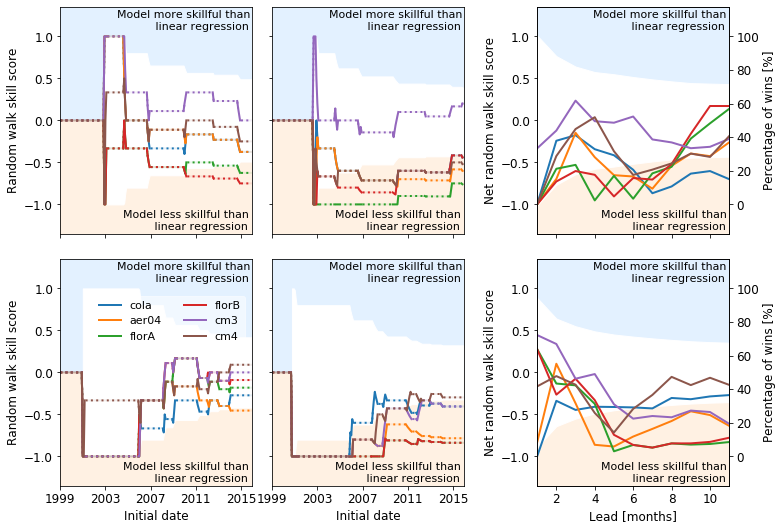

In [218]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.2,7))
axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
            [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
masks = [where_elnino_decay,
         where_lanina_decay]
models = [cola_nino34, aer04_nino34, florA_nino34, florB_nino34, cm3_nino34, cm4_nino34]
model_name = ['cola','aer04','florA','florB','cm3','cm4']

count = 0
for idx, mask in enumerate(masks):
    for idy, model in enumerate(models):
        for idz, lead in enumerate(leads):
            axI = idx * len(leads) + idz + count
            ax = axes[axI]
            sign, conf = doppyo.skill.sign_test(linR_nino34[c_gp].where(mask[c_gp]), 
                                                model[c_gp].mean('ensemble').where(mask[c_gp]), 
                                                obs_2_use[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))
            norm = (1 + 0*sign.where(mask[c_gp])).cumsum('init_date')

            if idy == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                conf_plot.sel(lead_time=lead), color=grey, label='_nolegend_')
            ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                label='_nolegend_', linewidth=linewidth, color=colors[idy], alpha=0.1)
            ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==0) | (mask[c_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                label='_nolegend_', linewidth=linewidth, color=colors[idy], linestyle=':')
            ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==1) | (mask[c_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                    label=model_name[idy], linewidth=linewidth, linestyle='-', color=colors[idy])

            ax.set_xlim('1999','2016')
            ax.set_xticks(['1999','2003','2007','2011','2015'])
            ax.set_xticklabels(['1999','2003','2007','2011','2015'])
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Initial date')
            if idz == 0:
                ax.set_ylabel('Random walk skill score')

            ax.set_ylim(-1.35,1.35)
            if idz > 0:
                ax.set_yticklabels([])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if idy == 0:
                ax.text('2004-01',1.08,'Model more skillful than \n           linear regression', fontsize=fontsize-1)
                ax.text('2004-08',-1.3,'Model less skillful than \n         linear regression', fontsize=fontsize-1)

            if (idx == 1) & (idz == 0) & (idy == len(models)-1):
                legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0,0,0.99,0.86], framealpha=0.5)
                legend.get_frame().set_facecolor('w')
                legend.get_frame().set_edgecolor('w')

        ax = axes[axI+1]
        sign_test = doppyo.skill.sign_test(linR_nino34[c_gp].where(mask[c_gp]), 
                                           model[c_gp].mean('ensemble').where(mask[c_gp]), 
                                           obs_2_use[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))

        sign_masked = sign_test[0].where(mask[c_gp]).fillna(0)
        conf_masked = sign_test[1].where(mask[c_gp]).fillna(0)
        norm = ((1 + 0*sign_masked.where(mask[c_gp])).sum('init_date') ** 2 + (1 + 0*sign_masked.where(mask[c_gp])).sum('init_date')) / 2
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

        if idy == 0:
            ax.fill_between(conf_area.lead_time,
                            -1 * conf_area, conf_area, color=grey, label='_nolegend_')
        ax.plot(sign_area.lead_time, -sign_area, label=model_name[idz], linewidth=linewidth)

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)
        if idy == 0:
            ax.text(3.9,1.08,'Model more skillful than \n           linear regression', fontsize=fontsize-1)
            ax.text(4.3,-1.3,'Model less skillful than \n         linear regression', fontsize=fontsize-1)

        ax.set_ylim(-1.35,1.35)
        ax.set_ylabel('Net random walk skill score')
        ax.set_xlim(1,11)
        ax.set_xticks(np.arange(2,12,2))
        if axI < len(leads) + 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Lead [months]')

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
    ax2.set_ylabel('Percentage of wins [%]')

    count += 1

plt.savefig(saveloc + 'nino34_linR_decay.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_linR_decay.pdf', format='pdf', bbox_inches='tight')

# And for categorical forecasts (relative to ordered logistic regression)?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

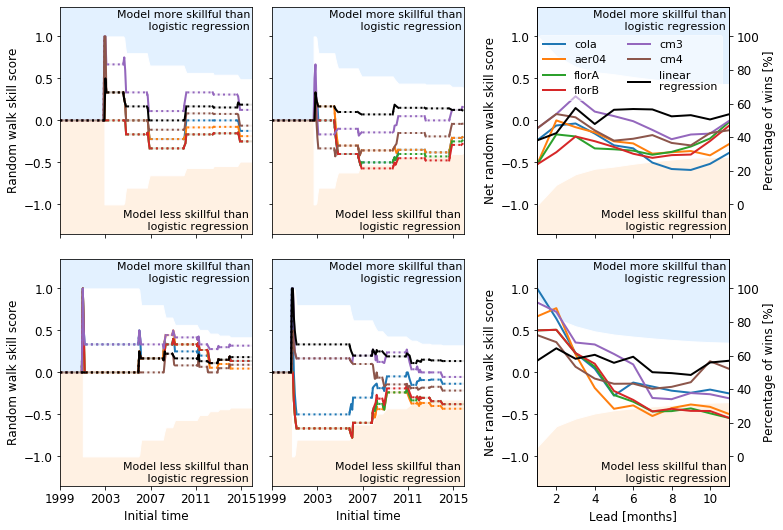

In [219]:
linewidth = 2
fontsize = 12
grey = 'w' #[0.9,0.9,0.9]

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': fontsize})

fig = plt.figure(figsize=(9.2,7))
axes_locs = [[0,0.5,0.29,0.45],[0.32,0.5,0.29,0.45],[0.72,0.5,0.29,0.45],
            [0,0,0.29,0.45],[0.32,0,0.29,0.45],[0.72,0,0.29,0.45]]
axes=[]
for axes_loc in axes_locs:
    axes.append(fig.add_axes(axes_loc))
# axes = fig.subplots(nrows=2, ncols=3)

leads = [3, 6]
masks = [where_elnino_decay,
         where_lanina_decay]
models = [where_event_cola, where_event_aer04, where_event_florA, where_event_florB, where_event_cm3, where_event_cm4, where_event_linR]
model_name = ['cola','aer04','florA','florB','cm3','cm4', 'linear \nregression']

count = 0
for idx, mask in enumerate(masks):
    for idy, model in enumerate(models):
        for idz, lead in enumerate(leads):
            axI = idx * len(leads) + idz + count
            ax = axes[axI]
            sign, conf = doppyo.skill.sign_test(ologR_nino34[c_gp].where(mask[c_gp]), 
                                                model[c_gp].where(mask[c_gp]), 
                                                where_event[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))
            norm = (1 + 0*sign.where(mask[c_gp])).cumsum('init_date')

            if idy == 0:
                conf_plot = (conf / norm).where(((conf / norm).isnull()) | ((conf / norm) <= 1), other=1)
                ax.fill_between(conf.init_date.values,
                                (-1 * conf_plot).sel(lead_time=lead), 
                                (conf_plot).sel(lead_time=lead), color=grey, label='_nolegend_')

            if model_name[idy] == 'linear \nregression':
                ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                        label='_nolegend_', linewidth=linewidth, alpha=0.1, color='k')
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==0) | (mask[c_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                        label='_nolegend_', linewidth=linewidth, color='k', linestyle=':')
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==1) | (mask[c_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                        label=model_name[idy], linewidth=linewidth, linestyle='-', color='k')
            else:
                ax.plot(sign.init_date, -(sign / norm).fillna(0).sel(lead_time=lead), 
                        label='_nolegend_', linewidth=linewidth, alpha=0.1, color=colors[idy])
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==0) | (mask[c_gp].shift(init_date=1)==0)).sel(lead_time=lead), 
                        label='_nolegend_', linewidth=linewidth, color=colors[idy], linestyle=':')
                ax.plot(sign.init_date, -(sign / norm).fillna(0).where((mask[c_gp]==1) | (mask[c_gp].shift(init_date=-1)==1)).sel(lead_time=lead), 
                        label=model_name[idy], linewidth=linewidth, linestyle='-', color=colors[idy])

            ax.set_xlim('1999','2016')
            ax.set_xticks(['1999','2003','2007','2011','2015'])
            ax.set_xticklabels(['1999','2003','2007','2011','2015'])
            if axI < len(leads) + 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Initial time')
            if idz == 0:
                ax.set_ylabel('Random walk skill score')

            ax.set_ylim(-1.35,1.35)
            if idz > 0:
                ax.set_yticklabels([])

            # Shade regions ------
            ymin, ymax = ax.get_ylim()
            xmin, xmax = ax.get_xlim()
            ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                             facecolor=upper_color, linewidth=0.0, zorder=0)
            ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                             facecolor=lower_color, linewidth=0.0, zorder=0)
            if idy == 0:
                ax.text('2004-01',1.08,'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
                ax.text('2004-08',-1.3,'Model less skillful than \n       logistic regression', fontsize=fontsize-1)

        ax = axes[axI+1]
        sign_test = doppyo.skill.sign_test(ologR_nino34[c_gp].where(mask[c_gp]), 
                                           model[c_gp].where(mask[c_gp]), 
                                           where_event[c_gp].sel(init_date=slice('1999','2015')).where(mask[c_gp]))

        sign_masked = sign_test[0].where(mask[c_gp]).fillna(0)
        conf_masked = sign_test[1].where(mask[c_gp]).fillna(0)
        norm = ((1 + 0*sign_masked.where(mask[c_gp])).sum('init_date') ** 2 + (1 + 0*sign_masked.where(mask[c_gp])).sum('init_date')) / 2
        sign_area = doppyo.utils.integrate(sign_masked, over_dim='init_date', 
                                           x=(1+0*sign_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm
        conf_area = doppyo.utils.integrate(conf_masked, over_dim='init_date', 
                                           x=(1+0*conf_masked.init_date.astype(int)).cumsum('init_date'), method='rect') / norm

        if idy == 0:
            ax.fill_between(conf_area.lead_time,
                            -1 * conf_area, conf_area, color=grey, label='_nolegend_')
        if model_name[idy] == 'linear \nregression':
            ax.plot(sign_area.lead_time, -sign_area, label=model_name[idy], linewidth=linewidth, color='k')
        else:
            ax.plot(sign_area.lead_time, -sign_area, label=model_name[idy], linewidth=linewidth, color=colors[idy])

        # Shade regions ------
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.fill_between((xmin, xmax), (0, 0), (ymax, ymax), 
                         facecolor=upper_color, linewidth=0.0, zorder=0)
        ax.fill_between((xmin, xmax), (ymin, ymin), (0, 0), 
                         facecolor=lower_color, linewidth=0.0, zorder=0)

        if idy == 0:
            ax.text(3.9,1.08,'Model more skillful than \n         logistic regression', fontsize=fontsize-1)
            ax.text(4.3,-1.3,'Model less skillful than \n       logistic regression', fontsize=fontsize-1)
            
        if (idx == 0) & (idy == len(models)-1):
            legend = ax.legend(ncol=2, fontsize=fontsize-1, loc='upper right', bbox_to_anchor=[0,0.06,0.99,0.84], framealpha=0.5)
            legend.get_frame().set_facecolor('w')
            legend.get_frame().set_edgecolor('w')

        ax.set_ylim(-1.35,1.35)
        ax.set_ylabel('Net random walk skill score')
        ax.set_xlim(1,11)
        ax.set_xticks(np.arange(2,12,2))
        if axI < len(leads) + 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Lead [months]')
            
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0-0.35/2, 1+0.35/2)
    ax2.set_yticks(np.arange(0,1.1,0.2))
    ax2.set_yticklabels((100*np.arange(0,1.1,0.2)).astype(int))
    ax2.set_ylabel('Percentage of wins [%]')

    count += 1
    
plt.savefig(saveloc + 'nino34_olog_decay.eps', format='eps', bbox_inches='tight')
plt.savefig(saveloc + 'nino34_olog_decay.pdf', format='pdf', bbox_inches='tight')

# What percentage of time are we in each state?

In [323]:
TS_oi = (oisst_nino34_full_ts.groupby('time.month') - oisst_nino34_full_ts.groupby('time.month').mean('time')).rolling(time=5).mean()

In [333]:
elnino_perc = (1+0*TS_oi.where(TS_oi>0.5)).fillna(0).mean('time').values
print(f'El Nino: {100*elnino_perc}')
neutrl_perc = (1+0*TS_oi.where((TS_oi<0.5) & (TS_oi>-0.5))).fillna(0).mean('time').values
print(f'Neutral: {100*neutrl_perc}')
lanina_perc = (1+0*TS_oi.where(TS_oi<-0.5)).fillna(0).mean('time').values
print(f'La Nina: {100*lanina_perc}')

El Nino: 25.112107623318387
Neutral: 42.37668161434978
La Nina: 31.614349775784756


In [324]:
TS_had = (had_nino34_full_ts.groupby('time.month') - had_nino34_full_ts.groupby('time.month').mean('time')).rolling(time=5).mean()

In [325]:
TS_had = TS_had.sel(time=slice('1982-02','2019-02'))

In [334]:
elnino_perc = (1+0*TS_had.where(TS_had>0.5)).fillna(0).mean('time').values
print(f'El Nino: {100*elnino_perc}')
neutrl_perc = (1+0*TS_had.where((TS_had<0.5) & (TS_had>-0.5))).fillna(0).mean('time').values
print(f'Neutral: {100*neutrl_perc}')
lanina_perc = (1+0*TS_had.where(TS_had<-0.5)).fillna(0).mean('time').values
print(f'La Nina: {100*lanina_perc}')

El Nino: 29.09930646419525
Neutral: 48.49884510040283
La Nina: 22.401846945285797


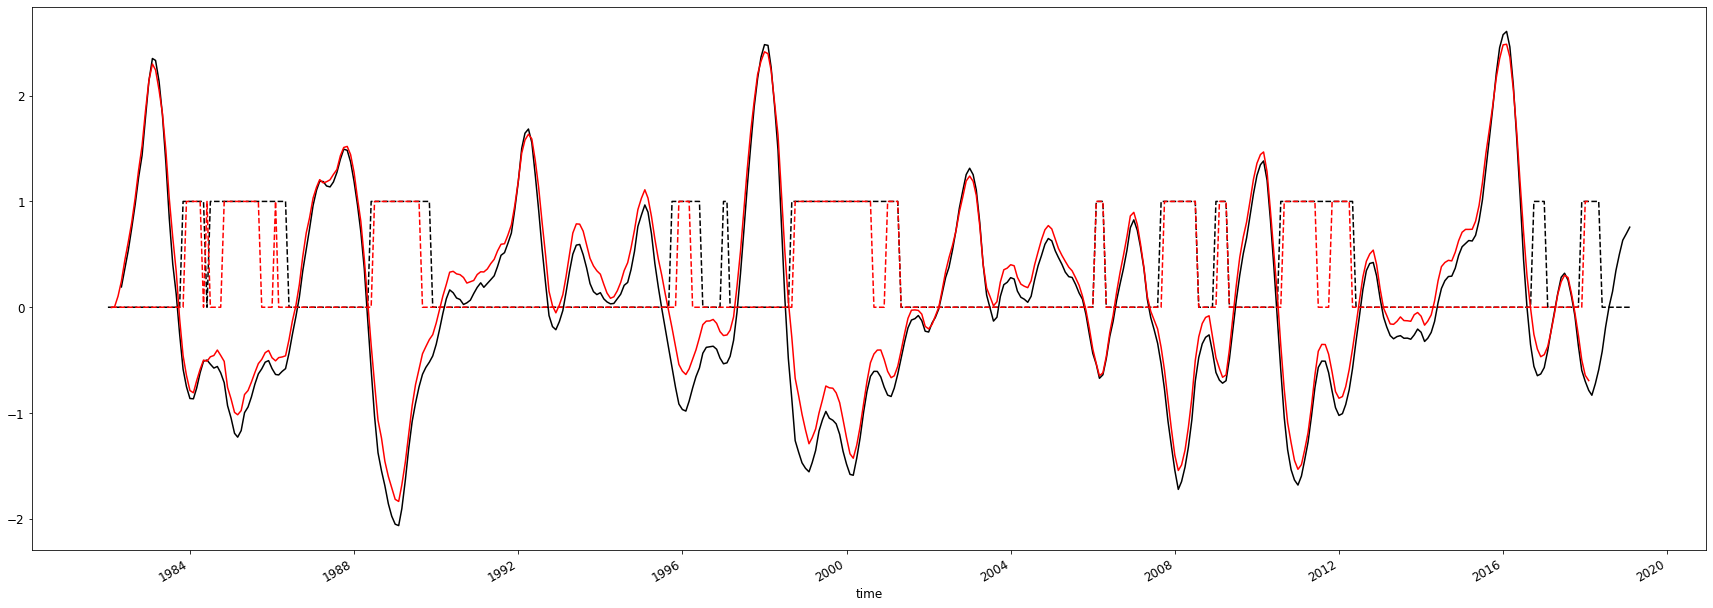

In [332]:
fig = plt.figure(figsize=(30,10))
TS_oi.plot(color='k')
(1+0*TS_oi.where(TS_oi<-0.5)).fillna(0).plot(color='k', linestyle='--')
TS_had.plot(color='r')
(1+0*TS_had.where(TS_had<-0.5)).fillna(0).plot(color='r', linestyle='--')